In [1]:
import sys
import os

In [2]:
# run_path = "/home/harishbabu/projects/PIPNet/runs/154-PruningNaiveHPIPNet_cnext13_CUB-18-imgnet-224_with-equalize-aug_img=224_nprotos=20"

# run_path = "/home/harishbabu/projects/PIPNet/runs/158-PruningNaiveHPIPNetExpWeightPruning_cnext13_CUB-18-imgnet-224_with-equalize-aug_img=224_nprotos=20"

# run_path = "/home/harishbabu/projects/PIPNet/runs/159-PruningNaiveHPIPNetMaskL1=1.0_cnext13_CUB-18-imgnet-224_with-equalize-aug_img=224_nprotos=20"

# run_path = "/home/harishbabu/projects/PIPNet/runs/160-PruningNaiveHPIPNetMaskL1=0.5_cnext13_CUB-18-imgnet-224_with-equalize-aug_img=224_nprotos=20"

# run_path = "/home/harishbabu/projects/PIPNet/runs/161-PruningNaiveHPIPNetMaskL1=0.5MaskTrainExtra=15eps_cnext13_CUB-18-imgnet-224_with-equalize-aug_img=224_nprotos=20"

# run_path = "/projects/ml4science/harishbabu/projects/PIPNet/162-PruningNaiveHPIPNetMaskL1=0.5MaskTrainExtra=15epsEps=60_cnext13_CUB-18-imgnet-224_with-equalize-aug_img=224_nprotos=20"

# run_path = "/home/harishbabu/projects/PIPNet/runs/163-PruningNaiveHPIPNetMaskL1=0.5MaskTrainExtra=15epsEps=60TanhDesc=0.2MinCont=0.1_cnext13_CUB-18-imgnet-224_with-equalize-aug_img=224_nprotos=20"

# run_path = "/projects/ml4science/harishbabu/projects/PIPNet/164-PruningNaiveHPIPNetMaskL1=0.5MaskTrainExtra=15epsEps=60TanhDesc=0.05MinCont=0.1_cnext13_CUB-18-imgnet-224_with-equalize-aug_img=224_nprotos=20"

# run_path = "/home/harishbabu/projects/PIPNet/runs/167-PruningNaiveHPIPNetMaskL1=0.5MaskTrainExtra=15epsEps=60TanhDesc=0.05MinCont=0.1_cnext26_CUB-18-imgnet-224_with-equalize-aug_img=224_nprotos=20"

run_path = "/home/harishbabu/projects/PIPNet_wandb/runs/178-PruningNaiveHPIPNetMaskL1=0.5MaskTrainExtra=15epsEps=60TanhDesc=0.05MinCont=0.1_cnext26_CUB-190-imgnet-224_WeightedCE_with-equalize-aug_img=224_nprotos=20"

# run_path = "/home/harishbabu/projects/PIPNet/runs/202-PruningBF=1.1NaiveHPIPNetMaskL1=0.5MaskTrainExtra=05epsEps=60Cl=2.0TanhDesc=0.05MinCont=0.1_cnext13_CUB-190-imgnet-224_WeightedCE_with-equalize-aug_img=224_nprotos=10pc"

# run_path = "/home/harishbabu/projects/PIPNet/runs/207-PruningBF=1.1NaiveHPIPNetMaskL1=0.5MaskTrainExtra=05epsEps=60Cl=2.0TanhDesc=0.05MinCont=0.1_cnext26_BUT-51-224_WeightedCE_with-equalize-aug_img=224_nprotos=10pc"

# run_path = "/home/harishbabu/projects/PIPNet/runs/208-PruningBF=1.1NaiveHPIPNetMaskL1=0.5MaskTrainExtra=05epsEps=60Cl=2.0TanhDesc=0.05MinCont=0.1_cnext26_FISH-38-224_WeightedCE_with-equalize-aug_img=224_nprotos=10pc"

# run_path = "runs/225-BUT30_nprotos=10pc-cnext26_PruningBF=1.1NaiveHPIPNetMaskL1=0.5MaskTrainExtra=15epsEps=60Cl=2.0TanhDesc=0.05MinCont=0.1_BUT-30-imgnet-224_WeightedCE_with-equalize-aug_img=224"

try:
    sys.path.remove('/home/harishbabu/projects/PIPNet')
except:
    pass
sys.path.insert(0, os.path.join(run_path, 'source_clone'))


In [3]:
print(run_path)

/home/harishbabu/projects/PIPNet_wandb/runs/178-PruningNaiveHPIPNetMaskL1=0.5MaskTrainExtra=15epsEps=60TanhDesc=0.05MinCont=0.1_cnext26_CUB-190-imgnet-224_WeightedCE_with-equalize-aug_img=224_nprotos=20


In [4]:
import torch.nn as nn
import torch

import sys, os
import random
import numpy as np
from shutil import copy
import matplotlib.pyplot as plt
from copy import deepcopy

from omegaconf import OmegaConf
import shutil
import pickle
import random
from tqdm import tqdm

from torchvision.datasets.folder import ImageFolder
from torch.utils.data import DataLoader
import torch.nn.functional as F
# from skimage.filters import threshold_local, gaussian
import ntpath

In [5]:
print(sys.path[0])

/home/harishbabu/projects/PIPNet_wandb/runs/178-PruningNaiveHPIPNetMaskL1=0.5MaskTrainExtra=15epsEps=60TanhDesc=0.05MinCont=0.1_cnext26_CUB-190-imgnet-224_WeightedCE_with-equalize-aug_img=224_nprotos=20/source_clone


In [6]:
# import pipnet.pipnet
# from pipnet.pipnet import PIPNet, get_network
# # from pipnet import pipnet
# print(pipnet.__file__)
from util import node
print(node.__file__)

/home/harishbabu/projects/PIPNet_wandb/runs/178-PruningNaiveHPIPNetMaskL1=0.5MaskTrainExtra=15epsEps=60TanhDesc=0.05MinCont=0.1_cnext26_CUB-190-imgnet-224_WeightedCE_with-equalize-aug_img=224_nprotos=20/source_clone/util/node.py


In [7]:
from pipnet.pipnet import PIPNet, get_network
from util.log import Log
from util.args import get_args, save_args, get_optimizer_nn
from util.data import get_dataloaders
from util.func import init_weights_xavier
from pipnet.train import train_pipnet, test_pipnet
# from pipnet.test import eval_pipnet, get_thresholds, eval_ood
from util.eval_cub_csv import eval_prototypes_cub_parts_csv, get_topk_cub, get_proto_patches_cub
from util.vis_pipnet import visualize, visualize_topk
from util.visualize_prediction import vis_pred, vis_pred_experiments
from util.node import Node
from util.phylo_utils import construct_phylo_tree, construct_discretized_phylo_tree
from util.func import get_patch_size
from util.data import ModifiedLabelLoader

Heatmaps showing where a prototype is found will not be generated because OpenCV is not installed.


In [8]:
from PIL import Image
import numpy as np
import pdb

# def get_heatmap(latent_activation, input_image):
#     image_a = latent_activation.cpu().numpy()
#     image_a = (image_a - image_a.min()) / (image_a.max() - image_a.min())

#     input_image = (input_image - input_image.min()) / (input_image.max() - input_image.min())
#     image_b = input_image.permute(1, 2, 0).cpu().numpy()
    
#     reshaped_image_a = np.array(Image.fromarray((image_a[0] * 255).astype('uint8')).resize((input_image.shape[-1], input_image.shape[-1])))
#     normalized_heatmap = (reshaped_image_a - np.min(reshaped_image_a)) / (np.max(reshaped_image_a) - np.min(reshaped_image_a))
    
#     heatmap_colormap = plt.get_cmap('jet')
#     heatmap_colored = heatmap_colormap(normalized_heatmap)
    
#     heatmap_colored_uint8 = (heatmap_colored[:, :, :3] * 255).astype(np.uint8)
#     image_a_heatmap_pillow = Image.fromarray(heatmap_colored_uint8)
#     image_b_pillow = Image.fromarray((image_b * 255).astype('uint8'))
    
#     result_image = Image.blend(image_b_pillow, image_a_heatmap_pillow, alpha=0.3)
    
#     return np.array(result_image)

def get_heatmap(latent_activation, input_image, constant_color_scale=False):
    image_a = latent_activation.cpu().numpy()
    image_a = (image_a - image_a.min()) / (image_a.max() - image_a.min())

    # input_image = (input_image - input_image.min()) / (input_image.max() - input_image.min())
    image_b = input_image.permute(1, 2, 0).cpu().numpy()
    
    reshaped_image_a = np.array(Image.fromarray((image_a[0] * 255).astype('uint8')).resize((input_image.shape[-1], input_image.shape[-1])))
    normalized_heatmap = (reshaped_image_a - np.min(reshaped_image_a)) / (np.max(reshaped_image_a) - np.min(reshaped_image_a))

    if constant_color_scale:
        normalized_heatmap = np.concatenate((normalized_heatmap, np.zeros((normalized_heatmap.shape[1], 1)), np.ones((normalized_heatmap.shape[1], 1))), axis=1)
    
    heatmap_colormap = plt.get_cmap('jet')
    heatmap_colored = heatmap_colormap(normalized_heatmap)

    if constant_color_scale:
        heatmap_colored = heatmap_colored[:, :-2]
    
    heatmap_colored_uint8 = (heatmap_colored[:, :, :3] * 255).astype(np.uint8)
    image_a_heatmap_pillow = Image.fromarray(heatmap_colored_uint8)
    image_b_pillow = Image.fromarray((image_b * 255).astype('uint8'))
    
    result_image = Image.blend(image_b_pillow, image_a_heatmap_pillow, alpha=0.3)
    
    return np.array(result_image)


def get_heatmap_uninterpolated(latent_activation, input_image):
    image_a = latent_activation.cpu().numpy()
    image_a = (image_a - image_a.min()) / (image_a.max() - image_a.min())

    input_image = (input_image - input_image.min()) / (input_image.max() - input_image.min())
    image_b = input_image.permute(1, 2, 0).cpu().numpy()
    
    reshaped_image_a = np.array(Image.fromarray((image_a[0] * 255).astype('uint8')).resize((input_image.shape[-1], input_image.shape[-1]), \
                                                                                          resample=Image.NEAREST ))
    normalized_heatmap = (reshaped_image_a - np.min(reshaped_image_a)) / (np.max(reshaped_image_a) - np.min(reshaped_image_a))
    
    heatmap_colormap = plt.get_cmap('jet')
    heatmap_colored = heatmap_colormap(normalized_heatmap)
    
    heatmap_colored_uint8 = (heatmap_colored[:, :, :3] * 255).astype(np.uint8)
    image_a_heatmap_pillow = Image.fromarray(heatmap_colored_uint8)
    image_b_pillow = Image.fromarray((image_b * 255).astype('uint8'))
    
    result_image = Image.blend(image_b_pillow, image_a_heatmap_pillow, alpha=0.3)
    
    return np.array(result_image)

def get_bb_gaussian_threshold(latent_activation, sigma=1.0, percentile=97, extend_h=0, extend_w=0):
    # latent_activation -> []
    upscaled_similarity = get_upscaled_activation_uninterpolated(latent_activation, \
                                                                 image_size=(args.image_size, args.image_size))
    upscaled_similarity = minmaxscale(upscaled_similarity)
    upscaled_similarity = gaussian(upscaled_similarity, sigma=sigma)
    upscaled_similarity = threshold_local(upscaled_similarity, block_size=15, method='mean')
    h_min, h_max, w_min, w_max = find_top_percentile_bbox(upscaled_similarity ,percentile=97)
    h_min = max(0, h_min-extend_h)
    h_max = min(upscaled_similarity.shape[0], h_max+extend_h)
    w_min = max(0, w_min-extend_w)
    w_max = min(upscaled_similarity.shape[1], w_max+extend_w)
    return h_min, h_max, w_min, w_max


def minmaxscale(tensor):
    return (tensor - tensor.min()) / (tensor.max() - tensor.min())

from torch.utils.data import DataLoader, SequentialSampler
from torch.utils.data import DataLoader

def unshuffle_dataloader(dataloader):
    if type(dataloader.dataset) == ImageFolder:
        dataset = dataloader.dataset
    else:
        dataset = dataloader.dataset.dataset.dataset
    new_dataloader = DataLoader(
        dataset=dataset,
        batch_size=dataloader.batch_size,
        shuffle=False,
        num_workers=dataloader.num_workers,
        pin_memory=dataloader.pin_memory,
        drop_last=dataloader.drop_last,
        timeout=dataloader.timeout,
        worker_init_fn=dataloader.worker_init_fn,
        multiprocessing_context=dataloader.multiprocessing_context,
        generator=dataloader.generator,
        prefetch_factor=dataloader.prefetch_factor,
        persistent_workers=dataloader.persistent_workers
    )
    return new_dataloader

## Load Model

In [9]:
args_file = open(os.path.join(run_path, 'metadata', 'args.pickle'), 'rb')
args = pickle.load(args_file)

if args.phylo_config:
    phylo_config = OmegaConf.load(args.phylo_config)

if args.phylo_config:
    # construct the phylo tree
    if phylo_config.phyloDistances_string == 'None':
        if '031' in run_path: # this run uses a different phylogeny file that had an extra root node which is a mistake
            root = construct_phylo_tree('/home/harishbabu/data/phlyogenyCUB/18Species-with-extra-root-node/1_tree-consensus-Hacket-18Species-modified_cub-names_v1.phy')
        else:
            root = construct_phylo_tree(phylo_config.phylogeny_path)
        print('-'*25 + ' No discretization ' + '-'*25)
    else:
        root = construct_discretized_phylo_tree(phylo_config.phylogeny_path, phylo_config.phyloDistances_string)
        print('-'*25 + ' Discretized ' + '-'*25)
else:
    # construct the tree (original hierarchy as described in the paper)
    root = Node("root")
    root.add_children(['animal','vehicle','everyday_object','weapon','scuba_diver'])
    root.add_children_to('animal',['non_primate','primate'])
    root.add_children_to('non_primate',['African_elephant','giant_panda','lion'])
    root.add_children_to('primate',['capuchin','gibbon','orangutan'])
    root.add_children_to('vehicle',['ambulance','pickup','sports_car'])
    root.add_children_to('everyday_object',['laptop','sandal','wine_bottle'])
    root.add_children_to('weapon',['assault_rifle','rifle'])
    # flat root
    # root.add_children(['scuba_diver','African_elephant','giant_panda','lion','capuchin','gibbon','orangutan','ambulance','pickup','sports_car','laptop','sandal','wine_bottle','assault_rifle','rifle'])
root.assign_all_descendents()

exp_no = int(os.path.basename(run_path)[:3])

if exp_no < 77:
    if ('num_protos_per_descendant' in args) and (args.num_protos_per_descendant > 0):
        for node in root.nodes_with_children():
            node.set_num_protos(args.num_protos_per_descendant)
if exp_no == 77:
    # update num of protos per node based on num_protos_per_descendant
    if args.num_features == 0 and args.num_protos_per_descendant == 0:
        raise Exception('Either of num_features or num_protos_per_descendant must be greater than zero')
    for node in root.nodes_with_children():
        node.set_num_protos(num_protos_per_descendant=args.num_protos_per_descendant,\
                                                            min_protos=args.num_features)
else:
    if ('num_protos_per_child' in args) and ('num_protos_per_descendant' in args):
        if args.num_features == 0 and args.num_protos_per_descendant == 0 and args.num_protos_per_child == 0:
            raise Exception('Either of num_features or num_protos_per_descendant or num_protos_per_child must be greater than zero')
        for node in root.nodes_with_children():
            node.set_num_protos(num_protos_per_descendant=args.num_protos_per_descendant,\
                                num_protos_per_child=args.num_protos_per_child,\
                                min_protos=args.num_features,\
                                split_protos=('protopool' in args) and (args.protopool == 'n'))
    elif ('num_protos_per_descendant' in args):
        # update num of protos per node based on num_protos_per_descendant
        if args.num_features == 0 and args.num_protos_per_descendant == 0 and args.num_protos_per_child == 0:
            raise Exception('Either of num_features or num_protos_per_descendant or num_protos_per_child must be greater than zero')
        for node in root.nodes_with_children():
            node.set_num_protos(num_protos_per_descendant=args.num_protos_per_descendant,\
                                min_protos=args.num_features,\
                                split_protos=('protopool' in args) and (args.protopool == 'n'))

------------------------- No discretization -------------------------


In [10]:
os.getcwd()

'/home/harishbabu/projects/PIPNet'

In [11]:
!which python

/home/harishbabu/.conda/envs/hpnet4/bin/python


In [12]:
args.batch_size = 1

print(args.batch_size)
print(args.dataset)

1
CUB-190-imgnet-224


In [13]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    device_ids = [torch.cuda.current_device()]
else:
    device = torch.device('cpu')
    device_ids = []

# args_file = open(os.path.join(run_path, 'metadata', 'args.pickle'), 'rb')
# args = pickle.load(args_file)

# ckpt_file_name = 'net_overspecific_pruned_replaced_thresh=0.5_last'
# ckpt_file_name = 'net_trained_30'
# ckpt_file_name = 'net_trained_10'
# ckpt_file_name = 'net_pretrained'
ckpt_file_name = 'net_trained_last'
epoch = ckpt_file_name.split('_')[-1]

ckpt_path = os.path.join(run_path, 'checkpoints', ckpt_file_name)
checkpoint = torch.load(ckpt_path, map_location=device)

if ckpt_file_name != 'net_trained_last':
    print('\n', (10*'-')+'WARNING: Not using the final trained model'+(10*'-'), '\n')

# Obtain the dataset and dataloaders
trainloader, trainloader_pretraining, trainloader_normal, trainloader_normal_augment, projectloader, testloader, test_projectloader, classes = get_dataloaders(args, device)

print(args.batch_size, trainloader.batch_size)

if len(classes)<=20:
    if args.validation_size == 0.:
        print("Classes: ", testloader.dataset.class_to_idx, flush=True)
    else:
        print("Classes: ", str(classes), flush=True)

# Create a convolutional network based on arguments and add 1x1 conv layer
feature_net, add_on_layers, pool_layer, classification_layers, num_prototypes = get_network(len(classes), args, root=root)
   
# Create a PIP-Net
net = PIPNet(num_classes=len(classes),
                    num_prototypes=num_prototypes,
                    feature_net = feature_net,
                    args = args,
                    add_on_layers = add_on_layers,
                    pool_layer = pool_layer,
                    classification_layers = classification_layers,
                    num_parent_nodes = len(root.nodes_with_children()),
                    root = root
                    )

# Create a PIP-Net
if ('byol' in args) and (args.byol == 'y'):
    from pipnet.pipnet import PIPNetBYOL
    net = PIPNetBYOL(num_classes=len(classes),
                        num_prototypes=num_prototypes,
                        feature_net = feature_net,
                        args = args,
                        add_on_layers = add_on_layers,
                        pool_layer = pool_layer,
                        classification_layers = classification_layers,
                        num_parent_nodes = len(root.nodes_with_children()),
                        root = root
                        )
else:
    net = PIPNet(num_classes=len(classes),
                    num_prototypes=num_prototypes,
                    feature_net = feature_net,
                    args = args,
                    add_on_layers = add_on_layers,
                    pool_layer = pool_layer,
                    classification_layers = classification_layers,
                    num_parent_nodes = len(root.nodes_with_children()),
                    root = root
                    )
        
net = net.to(device=device)
net = nn.DataParallel(net, device_ids = device_ids)    
net.load_state_dict(checkpoint['model_state_dict'],strict=True)
# print(net.eval())
criterion = nn.NLLLoss(reduction='mean').to(device)

# Forward one batch through the backbone to get the latent output size
with torch.no_grad():
    xs1, _, _ = next(iter(trainloader))
    xs1 = xs1.to(device)
    _, proto_features, _, _ = net(xs1)
    wshape = proto_features['root'].shape[-1]
    args.wshape = wshape #needed for calculating image patch size
    print("Output shape: ", proto_features['root'].shape, flush=True)
    
print(args.wshape)

Dropping 0 samples from trainloader
Dropping 0 samples from trainloader_normal
Dropping 0 samples from trainloader_normal_augment
Num classes (k) =  190 ['cub_001_Black_footed_Albatross', 'cub_002_Laysan_Albatross', 'cub_003_Sooty_Albatross', 'cub_004_Groove_billed_Ani', 'cub_005_Crested_Auklet'] etc.
1 1


/home/harishbabu/.conda/envs/hpnet4/lib/python3.9/site-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Number of prototypes:  20
----------Prototypes per descendant: 0----------
Assigned 20 protos to node root
Assigned 20 protos to node 129+024+067
Assigned 20 protos to node 089+046
Assigned 20 protos to node 129+065
Assigned 20 protos to node 024+051
Assigned 20 protos to node 067+070
Assigned 20 protos to node 089+090
Assigned 20 protos to node 046+087
Assigned 20 protos to node 129+192
Assigned 20 protos to node 065+006
Assigned 20 protos to node 024+031
Assigned 20 protos to node 051+052
Assigned 20 protos to node 067+068
Assigned 20 protos to node 129+043
Assigned 20 protos to node 192+081
Assigned 20 protos to node 065+144
Assigned 20 protos to node 006+071
Assigned 20 protos to node 024+086
Assigned 20 protos to node 031+004
Assigned 20 protos to node 051+053
Assigned 20 protos to node 067+069
Assigned 20 protos to node 129+018
Assigned 20 protos to node 043+078
Assigned 20 protos to node 192+036
Assigned 20 protos to node 081+083
Assigned 20 protos to node 065+084
Assigned 20 pr

In [14]:
net.module._root_classification.weight

Parameter containing:
tensor([[ 0.0000,  3.2064,  0.0000,  3.8520,  0.7683,  0.0000,  5.0439,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.2300,  0.0658,  0.0000,  0.0000,  0.0000,  0.0000,
          0.5068,  0.0384,  0.0000, 12.2687]], device='cuda:0',
       requires_grad=True)

# Find subtree root - only for finding does not affect the run, use the value found here in the visualization block

In [14]:
# leaf_descendents = set(['cub_067_Anna_Hummingbird', 'cub_070_Green_Violetear', 'cub_072_Pomarine_Jaeger'])
# leaf_descendents = set(['cub_072_Pomarine_Jaeger', 'cub_083_White_breasted_Kingfisher'])
leaf_descendents = set(['cub_072_Pomarine_Jaeger', 'cub_147_Least_Tern'])
leaf_descendents = set(['cub_083_White_breasted_Kingfisher', 'cub_038_Great_Crested_Flycatcher'])
leaf_descendents = set(['cub_018_Spotted_Catbird', 'cub_038_Great_Crested_Flycatcher'])

subtree_root = root
for node in root.nodes_with_children():
    if leaf_descendents.issubset(node.leaf_descendents) and (len(node.leaf_descendents) < len(subtree_root.leaf_descendents)):
        subtree_root = node

# root.get_node('053+004')

print(subtree_root.name)

# 18 species subset 024+051

129+043


# Proto activations on leaf descendents - topk images using  NAIVE-HPIPNET with HEATMAP

In [14]:
# Proto activations on leaf descendents - topk images

def get_heatmap(latent_activation, input_image, constant_color_scale=False):
    image_a = latent_activation.cpu().numpy()
    # image_a = (image_a - image_a.min()) / (image_a.max() - image_a.min())

    # input_image = (input_image - input_image.min()) / (input_image.max() - input_image.min())
    image_b = input_image.permute(1, 2, 0).cpu().numpy()
    
    reshaped_image_a = np.array(Image.fromarray((image_a[0] * 255).astype('uint8')).resize((input_image.shape[-1], input_image.shape[-1])))

    if constant_color_scale:
        reshaped_image_a = np.concatenate((reshaped_image_a, np.zeros((reshaped_image_a.shape[1], 1)), np.ones((reshaped_image_a.shape[1], 1))*255), axis=1)
    
    normalized_heatmap = (reshaped_image_a - np.min(reshaped_image_a)) / (np.max(reshaped_image_a) - np.min(reshaped_image_a))

    heatmap_colormap = plt.get_cmap('jet')
    heatmap_colored = heatmap_colormap(normalized_heatmap)

    if constant_color_scale:
        heatmap_colored = heatmap_colored[:, :-2]
    
    heatmap_colored_uint8 = (heatmap_colored[:, :, :3] * 255).astype(np.uint8)
    image_a_heatmap_pillow = Image.fromarray(heatmap_colored_uint8)
    image_b_pillow = Image.fromarray((image_b * 255).astype('uint8'))
    
    result_image = Image.blend(image_b_pillow, image_a_heatmap_pillow, alpha=0.3)
    
    return np.array(result_image)

def get_heatmap_uninterpolated(latent_activation, input_image):
    image_a = latent_activation.cpu().numpy()
    image_a = (image_a - image_a.min()) / (image_a.max() - image_a.min())

    input_image = (input_image - input_image.min()) / (input_image.max() - input_image.min())
    image_b = input_image.permute(1, 2, 0).cpu().numpy()
    
    reshaped_image_a = np.array(Image.fromarray((image_a[0] * 255).astype('uint8')).resize((input_image.shape[-1], input_image.shape[-1]), \
                                                                                          resample=Image.NEAREST ))
    normalized_heatmap = (reshaped_image_a - np.min(reshaped_image_a)) / (np.max(reshaped_image_a) - np.min(reshaped_image_a))
    
    heatmap_colormap = plt.get_cmap('jet')
    heatmap_colored = heatmap_colormap(normalized_heatmap)
    
    heatmap_colored_uint8 = (heatmap_colored[:, :, :3] * 255).astype(np.uint8)
    image_a_heatmap_pillow = Image.fromarray(heatmap_colored_uint8)
    image_b_pillow = Image.fromarray((image_b * 255).astype('uint8'))
    
    result_image = Image.blend(image_b_pillow, image_a_heatmap_pillow, alpha=0.3)
    
    return np.array(result_image)

from util.data import ModifiedLabelLoader
from collections import defaultdict
import heapq
import pdb
from util.vis_pipnet import get_img_coordinates
import torchvision.transforms as transforms
from PIL import ImageFont, Image, ImageDraw as D
import torchvision
from datetime import datetime
txt_file = open(os.path.join(run_path, "num_proto_details_"+datetime.now().strftime("%m:%d:%H:%M:%S")+".txt"), "a")
txt_file.write('\n')

vizloader_name = 'testloader' # projectloader
find_non_descendants = False # True, False # param
topk = 3
save_images = True # True, False
font = ImageFont.truetype("arial.ttf", 50)
save_activation_as_npy_path = None # 'activation_as_npy'
if (save_activation_as_npy_path is not None):
    save_activation_as_npy_path = '_'.join(['activation_as_npy', vizloader_name])  # activation_as_npy, added for NUMPY SAVING
if find_non_descendants and (save_activation_as_npy_path is not None):
    save_activation_as_npy_path = save_activation_as_npy_path + '_non_desc'
plot_overspecificity_score = True
subtree_root = root.get_node('024+051')

from datetime import datetime
txt_file = open(os.path.join(run_path, "num_proto_details_"+datetime.now().strftime("%m:%d:%H:%M:%S")+".txt"), "a")
txt_file.write('\n')

def write_num_proto_details(proto_mean_activations, node_name, net, threshold, txt_file, args):
    
    rand_input = torch.randn((1, 3, args.image_size, args.image_size))
    with torch.no_grad():
        *_, pooled, out = net(rand_input)
    num_protos = pooled[node_name].shape[1]
    used_protos = len(proto_mean_activations)
    non_overspecific = 0
    for p in proto_mean_activations:
        logstr = '\t'*2 + f'Proto:{p} '
        protos_mean_for_all_leaf_descedants = []
        for leaf_descendent in proto_mean_activations[p]:
            mean_activation = round(np.mean([activation for activation, *_ in proto_mean_activations[p][leaf_descendent]]), 4)
            protos_mean_for_all_leaf_descedants.append(mean_activation)
            
        if all([(mean_activation>0.2) for mean_activation in protos_mean_for_all_leaf_descedants]):
            non_overspecific += 1
            
    txt_file.write(f"Node:{node_name},Total:{num_protos},Used:{used_protos},Good:{non_overspecific},threshold={threshold}\n")


def get_heap():
    list_ = []
    heapq.heapify(list_)
    return list_

patchsize, skip = get_patch_size(args)


vizloader_dict = {'trainloader': trainloader,
                 'projectloader': projectloader,
                 'testloader': testloader,
                 'test_projectloader': test_projectloader}
vizloader_dict[vizloader_name] = unshuffle_dataloader(vizloader_dict[vizloader_name])


if type(vizloader_dict[vizloader_name].dataset) == ImageFolder:
    name2label = vizloader_dict[vizloader_name].dataset.class_to_idx
    label2name = {label:name for name, label in name2label.items()}
else:
    name2label = vizloader_dict[vizloader_name].dataset.dataset.dataset.class_to_idx
    label2name = {label:name for name, label in name2label.items()}
    
overspecificity_score_and_proto_mask = []

for node in root.nodes_with_children():
#     if node.name == 'root':
#         continue
#     non_leaf_children_names = [child.name for child in node.children if not child.is_leaf()]
#     if len(non_leaf_children_names) == 0: # if all the children are leaf nodes then skip this node
#         continue

    if (node.name not in subtree_root.descendents) and (node.name != subtree_root.name):
        print('Skipping node', node.name)
        continue

    if node.name in root.get_node('129+043').descendents:
        print('Skipping node', node.name)
        continue
        
    name2label = vizloader_dict[vizloader_name].dataset.class_to_idx
    label2name = {label:name for name, label in name2label.items()}
    modifiedLabelLoader = ModifiedLabelLoader(vizloader_dict[vizloader_name], node)
    coarse_label2name = modifiedLabelLoader.modifiedlabel2name
    node_label_to_children = {label: name for name, label in node.children_to_labels.items()}
    
    imgs = modifiedLabelLoader.filtered_imgs

    img_iter = tqdm(enumerate(modifiedLabelLoader),
                    total=len(modifiedLabelLoader),
                    mininterval=50.,
                    desc='Collecting topk',
                    ncols=0)

    classification_weights = getattr(net.module, '_'+node.name+'_classification').weight
    
    # maps proto_number -> grand_child_name (or descendant leaf name) -> list of top-k activations
    proto_mean_activations = defaultdict(lambda: defaultdict(get_heap))

    # maps class names to the prototypes that belong to that
    class_and_prototypes = defaultdict(set)

    for i, (xs, orig_y, ys) in img_iter:
#         if coarse_label2name[ys.item()] not in non_leaf_children_names:
#             continue

        xs, ys = xs.to(device), ys.to(device)

        with torch.no_grad():
            model_output = net(xs, inference=False)
            if len(model_output) == 3:
                softmaxes, pooled, _ = model_output
            elif len(model_output) == 4:
                _, softmaxes, pooled, _ = model_output
            pooled = pooled[node.name].squeeze(0) 
            softmaxes = softmaxes[node.name]#.squeeze(0)

            for p in range(pooled.shape[0]): # pooled.shape -> [768] (== num of prototypes)
                c_weight = torch.max(classification_weights[:,p]) # classification_weights[:,p].shape -> [200] (== num of classes)
                relevant_proto_classes = torch.nonzero(classification_weights[:, p] > 1e-3)
                relevant_proto_class_names = [node_label_to_children[class_idx.item()] for class_idx in relevant_proto_classes]
                
                # Take the max per prototype.                             
                max_per_prototype, max_idx_per_prototype = torch.max(softmaxes, dim=0)
                max_per_prototype_h, max_idx_per_prototype_h = torch.max(max_per_prototype, dim=1)
                max_per_prototype_w, max_idx_per_prototype_w = torch.max(max_per_prototype_h, dim=1) #shape (num_prototypes)
                
                h_idx = max_idx_per_prototype_h[p, max_idx_per_prototype_w[p]]
                w_idx = max_idx_per_prototype_w[p]

                if len(relevant_proto_class_names) == 0:
                    continue
                
#                 if (len(relevant_proto_class_names) == 1) and (relevant_proto_class_names[0] not in non_leaf_children_names):
#                     continue
                
                h_coor_min, h_coor_max, w_coor_min, w_coor_max = get_img_coordinates(args.image_size, softmaxes.shape, patchsize, skip, h_idx, w_idx)
                latent_activation = softmaxes[:, p, :, :]
                
                if not find_non_descendants:
                    if (coarse_label2name[ys.item()] in relevant_proto_class_names):
                        child_node = root.get_node(coarse_label2name[ys.item()])
                        leaf_descendent = label2name[orig_y.item()][4:7]
                        img_to_open = imgs[i][0] # it is a tuple of (path to image, lable)
                        if topk and (len(proto_mean_activations[p][leaf_descendent]) >= topk):
                            heapq.heappushpop(proto_mean_activations[p][leaf_descendent],\
                                              (pooled[p].item(), img_to_open,\
                                               (h_coor_min, h_coor_max, w_coor_min, w_coor_max), latent_activation))
                        else:
                            heapq.heappush(proto_mean_activations[p][leaf_descendent],\
                                           (pooled[p].item(), img_to_open,\
                                            (h_coor_min, h_coor_max, w_coor_min, w_coor_max), latent_activation))
                else:
                    if (coarse_label2name[ys.item()] not in relevant_proto_class_names):
                        child_node = root.get_node(coarse_label2name[ys.item()])
                        leaf_descendent = label2name[orig_y.item()][4:7]
                        img_to_open = imgs[i][0] # it is a tuple of (path to image, lable)
                        if topk and (len(proto_mean_activations[p][leaf_descendent]) >= topk):
                            heapq.heappushpop(proto_mean_activations[p][leaf_descendent],\
                                              (pooled[p].item(), img_to_open,\
                                               (h_coor_min, h_coor_max, w_coor_min, w_coor_max), latent_activation))
                        else:
                            heapq.heappush(proto_mean_activations[p][leaf_descendent],\
                                           (pooled[p].item(), img_to_open,\
                                            (h_coor_min, h_coor_max, w_coor_min, w_coor_max), latent_activation))

                class_and_prototypes[', '.join(relevant_proto_class_names)].add(p)

    # write_num_proto_details(proto_mean_activations, node.name, net, threshold=0.2, txt_file=txt_file, args=args)

    if plot_overspecificity_score:
        for child_classname in class_and_prototypes:
            for p in class_and_prototypes[child_classname]:
                mean_activation_of_every_leaf = []
                for leaf_descendent in proto_mean_activations[p]:
                    mean_activation = round(np.mean([activation for activation, *_ in proto_mean_activations[p][leaf_descendent]]), 4)
                    mean_activation_of_every_leaf.append(mean_activation)

                overspecificity_score = 1
                for mean_act in mean_activation_of_every_leaf:
                    overspecificity_score *= mean_act * 1.0
                proto_presence = getattr(net.module, '_'+node.name+'_proto_presence')
                proto_presence = F.gumbel_softmax(proto_presence, tau=0.5, hard=True, dim=-1)
                proto_mask = proto_presence[p, 1].item()
                overspecificity_score_and_proto_mask.append((overspecificity_score, len(mean_activation_of_every_leaf), proto_mask))

    print('Node', node.name)
    for child_classname in class_and_prototypes:

        if (child_classname in root.get_node('129+043').descendents) or (child_classname == '129+043'):
            print('Skipping', child_classname)
            continue
        
        print('\t'*1, 'Child:', child_classname)
        for p in class_and_prototypes[child_classname]:
            
            logstr = '\t'*2 + f'Proto:{p} '
            mean_activation_of_every_leaf = []
            for leaf_descendent in proto_mean_activations[p]:
                mean_activation = round(np.mean([activation for activation, *_ in proto_mean_activations[p][leaf_descendent]]), 4)
                num_images = len(proto_mean_activations[p][leaf_descendent])
                logstr += f'{leaf_descendent}:({mean_activation}) '
                mean_activation_of_every_leaf.append(mean_activation)
            print(logstr)
            
            # # if the mean_activation is less for all leaf descendants skip the node
            # if all([mean_act < 0.2 for mean_act in mean_activation_of_every_leaf]):
            #     if find_non_descendants:
            #         print('\t'*2 + f'Not skipping proto {p} of {node.name} coz of find_non_descendants')
            #     else:
            #         print('\t'*2 + f'Skipping proto {p} of {node.name}')
            #         continue
            
            # have this for NON descendants
            if len(proto_mean_activations[p]) == 0:
                continue
            
            if save_images or save_activation_as_npy_path:
                patches = []
                right_descriptions = []
                text_region_width = 3 # 3x the width of a patch
                for leaf_descendent, heap in proto_mean_activations[p].items():
                    heap = sorted(heap)[::-1]
                    mean_activation = round(np.mean([activation for activation, *_ in proto_mean_activations[p][leaf_descendent]]), 4)
                    for rank, ele in enumerate(heap):
                        activation, img_to_open, (h_coor_min, h_coor_max, w_coor_min, w_coor_max), latent_activation = ele
                        image = transforms.Resize(size=(args.image_size, args.image_size))(Image.open(img_to_open))
                        img_tensor = transforms.ToTensor()(image)#.unsqueeze_(0) #shape (1, 3, h, w)
                        img_tensor_patch = img_tensor[:, h_coor_min:h_coor_max, w_coor_min:w_coor_max]
                        overlayed_image_np = get_heatmap(latent_activation, img_tensor, constant_color_scale=True)
                        overlayed_image = torch.tensor(overlayed_image_np).permute(2, 0, 1).float() / 255.
                        patches.append(overlayed_image)
                        
                        # added for NUMPY SAVING
                        
                        if save_activation_as_npy_path:
#                             upscaled_similarity_interpolated = get_upscaled_activation_interpolated(latent_activation,
#                                                                                        image_size=(args.image_size, args.image_size))
                            latent_activation_npy = latent_activation.squeeze().cpu().numpy()
                            data = {'node_name': node.name,
                                    'proto_num': p,
                                    'child_name': child_classname,
                                    'leaf_desc': leaf_descendent,
                                     'rank': rank,
                                     'img_path': img_to_open,
                                     'img_filename': ntpath.basename(img_to_open),
                                     'activation': latent_activation_npy,
                                     'max_activation': activation,
                                     'model_type': 'NAIVE-HPIPNET'}
                            filename = str(rank)+ '-' + ntpath.basename(img_to_open) + '.npy'
                            save_path = os.path.join(run_path, save_activation_as_npy_path, \
                                                     node.name, str(p), leaf_descendent,
                                                     filename)
                            os.makedirs(os.path.dirname(save_path), exist_ok=True)
                            np.save(save_path, data, allow_pickle=True)

                    # description on the right hand side
                    text = f'{mean_activation}, {leaf_descendent}'
                    txtimage = Image.new("RGB", (patches[0].shape[-2]*text_region_width,patches[0].shape[-1]), (0, 0, 0))
                    draw = D.Draw(txtimage)
                    draw.text((150, patches[0].shape[1]//2), text, anchor='mm', fill="white", font=font)
                    txttensor = transforms.ToTensor()(txtimage)#.unsqueeze_(0)
                    right_descriptions.append(txttensor)
                    
                # weird thing padding should be zero for non descendants else it raises some error # change
                if find_non_descendants or (len(patches) == topk): # (len(patches) == topk) means there is only one leaf descendant
                    padding = 0
                else:
                    padding = 1

                grid = torchvision.utils.make_grid(patches, nrow=topk, padding=padding)
                grid_right_descriptions = torchvision.utils.make_grid(right_descriptions, nrow=1, padding=padding)

                # merging right description with the grid of images
                try:
                    grid = torch.cat([grid, grid_right_descriptions], dim=-1)
                except:
                    pdb.set_trace()

                # description on the top
                text = f'Node:{node.name}, p{p}, Child:{child_classname}'
                txtimage = Image.new("RGB", (grid.shape[-1], args.wshape), (0, 0, 0))
                draw = D.Draw(txtimage)
                draw.text((150, patches[0].shape[1]//2), text, anchor='mm', fill="white", font=font)
                txttensor = transforms.ToTensor()(txtimage)#.unsqueeze_(0)

                # merging top description with the grid of images
                grid = torch.cat([grid, txttensor], dim=1)
                
                if save_images:
                    prefix = 'non_' if find_non_descendants else ''
                    os.makedirs(os.path.join(run_path, prefix+f'descendent_specific_topk_heatmap_ep={epoch}_{subtree_root.name}', node.name), exist_ok=True)
                    torchvision.utils.save_image(grid, os.path.join(run_path, prefix+f'descendent_specific_topk_heatmap_ep={epoch}_{subtree_root.name}', node.name, f'{child_classname}-p{p}.png'))

txt_file.write('\n')
txt_file.close()
print('Done !!!')

Skipping node root
Skipping node 129+024+067
Skipping node 089+046
Skipping node 129+065
Skipping node 024+051
Skipping node 067+070
Skipping node 089+090
Skipping node 046+087


Node 129+192
Skipping 129+043
	 Child: 192+081
		Proto:19 036:(0.1063) 079:(0.3009) 080:(0.3149) 081:(0.3018) 082:(0.3851) 083:(0.315) 187:(0.136) 188:(0.1453) 189:(0.1149) 190:(0.3018) 191:(0.187) 192:(0.189) 
		Proto:17 036:(0.0504) 079:(0.187) 080:(0.1817) 081:(0.1395) 082:(0.1947) 083:(0.4346) 187:(0.1182) 188:(0.1301) 189:(0.0795) 190:(0.147) 191:(0.115) 192:(0.1938) 
		Proto:11 036:(0.9067) 079:(0.9154) 080:(0.9002) 081:(0.6546) 082:(0.923) 083:(0.564) 187:(0.5684) 188:(0.8395) 189:(0.9648) 190:(0.9478) 191:(0.7516) 192:(0.7791) 
		Proto:14 036:(0.0652) 079:(0.5519) 080:(0.4787) 081:(0.4297) 082:(0.7067) 083:(0.8716) 187:(0.6352) 188:(0.5102) 189:(0.3007) 190:(0.0792) 191:(0.4077) 192:(0.5158) 
Skipping node 065+006
Skipping node 024+031
Skipping node 051+052
Skipping node 067+068


Node 129+043
Skipping 129+018
Skipping 043+078


Node 192+081
	 Child: 192+036
		Proto:0 036:(0.9996) 187:(0.9842) 188:(0.9973) 189:(0.9989) 190:(0.945) 191:(0.9988) 192:(0.9732) 
		Proto:9 036:(0.9995) 187:(0.9991) 188:(0.9967) 189:(1.0) 190:(0.9987) 191:(0.9999) 192:(0.9968) 
		Proto:2 036:(0.9999) 187:(1.0) 188:(1.0) 189:(0.9992) 190:(0.9999) 191:(0.9999) 192:(1.0) 
		Proto:7 036:(0.9999) 187:(0.9973) 188:(0.9926) 189:(0.9998) 190:(0.9978) 191:(0.9989) 192:(0.9985) 
	 Child: 081+083
		Proto:11 079:(0.9983) 080:(0.9995) 081:(0.9991) 082:(0.9992) 083:(0.9942) 
		Proto:12 079:(0.9899) 080:(0.9958) 081:(0.9921) 082:(0.9829) 083:(0.9642) 
		Proto:14 079:(0.9993) 080:(0.9998) 081:(0.999) 082:(0.999) 083:(0.9964) 
		Proto:15 079:(0.9999) 080:(1.0) 081:(1.0) 082:(0.9999) 083:(1.0) 
		Proto:16 079:(1.0) 080:(1.0) 081:(0.9987) 082:(1.0) 083:(0.9998) 
Skipping node 065+144
Skipping node 006+071
Skipping node 024+086
Skipping node 031+004
Skipping node 051+053
Skipping node 067+069
Skipping node 129+018
Skipping node 043+078


Node 192+036
	 Child: 192+191
		Proto:9 187:(0.9948) 189:(0.9933) 190:(0.9925) 191:(0.9984) 192:(0.9939) 
		Proto:2 187:(1.0) 189:(0.9995) 190:(0.9993) 191:(1.0) 192:(0.9998) 
	 Child: 036+188
		Proto:10 036:(0.999) 188:(0.9996) 
		Proto:14 036:(1.0) 188:(0.9996) 


Node 081+083
	 Child: 081+082
		Proto:2 079:(0.9999) 080:(1.0) 081:(0.9999) 082:(0.9999) 
		Proto:4 079:(1.0) 080:(0.9999) 081:(0.9999) 082:(1.0) 
	 Child: cub_083_White_breasted_Kingfisher
		Proto:12 083:(0.9995) 
		Proto:15 083:(1.0) 
Skipping node 065+084
Skipping node 144+147
Skipping node 006+058
Skipping node 071+072
Skipping node 024+001
Skipping node 031+032
Skipping node 051+050
Skipping node 129+107
Skipping node 043+042
Skipping node 078+038


Node 192+191
	 Child: 192+187
		Proto:8 187:(0.9989) 190:(0.9992) 192:(0.9998) 
		Proto:5 187:(1.0) 190:(1.0) 192:(1.0) 
		Proto:6 187:(1.0) 190:(1.0) 192:(1.0) 
	 Child: 191+189
		Proto:17 189:(0.9998) 191:(0.9999) 
		Proto:13 189:(1.0) 191:(1.0) 
		Proto:14 189:(1.0) 191:(1.0) 


Node 036+188
	 Child: cub_036_Northern_Flicker
		Proto:2 036:(1.0) 
	 Child: cub_188_Pileated_Woodpecker
		Proto:11 188:(1.0) 
		Proto:12 188:(1.0) 


Node 081+082
	 Child: 081+080
		Proto:0 080:(1.0) 081:(1.0) 
	 Child: 082+079
		Proto:12 079:(1.0) 082:(0.9994) 
		Proto:13 079:(1.0) 082:(0.9997) 
Skipping node 065+061
Skipping node 084+063
Skipping node 144+143
Skipping node 006+008
Skipping node 024+100
Skipping node 001+045
Skipping node 031+033
Skipping node 129+136
Skipping node 107+151
Skipping node 043+040
Skipping node 078+041


Node 192+187
	 Child: 192+190
		Proto:2 190:(1.0) 192:(1.0) 
	 Child: cub_187_American_Three_toed_Woodpecker
		Proto:13 187:(1.0) 


Node 191+189
	 Child: cub_191_Red_headed_Woodpecker
		Proto:0 191:(1.0) 
		Proto:5 191:(1.0) 
	 Child: cub_189_Red_bellied_Woodpecker
		Proto:19 189:(1.0) 
		Proto:12 189:(1.0) 


Node 081+080
	 Child: cub_081_Pied_Kingfisher
		Proto:7 081:(1.0) 
	 Child: cub_080_Green_Kingfisher
		Proto:17 080:(1.0) 


Node 082+079
	 Child: cub_082_Ringed_Kingfisher
		Proto:6 082:(1.0) 
	 Child: cub_079_Belted_Kingfisher
		Proto:12 079:(1.0) 
Skipping node 065+066
Skipping node 061+064
Skipping node 144+142
Skipping node 006+005
Skipping node 008+106
Skipping node 024+023
Skipping node 100+101
Skipping node 001+003
Skipping node 129+199
Skipping node 136+085
Skipping node 107+111
Skipping node 151+153
Skipping node 043+037
Skipping node 040+102
Skipping node 078+077


Node 192+190
	 Child: cub_192_Downy_Woodpecker
		Proto:4 192:(1.0) 
	 Child: cub_190_Red_cockaded_Woodpecker
		Proto:10 190:(1.0) 
		Proto:18 190:(1.0) 
Skipping node 065+062
Skipping node 144+145
Skipping node 006+007
Skipping node 024+025
Skipping node 001+002
Skipping node 129+118
Skipping node 199+186
Skipping node 136+138
Skipping node 107+073
Skipping node 111+112
Skipping node 151+157
Skipping node 153+154
Skipping node 043+039
Skipping node 065+059
Skipping node 144+146
Skipping node 129+104
Skipping node 199+150
Skipping node 186+185
Skipping node 136+137
Skipping node 107+093
Skipping node 073+074
Skipping node 151+156
Skipping node 157+152
Skipping node 153+155
Skipping node 065+060
Skipping node 144+141
Skipping node 129+035
Skipping node 199+094
Skipping node 150+019
Skipping node 107+030
Skipping node 129+054
Skipping node 035+055
Skipping node 199+028
Skipping node 150+149
Skipping node 107+029
Skipping node 129+175
Skipping node 054+140
Skipping node 035+048
Skipping no

In [16]:
target_leaf = root.get_node('cub_053_Western_Grebe')
for node in root.nodes_with_children():
    if target_leaf.name in node.leaf_descendents:
        print(node.name)

root
129+024+067
024+051
051+052
051+053


# Proto activations on leaf descendents - topk images using  NAIVE-HPIPNET with HEATMAP (clean visualization)

In [16]:
# Proto activations on leaf descendents - topk images

def get_heatmap(latent_activation, input_image, constant_color_scale=False):
    image_a = latent_activation.cpu().numpy()
    # image_a = (image_a - image_a.min()) / (image_a.max() - image_a.min())

    # input_image = (input_image - input_image.min()) / (input_image.max() - input_image.min())
    image_b = input_image.permute(1, 2, 0).cpu().numpy()
    
    reshaped_image_a = np.array(Image.fromarray((image_a[0] * 255).astype('uint8')).resize((input_image.shape[-1], input_image.shape[-1])))

    if constant_color_scale:
        reshaped_image_a = np.concatenate((reshaped_image_a, np.zeros((reshaped_image_a.shape[1], 1)), np.ones((reshaped_image_a.shape[1], 1))*255), axis=1)
    
    normalized_heatmap = (reshaped_image_a - np.min(reshaped_image_a)) / (np.max(reshaped_image_a) - np.min(reshaped_image_a))

    heatmap_colormap = plt.get_cmap('jet')
    heatmap_colored = heatmap_colormap(normalized_heatmap)

    if constant_color_scale:
        heatmap_colored = heatmap_colored[:, :-2]
    
    heatmap_colored_uint8 = (heatmap_colored[:, :, :3] * 255).astype(np.uint8)
    image_a_heatmap_pillow = Image.fromarray(heatmap_colored_uint8)
    image_b_pillow = Image.fromarray((image_b * 255).astype('uint8'))
    
    result_image = Image.blend(image_b_pillow, image_a_heatmap_pillow, alpha=0.3)
    
    return np.array(result_image)

def get_heatmap_uninterpolated(latent_activation, input_image):
    image_a = latent_activation.cpu().numpy()
    image_a = (image_a - image_a.min()) / (image_a.max() - image_a.min())

    input_image = (input_image - input_image.min()) / (input_image.max() - input_image.min())
    image_b = input_image.permute(1, 2, 0).cpu().numpy()
    
    reshaped_image_a = np.array(Image.fromarray((image_a[0] * 255).astype('uint8')).resize((input_image.shape[-1], input_image.shape[-1]), \
                                                                                          resample=Image.NEAREST ))
    normalized_heatmap = (reshaped_image_a - np.min(reshaped_image_a)) / (np.max(reshaped_image_a) - np.min(reshaped_image_a))
    
    heatmap_colormap = plt.get_cmap('jet')
    heatmap_colored = heatmap_colormap(normalized_heatmap)
    
    heatmap_colored_uint8 = (heatmap_colored[:, :, :3] * 255).astype(np.uint8)
    image_a_heatmap_pillow = Image.fromarray(heatmap_colored_uint8)
    image_b_pillow = Image.fromarray((image_b * 255).astype('uint8'))
    
    result_image = Image.blend(image_b_pillow, image_a_heatmap_pillow, alpha=0.3)
    
    return np.array(result_image)

from util.data import ModifiedLabelLoader
from collections import defaultdict
import heapq
import pdb
from util.vis_pipnet import get_img_coordinates
import torchvision.transforms as transforms
from PIL import ImageFont, Image, ImageDraw as D
import torchvision
from datetime import datetime
from PIL import Image, ImageDraw, ImageFont
import math
# txt_file = open(os.path.join(run_path, "num_proto_details_"+datetime.now().strftime("%m:%d:%H:%M:%S")+".txt"), "a")
# txt_file.write('\n')

vizloader_name = 'testloader' # projectloader
find_non_descendants = False # True, False # param
topk = 2
save_images = True # True, False
font = ImageFont.truetype("arial.ttf", 50)
save_activation_as_npy_path = None # 'activation_as_npy'
if (save_activation_as_npy_path is not None):
    save_activation_as_npy_path = '_'.join(['activation_as_npy', vizloader_name])  # activation_as_npy, added for NUMPY SAVING
if find_non_descendants and (save_activation_as_npy_path is not None):
    save_activation_as_npy_path = save_activation_as_npy_path + '_non_desc'
plot_overspecificity_score = True
subtree_root = root.get_node('024+051')
    
from datetime import datetime
# txt_file = open(os.path.join(run_path, "num_proto_details_"+datetime.now().strftime("%m:%d:%H:%M:%S")+".txt"), "a")
# txt_file.write('\n')

def write_num_proto_details(proto_mean_activations, node_name, net, threshold, txt_file, args):
    
    rand_input = torch.randn((1, 3, args.image_size, args.image_size))
    with torch.no_grad():
        *_, pooled, out = net(rand_input)
    num_protos = pooled[node_name].shape[1]
    used_protos = len(proto_mean_activations)
    non_overspecific = 0
    for p in proto_mean_activations:
        logstr = '\t'*2 + f'Proto:{p} '
        protos_mean_for_all_leaf_descedants = []
        for leaf_descendent in proto_mean_activations[p]:
            mean_activation = round(np.mean([activation for activation, *_ in proto_mean_activations[p][leaf_descendent]]), 4)
            protos_mean_for_all_leaf_descedants.append(mean_activation)
            
        if all([(mean_activation>0.2) for mean_activation in protos_mean_for_all_leaf_descedants]):
            non_overspecific += 1
            
    txt_file.write(f"Node:{node_name},Total:{num_protos},Used:{used_protos},Good:{non_overspecific},threshold={threshold}\n")


def get_heap():
    list_ = []
    heapq.heapify(list_)
    return list_

patchsize, skip = get_patch_size(args)


vizloader_dict = {'trainloader': trainloader,
                 'projectloader': projectloader,
                 'testloader': testloader,
                 'test_projectloader': test_projectloader}
vizloader_dict[vizloader_name] = unshuffle_dataloader(vizloader_dict[vizloader_name])


if type(vizloader_dict[vizloader_name].dataset) == ImageFolder:
    name2label = vizloader_dict[vizloader_name].dataset.class_to_idx
    label2name = {label:name for name, label in name2label.items()}
else:
    name2label = vizloader_dict[vizloader_name].dataset.dataset.dataset.class_to_idx
    label2name = {label:name for name, label in name2label.items()}
    
overspecificity_score_and_proto_mask = []

for node in root.nodes_with_children():
#     if node.name == 'root':
#         continue
#     non_leaf_children_names = [child.name for child in node.children if not child.is_leaf()]
#     if len(non_leaf_children_names) == 0: # if all the children are leaf nodes then skip this node
#         continue

    if node.name not in subtree_root.descendents:
        print('Skipping node', node.name)
        continue

    name2label = vizloader_dict[vizloader_name].dataset.class_to_idx
    label2name = {label:name for name, label in name2label.items()}
    modifiedLabelLoader = ModifiedLabelLoader(vizloader_dict[vizloader_name], node)
    coarse_label2name = modifiedLabelLoader.modifiedlabel2name
    node_label_to_children = {label: name for name, label in node.children_to_labels.items()}
    
    imgs = modifiedLabelLoader.filtered_imgs

    img_iter = tqdm(enumerate(modifiedLabelLoader),
                    total=len(modifiedLabelLoader),
                    mininterval=50.,
                    desc='Collecting topk',
                    ncols=0)

    classification_weights = getattr(net.module, '_'+node.name+'_classification').weight
    
    # maps proto_number -> grand_child_name (or descendant leaf name) -> list of top-k activations
    proto_mean_activations = defaultdict(lambda: defaultdict(get_heap))

    # maps class names to the prototypes that belong to that
    class_and_prototypes = defaultdict(set)

    for i, (xs, orig_y, ys) in img_iter:
#         if coarse_label2name[ys.item()] not in non_leaf_children_names:
#             continue

        xs, ys = xs.to(device), ys.to(device)

        with torch.no_grad():
            model_output = net(xs, inference=False)
            if len(model_output) == 3:
                softmaxes, pooled, _ = model_output
            elif len(model_output) == 4:
                _, softmaxes, pooled, _ = model_output
            pooled = pooled[node.name].squeeze(0) 
            softmaxes = softmaxes[node.name]#.squeeze(0)

            for p in range(pooled.shape[0]): # pooled.shape -> [768] (== num of prototypes)
                c_weight = torch.max(classification_weights[:,p]) # classification_weights[:,p].shape -> [200] (== num of classes)
                relevant_proto_classes = torch.nonzero(classification_weights[:, p] > 1e-3)
                relevant_proto_class_names = [node_label_to_children[class_idx.item()] for class_idx in relevant_proto_classes]
                
                # Take the max per prototype.                             
                max_per_prototype, max_idx_per_prototype = torch.max(softmaxes, dim=0)
                max_per_prototype_h, max_idx_per_prototype_h = torch.max(max_per_prototype, dim=1)
                max_per_prototype_w, max_idx_per_prototype_w = torch.max(max_per_prototype_h, dim=1) #shape (num_prototypes)
                
                h_idx = max_idx_per_prototype_h[p, max_idx_per_prototype_w[p]]
                w_idx = max_idx_per_prototype_w[p]

                if len(relevant_proto_class_names) == 0:
                    continue
                
#                 if (len(relevant_proto_class_names) == 1) and (relevant_proto_class_names[0] not in non_leaf_children_names):
#                     continue
                
                h_coor_min, h_coor_max, w_coor_min, w_coor_max = get_img_coordinates(args.image_size, softmaxes.shape, patchsize, skip, h_idx, w_idx)
                latent_activation = softmaxes[:, p, :, :]
                
                if not find_non_descendants:
                    if (coarse_label2name[ys.item()] in relevant_proto_class_names):
                        child_node = root.get_node(coarse_label2name[ys.item()])
                        leaf_descendent = label2name[orig_y.item()]#[4:7]
                        img_to_open = imgs[i][0] # it is a tuple of (path to image, lable)
                        if topk and (len(proto_mean_activations[p][leaf_descendent]) >= topk):
                            heapq.heappushpop(proto_mean_activations[p][leaf_descendent],\
                                              (pooled[p].item(), img_to_open,\
                                               (h_coor_min, h_coor_max, w_coor_min, w_coor_max), latent_activation))
                        else:
                            heapq.heappush(proto_mean_activations[p][leaf_descendent],\
                                           (pooled[p].item(), img_to_open,\
                                            (h_coor_min, h_coor_max, w_coor_min, w_coor_max), latent_activation))
                else:
                    if (coarse_label2name[ys.item()] not in relevant_proto_class_names):
                        child_node = root.get_node(coarse_label2name[ys.item()])
                        leaf_descendent = label2name[orig_y.item()]#[4:7]
                        img_to_open = imgs[i][0] # it is a tuple of (path to image, lable)
                        if topk and (len(proto_mean_activations[p][leaf_descendent]) >= topk):
                            heapq.heappushpop(proto_mean_activations[p][leaf_descendent],\
                                              (pooled[p].item(), img_to_open,\
                                               (h_coor_min, h_coor_max, w_coor_min, w_coor_max), latent_activation))
                        else:
                            heapq.heappush(proto_mean_activations[p][leaf_descendent],\
                                           (pooled[p].item(), img_to_open,\
                                            (h_coor_min, h_coor_max, w_coor_min, w_coor_max), latent_activation))

                class_and_prototypes[', '.join(relevant_proto_class_names)].add(p)

    # write_num_proto_details(proto_mean_activations, node.name, net, threshold=0.2, txt_file=txt_file, args=args)

    if plot_overspecificity_score:
        for child_classname in class_and_prototypes:
            for p in class_and_prototypes[child_classname]:
                mean_activation_of_every_leaf = []
                for leaf_descendent in proto_mean_activations[p]:
                    mean_activation = round(np.mean([activation for activation, *_ in proto_mean_activations[p][leaf_descendent]]), 4)
                    mean_activation_of_every_leaf.append(mean_activation)

                overspecificity_score = 1
                for mean_act in mean_activation_of_every_leaf:
                    overspecificity_score *= mean_act * 1.0
                proto_presence = getattr(net.module, '_'+node.name+'_proto_presence')
                proto_presence = F.gumbel_softmax(proto_presence, tau=0.5, hard=True, dim=-1)
                proto_mask = proto_presence[p, 1].item()
                overspecificity_score_and_proto_mask.append((overspecificity_score, len(mean_activation_of_every_leaf), proto_mask))

    print('Node', node.name)
    for child_classname in class_and_prototypes:
        
        print('\t'*1, 'Child:', child_classname)
        for p in class_and_prototypes[child_classname]:
            
            logstr = '\t'*2 + f'Proto:{p} '
            mean_activation_of_every_leaf = []
            for leaf_descendent in proto_mean_activations[p]:
                mean_activation = round(np.mean([activation for activation, *_ in proto_mean_activations[p][leaf_descendent]]), 4)
                num_images = len(proto_mean_activations[p][leaf_descendent])
                logstr += f'{leaf_descendent}:({mean_activation}) '
                mean_activation_of_every_leaf.append(mean_activation)
            print(logstr)
            
            # # if the mean_activation is less for all leaf descendants skip the node
            # if all([mean_act < 0.2 for mean_act in mean_activation_of_every_leaf]):
            #     if find_non_descendants:
            #         print('\t'*2 + f'Not skipping proto {p} of {node.name} coz of find_non_descendants')
            #     else:
            #         print('\t'*2 + f'Skipping proto {p} of {node.name}')
            #         continue
            
            # have this for NON descendants
            if len(proto_mean_activations[p]) == 0:
                continue
            
            if save_images or save_activation_as_npy_path:
                patches = []
                right_descriptions = []
                text_region_width = 3 # 3x the width of a patch

                font_size = 40
                fnt = ImageFont.truetype("arial.ttf", font_size)
                max_width = ImageDraw.Draw(Image.new("RGB", (100, 100), (255, 0, 0))).textlength('-', font=fnt)
                
                for leaf_descendent in proto_mean_activations[p]:
                    for word in leaf_descendent.split('_')[2:]:
                        width_of_word = ImageDraw.Draw(Image.new("RGB", (100, 100), (255, 0, 0))).textlength(word, font=fnt)
                        max_width = max(max_width, width_of_word)

                for leaf_descendent, heap in proto_mean_activations[p].items():
                    species_name = ' '.join(leaf_descendent.split('_')[2:])
                    heap = sorted(heap)[::-1]
                    mean_activation = round(np.mean([activation for activation, *_ in proto_mean_activations[p][leaf_descendent]]), 4)
                    for rank, ele in enumerate(heap):
                        activation, img_to_open, (h_coor_min, h_coor_max, w_coor_min, w_coor_max), latent_activation = ele
                        image = transforms.Resize(size=(args.image_size, args.image_size))(Image.open(img_to_open))
                        img_tensor = transforms.ToTensor()(image)#.unsqueeze_(0) #shape (1, 3, h, w)
                        img_tensor_patch = img_tensor[:, h_coor_min:h_coor_max, w_coor_min:w_coor_max]
                        # latent_activation[latent_activation < torch.quantile(latent_activation, 0.75).item()] = 0.
                        # latent_activation[latent_activation < 1.5] = 0.
                        # pdb.set_trace()
                        overlayed_image_np = get_heatmap(latent_activation, img_tensor, constant_color_scale=True)
                        overlayed_image = torch.tensor(overlayed_image_np).permute(2, 0, 1).float() / 255.
                        # overlayed_image = img_tensor
                        patches.append(overlayed_image)
                        
                        # added for NUMPY SAVING
                        
                        if save_activation_as_npy_path:
#                             upscaled_similarity_interpolated = get_upscaled_activation_interpolated(latent_activation,
#                                                                                        image_size=(args.image_size, args.image_size))
                            latent_activation_npy = latent_activation.squeeze().cpu().numpy()
                            data = {'node_name': node.name,
                                    'proto_num': p,
                                    'child_name': child_classname,
                                    'leaf_desc': leaf_descendent,
                                     'rank': rank,
                                     'img_path': img_to_open,
                                     'img_filename': ntpath.basename(img_to_open),
                                     'activation': latent_activation_npy,
                                     'max_activation': activation,
                                     'model_type': 'NAIVE-HPIPNET'}
                            filename = str(rank)+ '-' + ntpath.basename(img_to_open) + '.npy'
                            save_path = os.path.join(run_path, save_activation_as_npy_path, \
                                                     node.name, str(p), leaf_descendent,
                                                     filename)
                            os.makedirs(os.path.dirname(save_path), exist_ok=True)
                            np.save(save_path, data, allow_pickle=True)

                    # # description on the right hand side
                    # text = f'{mean_activation}, {leaf_descendent}'
                    # txtimage = Image.new("RGB", (patches[0].shape[-2]*text_region_width,patches[0].shape[-1]), (255, 255, 255))
                    # draw = D.Draw(txtimage)
                    # draw.text((150, patches[0].shape[1]//2), text, anchor='mm', fill="black", font=font)
                    # pdb.set_trace()
                    # txttensor = transforms.ToTensor()(txtimage)#.unsqueeze_(0)
                    # right_descriptions.append(txttensor)

                    text = '\n'.join(species_name.split(' '))
                    
                    image_size = (math.ceil(max_width) + 10, patches[0].shape[-1])
                    txtimage = Image.new("RGB", image_size, (255, 255, 255))
                    d = ImageDraw.Draw(txtimage)
                    d.multiline_text((image_size[0]/2, image_size[1]/2), text, font=fnt, fill=(0, 0, 0), align ="center", anchor="mm")
                    txttensor = transforms.ToTensor()(txtimage)#.unsqueeze_(0)
                    right_descriptions.append(txttensor)
                    

                padding = 0

                # grid = torchvision.utils.make_grid(patches, nrow=topk, padding=padding, border=0)
                # grid_right_descriptions = torchvision.utils.make_grid(right_descriptions, nrow=1, padding=padding, border=0)
                # grid = torch.cat([grid_right_descriptions, grid], dim=-1)

                grid_rows = []
                for k in range(len(proto_mean_activations[p])):
                    grid_row = torchvision.utils.make_grid(patches[k*topk:(k+1)*topk], nrow=topk, padding=padding, border=0)
                    grid_right_description = torchvision.utils.make_grid(right_descriptions[k], nrow=1, padding=padding, border=0)
                    grid_row = torch.cat([grid_right_description, grid_row], dim=-1)
                    grid_rows.append(grid_row)
                # grid = torch.cat(grid_rows, dim=0)
                grid = torchvision.utils.make_grid(grid_rows, nrow=1, padding=5, pad_value=1.)
                    
                # # description on the top
                # text = f'Node:{node.name}, p{p}, Child:{child_classname}'
                # txtimage = Image.new("RGB", (grid.shape[-1], args.wshape), (0, 0, 0))
                # draw = D.Draw(txtimage)
                # draw.text((150, patches[0].shape[1]//2), text, anchor='mm', fill="white", font=font)
                # txttensor = transforms.ToTensor()(txtimage)#.unsqueeze_(0)

                # merging top description with the grid of images
                # grid = torch.cat([grid, txttensor], dim=1)
                
                if save_images:
                    prefix = 'non_' if find_non_descendants else ''
                    os.makedirs(os.path.join(run_path, prefix+f'descendent_specific_topk_heatmap_clean_ep={epoch}', node.name), exist_ok=True)
                    torchvision.utils.save_image(grid, os.path.join(run_path, prefix+f'descendent_specific_topk_heatmap_clean_ep={epoch}', node.name, f'{child_classname}-p{p}.png'), border=0) # , border_color=(255, 255, 255), border=10

# txt_file.write('\n')
# txt_file.close()
print('Done !!!')

Skipping node root


Node 001+029+044
	 Child: 001+010
		Proto:0 but_001_Taygetis_cleopatra_ott3105132:(0.9757) but_002_Taygetis_thamyra_ott483838:(0.6139) but_003_Morpho_menelaus_ott830884:(0.9623) but_004_Morpho_helenor_ott634337:(0.9988) but_005_Opsiphanes_invirae_ott1056460:(0.9996) but_006_Catoblepia_berecynthia_ott3104050:(0.8694) but_007_Caligo_idomeneus_ott401861:(0.9993) but_008_Caligo_eurilochus_ott572882:(0.996) but_009_Bia_actorion_ott451938:(0.9729) but_010_Hypna_clytemnestra_ott552641:(0.9763) but_011_Memphis_glauce_ott235310:(0.9948) but_012_Memphis_moruus_ott834399:(0.9584) 
		Proto:8 but_001_Taygetis_cleopatra_ott3105132:(0.8395) but_002_Taygetis_thamyra_ott483838:(0.9044) but_003_Morpho_menelaus_ott830884:(0.9685) but_004_Morpho_helenor_ott634337:(0.6457) but_005_Opsiphanes_invirae_ott1056460:(0.8951) but_006_Catoblepia_berecynthia_ott3104050:(0.5974) but_007_Caligo_idomeneus_ott401861:(0.9528) but_008_Caligo_eurilochus_ott572882:(0.7243) but_009_Bia_actorion_ott451938:(0.7273) but_010_Hy

Node 056+057
	 Child: but_056_Rhetus_periander_ott3125491
		Proto:5 but_056_Rhetus_periander_ott3125491:(1.0) 
	 Child: but_057_Lasaia_agesilas_ott627865
		Proto:19 but_057_Lasaia_agesilas_ott627865:(1.0) 


Node 001+010
	 Child: 001+003
		Proto:8 but_001_Taygetis_cleopatra_ott3105132:(0.506) but_002_Taygetis_thamyra_ott483838:(0.9659) but_003_Morpho_menelaus_ott830884:(0.9982) but_004_Morpho_helenor_ott634337:(0.9932) but_005_Opsiphanes_invirae_ott1056460:(0.9871) but_006_Catoblepia_berecynthia_ott3104050:(0.9918) but_007_Caligo_idomeneus_ott401861:(0.9992) but_008_Caligo_eurilochus_ott572882:(0.9997) but_009_Bia_actorion_ott451938:(0.7919) 
		Proto:3 but_001_Taygetis_cleopatra_ott3105132:(0.9987) but_002_Taygetis_thamyra_ott483838:(0.9695) but_003_Morpho_menelaus_ott830884:(0.9954) but_004_Morpho_helenor_ott634337:(0.9956) but_005_Opsiphanes_invirae_ott1056460:(0.9891) but_006_Catoblepia_berecynthia_ott3104050:(0.9741) but_007_Caligo_idomeneus_ott401861:(0.9988) but_008_Caligo_eurilochus_ott572882:(0.9884) but_009_Bia_actorion_ott451938:(0.9929) 
		Proto:7 but_001_Taygetis_cleopatra_ott3105132:(0.9999) but_002_Taygetis_thamyra_ott483838:(0.9993) but_003_Morpho_menelaus_ott830884:(0.9576)

Node 029+038
	 Child: 029+036
		Proto:3 but_013_Heliconius_atthis_ott1024619:(0.7822) but_014_Heliconius_elevatus_ott1034618:(0.9982) but_015_Heliconius_ethilla_ott358146:(0.9948) but_016_Heliconius_numata_ott358148:(0.9731) but_017_Heliconius_ismenius_ott984238:(0.7746) but_018_Heliconius_melpomene_ott896444:(0.9951) but_019_Heliconius_timareta_ott145706:(0.9994) but_020_Heliconius_cydno_ott984236:(0.8663) but_021_Heliconius_pachinus_ott984241:(0.9902) but_022_Heliconius_wallacei_ott984240:(0.9985) but_023_Heliconius_hierax_ott372033:(0.9964) but_024_Heliconius_xanthocles_ott1034613:(0.9961) but_028_Heliconius_eleuchia_ott407976:(0.9534) but_029_Heliconius_sara_ott1034608:(0.9571) but_030_Heliconius_charithonia_ott259142:(0.9676) but_032_Heliconius_clysonymus_ott1034615:(0.8761) but_033_Heliconius_telesiphe_ott984230:(0.9865) but_034_Eueides_isabella_ott1034607:(0.9865) but_035_Eueides_aliphera_ott1034606:(0.6197) but_036_Dryadula_phaetusa_ott896449:(0.041) but_037_Dryas_iulia_ott4580

Node 044+054
	 Child: 044+045+052
		Proto:0 but_044_Catonephele_orites_ott773670:(0.9989) but_045_Eunica_pusilla_ott3116519:(0.8618) but_046_Eunica_marsolia_ott3116572:(0.9487) but_047_Temenis_laothoe_ott1079091:(0.9997) but_048_Nessaea_obrinus_ott3116445:(0.9989) but_049_Batesia_hypochlora_ott451934:(0.9996) but_052_Pyrrhogyra_amphiro_ott3116287:(0.993) but_053_Pyrrhogyra_otolais_ott461907:(0.9976) 
		Proto:4 but_044_Catonephele_orites_ott773670:(0.9997) but_045_Eunica_pusilla_ott3116519:(0.9996) but_046_Eunica_marsolia_ott3116572:(0.9752) but_047_Temenis_laothoe_ott1079091:(0.9983) but_048_Nessaea_obrinus_ott3116445:(0.9999) but_049_Batesia_hypochlora_ott451934:(0.9998) but_052_Pyrrhogyra_amphiro_ott3116287:(0.9959) but_053_Pyrrhogyra_otolais_ott461907:(0.997) 
	 Child: 054+055
		Proto:11 but_054_Tigridia_acesta_ott105886:(1.0) but_055_Colobura_dirce_ott977975:(1.0) 


Node 001+003
	 Child: 001+002
		Proto:0 but_001_Taygetis_cleopatra_ott3105132:(0.9999) but_002_Taygetis_thamyra_ott483838:(0.9999) 
		Proto:4 but_001_Taygetis_cleopatra_ott3105132:(0.9978) but_002_Taygetis_thamyra_ott483838:(0.9999) 
		Proto:7 but_001_Taygetis_cleopatra_ott3105132:(1.0) but_002_Taygetis_thamyra_ott483838:(0.9996) 
	 Child: 003+005
		Proto:18 but_003_Morpho_menelaus_ott830884:(1.0) but_004_Morpho_helenor_ott634337:(1.0) but_005_Opsiphanes_invirae_ott1056460:(0.9996) but_006_Catoblepia_berecynthia_ott3104050:(0.9992) but_007_Caligo_idomeneus_ott401861:(1.0) but_008_Caligo_eurilochus_ott572882:(1.0) but_009_Bia_actorion_ott451938:(0.6667) 
		Proto:19 but_003_Morpho_menelaus_ott830884:(0.9994) but_004_Morpho_helenor_ott634337:(0.958) but_005_Opsiphanes_invirae_ott1056460:(0.9084) but_006_Catoblepia_berecynthia_ott3104050:(0.9959) but_007_Caligo_idomeneus_ott401861:(0.999) but_008_Caligo_eurilochus_ott572882:(0.9988) but_009_Bia_actorion_ott451938:(0.7281) 
		Proto:14 but_0

Node 010+011
	 Child: but_010_Hypna_clytemnestra_ott552641
		Proto:1 but_010_Hypna_clytemnestra_ott552641:(1.0) 
	 Child: 011+012
		Proto:12 but_011_Memphis_glauce_ott235310:(1.0) but_012_Memphis_moruus_ott834399:(1.0) 
		Proto:13 but_011_Memphis_glauce_ott235310:(0.9999) but_012_Memphis_moruus_ott834399:(0.9998) 


Node 029+036
	 Child: 029+034
		Proto:9 but_013_Heliconius_atthis_ott1024619:(0.9999) but_014_Heliconius_elevatus_ott1034618:(0.9999) but_015_Heliconius_ethilla_ott358146:(0.9999) but_016_Heliconius_numata_ott358148:(1.0) but_017_Heliconius_ismenius_ott984238:(0.9907) but_018_Heliconius_melpomene_ott896444:(1.0) but_019_Heliconius_timareta_ott145706:(1.0) but_020_Heliconius_cydno_ott984236:(0.9989) but_021_Heliconius_pachinus_ott984241:(0.9999) but_022_Heliconius_wallacei_ott984240:(1.0) but_023_Heliconius_hierax_ott372033:(0.9999) but_024_Heliconius_xanthocles_ott1034613:(1.0) but_028_Heliconius_eleuchia_ott407976:(0.9999) but_029_Heliconius_sara_ott1034608:(0.9998) but_030_Heliconius_charithonia_ott259142:(0.9997) but_032_Heliconius_clysonymus_ott1034615:(0.9963) but_033_Heliconius_telesiphe_ott984230:(0.9999) but_034_Eueides_isabella_ott1034607:(0.9996) but_035_Eueides_aliphera_ott1034606:(0.7365) 
		Proto:4 but_013_Heliconius_atthis_ott1024619:(1.0) but_014_Heliconius_elevatus_ott1

Node 038+043
	 Child: 038+042
		Proto:9 but_038_Ithomia_xenos_ott265497:(1.0) but_039_Greta_nero_ott3119044:(1.0) but_040_Godyris_zavaleta_ott411073:(1.0) but_041_Greta_annette_ott221639:(1.0) but_042_Hyposcada_virginiana_ott79749:(1.0) 
		Proto:3 but_038_Ithomia_xenos_ott265497:(0.9995) but_039_Greta_nero_ott3119044:(0.9973) but_040_Godyris_zavaleta_ott411073:(0.9999) but_041_Greta_annette_ott221639:(0.9274) but_042_Hyposcada_virginiana_ott79749:(0.9994) 
	 Child: but_043_Paititia_neglecta_ott361142
		Proto:11 but_043_Paititia_neglecta_ott361142:(1.0) 
		Proto:12 but_043_Paititia_neglecta_ott361142:(1.0) 
		Proto:14 but_043_Paititia_neglecta_ott361142:(1.0) 


Node 044+045+052
	 Child: but_044_Catonephele_orites_ott773670
		Proto:7 but_044_Catonephele_orites_ott773670:(1.0) 
	 Child: 045+047
		Proto:16 but_045_Eunica_pusilla_ott3116519:(0.9987) but_046_Eunica_marsolia_ott3116572:(0.9619) but_047_Temenis_laothoe_ott1079091:(0.9975) but_048_Nessaea_obrinus_ott3116445:(0.9985) but_049_Batesia_hypochlora_ott451934:(0.9981) 
		Proto:10 but_045_Eunica_pusilla_ott3116519:(0.9009) but_046_Eunica_marsolia_ott3116572:(0.5606) but_047_Temenis_laothoe_ott1079091:(0.9684) but_048_Nessaea_obrinus_ott3116445:(0.9605) but_049_Batesia_hypochlora_ott451934:(0.9142) 
		Proto:11 but_045_Eunica_pusilla_ott3116519:(0.9943) but_046_Eunica_marsolia_ott3116572:(0.9766) but_047_Temenis_laothoe_ott1079091:(0.9921) but_048_Nessaea_obrinus_ott3116445:(0.9948) but_049_Batesia_hypochlora_ott451934:(0.9865) 
		Proto:13 but_045_Eunica_pusilla_ott3116519:(0.9535) but_046_Eunica_marsolia_ott3116572:(0.9257) but_047_Temenis_laothoe_ott1079091:(0.9971) but_048_Nessaea_obrinus_o

Node 054+055
	 Child: but_054_Tigridia_acesta_ott105886
		Proto:8 but_054_Tigridia_acesta_ott105886:(1.0) 
	 Child: but_055_Colobura_dirce_ott977975
		Proto:17 but_055_Colobura_dirce_ott977975:(0.9989) 
		Proto:10 but_055_Colobura_dirce_ott977975:(1.0) 


Node 001+002
	 Child: but_001_Taygetis_cleopatra_ott3105132
		Proto:3 but_001_Taygetis_cleopatra_ott3105132:(0.9998) 
		Proto:6 but_001_Taygetis_cleopatra_ott3105132:(0.9991) 
		Proto:7 but_001_Taygetis_cleopatra_ott3105132:(1.0) 
	 Child: but_002_Taygetis_thamyra_ott483838
		Proto:14 but_002_Taygetis_thamyra_ott483838:(0.9565) 


Node 003+005
	 Child: 003+004
		Proto:9 but_003_Morpho_menelaus_ott830884:(0.9997) but_004_Morpho_helenor_ott634337:(0.9991) 
		Proto:2 but_003_Morpho_menelaus_ott830884:(0.9997) but_004_Morpho_helenor_ott634337:(0.9991) 
		Proto:3 but_003_Morpho_menelaus_ott830884:(0.9994) but_004_Morpho_helenor_ott634337:(1.0) 
	 Child: 005+009
		Proto:18 but_005_Opsiphanes_invirae_ott1056460:(0.9994) but_006_Catoblepia_berecynthia_ott3104050:(0.9995) but_007_Caligo_idomeneus_ott401861:(0.999) but_008_Caligo_eurilochus_ott572882:(0.9866) but_009_Bia_actorion_ott451938:(0.9999) 
		Proto:14 but_005_Opsiphanes_invirae_ott1056460:(1.0) but_006_Catoblepia_berecynthia_ott3104050:(1.0) but_007_Caligo_idomeneus_ott401861:(0.9997) but_008_Caligo_eurilochus_ott572882:(0.9972) but_009_Bia_actorion_ott451938:(1.0) 
		Proto:15 but_005_Opsiphanes_invirae_ott1056460:(0.9999) but_006_Catoblepia_berecynthia_ott3104050:(1.0) but_007_Caligo_idomeneus_ott401861:(0.9994) but_008_Caligo_eurilochus_ott572882:(0.9916) but_0

Node 011+012
	 Child: but_011_Memphis_glauce_ott235310
		Proto:1 but_011_Memphis_glauce_ott235310:(1.0) 
		Proto:2 but_011_Memphis_glauce_ott235310:(1.0) 
	 Child: but_012_Memphis_moruus_ott834399
		Proto:19 but_012_Memphis_moruus_ott834399:(1.0) 


Node 029+034
	 Child: 029+013
		Proto:1 but_013_Heliconius_atthis_ott1024619:(1.0) but_014_Heliconius_elevatus_ott1034618:(0.9973) but_015_Heliconius_ethilla_ott358146:(0.9999) but_016_Heliconius_numata_ott358148:(1.0) but_017_Heliconius_ismenius_ott984238:(1.0) but_018_Heliconius_melpomene_ott896444:(1.0) but_019_Heliconius_timareta_ott145706:(0.9999) but_020_Heliconius_cydno_ott984236:(1.0) but_021_Heliconius_pachinus_ott984241:(1.0) but_022_Heliconius_wallacei_ott984240:(0.9999) but_023_Heliconius_hierax_ott372033:(0.9998) but_024_Heliconius_xanthocles_ott1034613:(0.9998) but_028_Heliconius_eleuchia_ott407976:(1.0) but_029_Heliconius_sara_ott1034608:(0.9999) but_030_Heliconius_charithonia_ott259142:(0.9993) but_032_Heliconius_clysonymus_ott1034615:(0.9991) but_033_Heliconius_telesiphe_ott984230:(0.9928) 
		Proto:9 but_013_Heliconius_atthis_ott1024619:(0.9999) but_014_Heliconius_elevatus_ott1034618:(1.0) but_015_Heliconius_ethilla_ott358146:(0.9737) but_016_Heliconius_numata_ott35814

Node 036+037
	 Child: but_036_Dryadula_phaetusa_ott896449
		Proto:1 but_036_Dryadula_phaetusa_ott896449:(0.9997) 
	 Child: but_037_Dryas_iulia_ott458065
		Proto:14 but_037_Dryas_iulia_ott458065:(1.0) 
		Proto:15 but_037_Dryas_iulia_ott458065:(0.999) 


Node 038+042
	 Child: 038+039
		Proto:1 but_038_Ithomia_xenos_ott265497:(0.9999) but_039_Greta_nero_ott3119044:(0.9999) but_040_Godyris_zavaleta_ott411073:(0.9999) but_041_Greta_annette_ott221639:(0.9997) 
		Proto:4 but_038_Ithomia_xenos_ott265497:(1.0) but_039_Greta_nero_ott3119044:(0.9979) but_040_Godyris_zavaleta_ott411073:(0.9999) but_041_Greta_annette_ott221639:(0.9992) 
		Proto:5 but_038_Ithomia_xenos_ott265497:(0.9997) but_039_Greta_nero_ott3119044:(0.9999) but_040_Godyris_zavaleta_ott411073:(1.0) but_041_Greta_annette_ott221639:(0.9999) 
	 Child: but_042_Hyposcada_virginiana_ott79749
		Proto:19 but_042_Hyposcada_virginiana_ott79749:(1.0) 


Node 045+047
	 Child: 045+046
		Proto:1 but_045_Eunica_pusilla_ott3116519:(1.0) but_046_Eunica_marsolia_ott3116572:(0.9997) 
		Proto:9 but_045_Eunica_pusilla_ott3116519:(1.0) but_046_Eunica_marsolia_ott3116572:(0.9998) 
	 Child: 047+049
		Proto:17 but_047_Temenis_laothoe_ott1079091:(0.9999) but_048_Nessaea_obrinus_ott3116445:(1.0) but_049_Batesia_hypochlora_ott451934:(1.0) 
		Proto:10 but_047_Temenis_laothoe_ott1079091:(1.0) but_048_Nessaea_obrinus_ott3116445:(1.0) but_049_Batesia_hypochlora_ott451934:(1.0) 


Node 052+053
	 Child: but_052_Pyrrhogyra_amphiro_ott3116287
		Proto:2 but_052_Pyrrhogyra_amphiro_ott3116287:(1.0) 
		Proto:7 but_052_Pyrrhogyra_amphiro_ott3116287:(1.0) 
	 Child: but_053_Pyrrhogyra_otolais_ott461907
		Proto:15 but_053_Pyrrhogyra_otolais_ott461907:(1.0) 


Node 003+004
	 Child: but_003_Morpho_menelaus_ott830884
		Proto:2 but_003_Morpho_menelaus_ott830884:(0.9999) 
	 Child: but_004_Morpho_helenor_ott634337
		Proto:10 but_004_Morpho_helenor_ott634337:(0.9635) 
		Proto:12 but_004_Morpho_helenor_ott634337:(0.9991) 
		Proto:13 but_004_Morpho_helenor_ott634337:(0.9985) 
		Proto:15 but_004_Morpho_helenor_ott634337:(0.9967) 
		Proto:17 but_004_Morpho_helenor_ott634337:(0.9993) 


Node 005+009
	 Child: 005+007
		Proto:1 but_005_Opsiphanes_invirae_ott1056460:(0.9979) but_006_Catoblepia_berecynthia_ott3104050:(0.9996) but_007_Caligo_idomeneus_ott401861:(1.0) but_008_Caligo_eurilochus_ott572882:(0.9997) 
		Proto:2 but_005_Opsiphanes_invirae_ott1056460:(1.0) but_006_Catoblepia_berecynthia_ott3104050:(0.9981) but_007_Caligo_idomeneus_ott401861:(1.0) but_008_Caligo_eurilochus_ott572882:(0.9995) 
	 Child: but_009_Bia_actorion_ott451938
		Proto:12 but_009_Bia_actorion_ott451938:(0.9974) 
		Proto:13 but_009_Bia_actorion_ott451938:(0.9983) 


Node 029+013
	 Child: 029+032
		Proto:8 but_028_Heliconius_eleuchia_ott407976:(0.9974) but_029_Heliconius_sara_ott1034608:(0.9999) but_030_Heliconius_charithonia_ott259142:(0.9644) but_032_Heliconius_clysonymus_ott1034615:(0.977) but_033_Heliconius_telesiphe_ott984230:(1.0) 
		Proto:1 but_028_Heliconius_eleuchia_ott407976:(0.9999) but_029_Heliconius_sara_ott1034608:(0.9998) but_030_Heliconius_charithonia_ott259142:(0.9392) but_032_Heliconius_clysonymus_ott1034615:(0.9892) but_033_Heliconius_telesiphe_ott984230:(0.9962) 
		Proto:4 but_028_Heliconius_eleuchia_ott407976:(0.8496) but_029_Heliconius_sara_ott1034608:(0.9969) but_030_Heliconius_charithonia_ott259142:(0.6692) but_032_Heliconius_clysonymus_ott1034615:(0.6005) but_033_Heliconius_telesiphe_ott984230:(0.9951) 
	 Child: 013+023
		Proto:17 but_013_Heliconius_atthis_ott1024619:(1.0) but_014_Heliconius_elevatus_ott1034618:(0.9921) but_015_Heliconius_ethilla_ott358146:(0.9901) but_016_Heliconius_numata_ott358148:(1.0) but_017_Heliconiu

Node 034+035
	 Child: but_034_Eueides_isabella_ott1034607
		Proto:1 but_034_Eueides_isabella_ott1034607:(0.9999) 
		Proto:9 but_034_Eueides_isabella_ott1034607:(0.9999) 
	 Child: but_035_Eueides_aliphera_ott1034606
		Proto:16 but_035_Eueides_aliphera_ott1034606:(1.0) 


Node 038+039
	 Child: but_038_Ithomia_xenos_ott265497
		Proto:2 but_038_Ithomia_xenos_ott265497:(1.0) 
	 Child: 039+040
		Proto:13 but_039_Greta_nero_ott3119044:(1.0) but_040_Godyris_zavaleta_ott411073:(1.0) but_041_Greta_annette_ott221639:(1.0) 


Node 045+046
	 Child: but_045_Eunica_pusilla_ott3116519
		Proto:0 but_045_Eunica_pusilla_ott3116519:(0.9998) 
		Proto:8 but_045_Eunica_pusilla_ott3116519:(1.0) 
		Proto:2 but_045_Eunica_pusilla_ott3116519:(1.0) 
		Proto:4 but_045_Eunica_pusilla_ott3116519:(0.9948) 
	 Child: but_046_Eunica_marsolia_ott3116572
		Proto:13 but_046_Eunica_marsolia_ott3116572:(1.0) 


Node 047+049
	 Child: 047+048
		Proto:0 but_047_Temenis_laothoe_ott1079091:(1.0) but_048_Nessaea_obrinus_ott3116445:(0.9996) 
		Proto:7 but_047_Temenis_laothoe_ott1079091:(0.9999) but_048_Nessaea_obrinus_ott3116445:(1.0) 
	 Child: but_049_Batesia_hypochlora_ott451934
		Proto:16 but_049_Batesia_hypochlora_ott451934:(1.0) 
		Proto:17 but_049_Batesia_hypochlora_ott451934:(1.0) 


Node 005+007
	 Child: 005+006
		Proto:9 but_005_Opsiphanes_invirae_ott1056460:(1.0) but_006_Catoblepia_berecynthia_ott3104050:(0.9999) 
		Proto:3 but_005_Opsiphanes_invirae_ott1056460:(1.0) but_006_Catoblepia_berecynthia_ott3104050:(1.0) 
	 Child: 007+008
		Proto:13 but_007_Caligo_idomeneus_ott401861:(1.0) but_008_Caligo_eurilochus_ott572882:(0.9999) 


Node 029+032
	 Child: 029+030
		Proto:0 but_028_Heliconius_eleuchia_ott407976:(1.0) but_029_Heliconius_sara_ott1034608:(1.0) but_030_Heliconius_charithonia_ott259142:(0.9998) 
		Proto:1 but_028_Heliconius_eleuchia_ott407976:(1.0) but_029_Heliconius_sara_ott1034608:(1.0) but_030_Heliconius_charithonia_ott259142:(1.0) 
		Proto:7 but_028_Heliconius_eleuchia_ott407976:(1.0) but_029_Heliconius_sara_ott1034608:(1.0) but_030_Heliconius_charithonia_ott259142:(0.9969) 
	 Child: 032+033
		Proto:19 but_032_Heliconius_clysonymus_ott1034615:(1.0) but_033_Heliconius_telesiphe_ott984230:(1.0) 


Node 013+023
	 Child: 013+022
		Proto:3 but_013_Heliconius_atthis_ott1024619:(0.9979) but_014_Heliconius_elevatus_ott1034618:(0.6528) but_015_Heliconius_ethilla_ott358146:(0.9974) but_016_Heliconius_numata_ott358148:(0.9859) but_017_Heliconius_ismenius_ott984238:(0.9994) but_018_Heliconius_melpomene_ott896444:(0.9747) but_019_Heliconius_timareta_ott145706:(0.9357) but_020_Heliconius_cydno_ott984236:(0.9996) but_021_Heliconius_pachinus_ott984241:(0.9333) but_022_Heliconius_wallacei_ott984240:(0.9997) 
		Proto:4 but_013_Heliconius_atthis_ott1024619:(0.9965) but_014_Heliconius_elevatus_ott1034618:(0.6123) but_015_Heliconius_ethilla_ott358146:(0.9974) but_016_Heliconius_numata_ott358148:(0.9995) but_017_Heliconius_ismenius_ott984238:(0.9903) but_018_Heliconius_melpomene_ott896444:(0.9867) but_019_Heliconius_timareta_ott145706:(0.999) but_020_Heliconius_cydno_ott984236:(0.9978) but_021_Heliconius_pachinus_ott984241:(0.9271) but_022_Heliconius_wallacei_ott984240:(0.9464) 
		Proto:5 but_013_H

Node 039+040
	 Child: but_039_Greta_nero_ott3119044
		Proto:1 but_039_Greta_nero_ott3119044:(1.0) 
	 Child: 040+041
		Proto:19 but_040_Godyris_zavaleta_ott411073:(1.0) but_041_Greta_annette_ott221639:(0.5751) 


Node 047+048
	 Child: but_047_Temenis_laothoe_ott1079091
		Proto:8 but_047_Temenis_laothoe_ott1079091:(0.9998) 
		Proto:5 but_047_Temenis_laothoe_ott1079091:(1.0) 
	 Child: but_048_Nessaea_obrinus_ott3116445
		Proto:12 but_048_Nessaea_obrinus_ott3116445:(1.0) 


Node 005+006
	 Child: but_005_Opsiphanes_invirae_ott1056460
		Proto:5 but_005_Opsiphanes_invirae_ott1056460:(1.0) 
	 Child: but_006_Catoblepia_berecynthia_ott3104050
		Proto:11 but_006_Catoblepia_berecynthia_ott3104050:(1.0) 


Node 007+008
	 Child: but_007_Caligo_idomeneus_ott401861
		Proto:0 but_007_Caligo_idomeneus_ott401861:(0.9831) 
		Proto:2 but_007_Caligo_idomeneus_ott401861:(0.9948) 
		Proto:5 but_007_Caligo_idomeneus_ott401861:(0.9996) 
	 Child: but_008_Caligo_eurilochus_ott572882
		Proto:10 but_008_Caligo_eurilochus_ott572882:(0.9999) 


Node 029+030
	 Child: 029+028
		Proto:0 but_028_Heliconius_eleuchia_ott407976:(0.9998) but_029_Heliconius_sara_ott1034608:(1.0) 
		Proto:9 but_028_Heliconius_eleuchia_ott407976:(1.0) but_029_Heliconius_sara_ott1034608:(1.0) 
		Proto:5 but_028_Heliconius_eleuchia_ott407976:(1.0) but_029_Heliconius_sara_ott1034608:(1.0) 
	 Child: but_030_Heliconius_charithonia_ott259142
		Proto:15 but_030_Heliconius_charithonia_ott259142:(1.0) 


Node 032+033
	 Child: but_032_Heliconius_clysonymus_ott1034615
		Proto:5 but_032_Heliconius_clysonymus_ott1034615:(0.9996) 
	 Child: but_033_Heliconius_telesiphe_ott984230
		Proto:16 but_033_Heliconius_telesiphe_ott984230:(1.0) 


Node 013+022
	 Child: 013+018
		Proto:9 but_013_Heliconius_atthis_ott1024619:(0.9994) but_014_Heliconius_elevatus_ott1034618:(0.9977) but_015_Heliconius_ethilla_ott358146:(0.9999) but_016_Heliconius_numata_ott358148:(1.0) but_017_Heliconius_ismenius_ott984238:(0.9995) but_018_Heliconius_melpomene_ott896444:(1.0) but_019_Heliconius_timareta_ott145706:(0.9728) but_020_Heliconius_cydno_ott984236:(0.9974) but_021_Heliconius_pachinus_ott984241:(0.9996) 
		Proto:4 but_013_Heliconius_atthis_ott1024619:(0.993) but_014_Heliconius_elevatus_ott1034618:(0.9989) but_015_Heliconius_ethilla_ott358146:(0.9993) but_016_Heliconius_numata_ott358148:(1.0) but_017_Heliconius_ismenius_ott984238:(0.9986) but_018_Heliconius_melpomene_ott896444:(0.9997) but_019_Heliconius_timareta_ott145706:(0.9998) but_020_Heliconius_cydno_ott984236:(0.9908) but_021_Heliconius_pachinus_ott984241:(0.9984) 
	 Child: but_022_Heliconius_wallacei_ott984240
		Proto:16 but_022_Heliconius_wallacei_ott984240:(0.9987) 
		Proto:18 but_0

Node 023+024
	 Child: but_023_Heliconius_hierax_ott372033
		Proto:9 but_023_Heliconius_hierax_ott372033:(1.0) 
	 Child: but_024_Heliconius_xanthocles_ott1034613
		Proto:17 but_024_Heliconius_xanthocles_ott1034613:(1.0) 
		Proto:10 but_024_Heliconius_xanthocles_ott1034613:(1.0) 


Node 040+041
	 Child: but_040_Godyris_zavaleta_ott411073
		Proto:2 but_040_Godyris_zavaleta_ott411073:(1.0) 
	 Child: but_041_Greta_annette_ott221639
		Proto:13 but_041_Greta_annette_ott221639:(1.0) 


Node 029+028
	 Child: but_029_Heliconius_sara_ott1034608
		Proto:9 but_029_Heliconius_sara_ott1034608:(1.0) 
		Proto:3 but_029_Heliconius_sara_ott1034608:(1.0) 
		Proto:4 but_029_Heliconius_sara_ott1034608:(1.0) 
		Proto:7 but_029_Heliconius_sara_ott1034608:(1.0) 
	 Child: but_028_Heliconius_eleuchia_ott407976
		Proto:19 but_028_Heliconius_eleuchia_ott407976:(1.0) 


Node 013+018
	 Child: 013+016
		Proto:8 but_013_Heliconius_atthis_ott1024619:(1.0) but_014_Heliconius_elevatus_ott1034618:(0.9739) but_015_Heliconius_ethilla_ott358146:(0.9993) but_016_Heliconius_numata_ott358148:(1.0) but_017_Heliconius_ismenius_ott984238:(0.9998) 
		Proto:9 but_013_Heliconius_atthis_ott1024619:(0.9978) but_014_Heliconius_elevatus_ott1034618:(0.959) but_015_Heliconius_ethilla_ott358146:(0.9964) but_016_Heliconius_numata_ott358148:(0.9972) but_017_Heliconius_ismenius_ott984238:(0.9997) 
		Proto:3 but_013_Heliconius_atthis_ott1024619:(1.0) but_014_Heliconius_elevatus_ott1034618:(0.9509) but_015_Heliconius_ethilla_ott358146:(0.9998) but_016_Heliconius_numata_ott358148:(0.9989) but_017_Heliconius_ismenius_ott984238:(1.0) 
	 Child: 018+019
		Proto:11 but_018_Heliconius_melpomene_ott896444:(0.997) but_019_Heliconius_timareta_ott145706:(0.9983) but_020_Heliconius_cydno_ott984236:(0.9983) but_021_Heliconius_pachinus_ott984241:(0.969) 
		Proto:12 but_018_Heliconius_melpomene_o

Node 013+016
	 Child: 013+015
		Proto:4 but_013_Heliconius_atthis_ott1024619:(1.0) but_014_Heliconius_elevatus_ott1034618:(1.0) but_015_Heliconius_ethilla_ott358146:(1.0) 
	 Child: 016+017
		Proto:16 but_016_Heliconius_numata_ott358148:(1.0) but_017_Heliconius_ismenius_ott984238:(0.9989) 


Node 018+019
	 Child: but_018_Heliconius_melpomene_ott896444
		Proto:8 but_018_Heliconius_melpomene_ott896444:(0.9999) 
		Proto:1 but_018_Heliconius_melpomene_ott896444:(1.0) 
		Proto:6 but_018_Heliconius_melpomene_ott896444:(0.9936) 
	 Child: 019+020
		Proto:19 but_019_Heliconius_timareta_ott145706:(0.9968) but_020_Heliconius_cydno_ott984236:(0.9976) but_021_Heliconius_pachinus_ott984241:(0.5849) 
		Proto:11 but_019_Heliconius_timareta_ott145706:(1.0) but_020_Heliconius_cydno_ott984236:(1.0) but_021_Heliconius_pachinus_ott984241:(0.9954) 
		Proto:13 but_019_Heliconius_timareta_ott145706:(0.9998) but_020_Heliconius_cydno_ott984236:(1.0) but_021_Heliconius_pachinus_ott984241:(1.0) 
		Proto:14 but_019_Heliconius_timareta_ott145706:(0.9994) but_020_Heliconius_cydno_ott984236:(0.9983) but_021_Heliconius_pachinus_ott984241:(0.9999) 


Node 013+015
	 Child: 013+014
		Proto:9 but_013_Heliconius_atthis_ott1024619:(1.0) but_014_Heliconius_elevatus_ott1034618:(1.0) 
		Proto:3 but_013_Heliconius_atthis_ott1024619:(1.0) but_014_Heliconius_elevatus_ott1034618:(1.0) 
	 Child: but_015_Heliconius_ethilla_ott358146
		Proto:18 but_015_Heliconius_ethilla_ott358146:(1.0) 


Node 016+017
	 Child: but_016_Heliconius_numata_ott358148
		Proto:9 but_016_Heliconius_numata_ott358148:(1.0) 
		Proto:3 but_016_Heliconius_numata_ott358148:(1.0) 
		Proto:6 but_016_Heliconius_numata_ott358148:(1.0) 
	 Child: but_017_Heliconius_ismenius_ott984238
		Proto:18 but_017_Heliconius_ismenius_ott984238:(1.0) 


Node 019+020
	 Child: but_019_Heliconius_timareta_ott145706
		Proto:3 but_019_Heliconius_timareta_ott145706:(1.0) 
	 Child: 020+021
		Proto:16 but_020_Heliconius_cydno_ott984236:(1.0) but_021_Heliconius_pachinus_ott984241:(0.9994) 
		Proto:11 but_020_Heliconius_cydno_ott984236:(1.0) but_021_Heliconius_pachinus_ott984241:(0.9998) 
		Proto:14 but_020_Heliconius_cydno_ott984236:(1.0) but_021_Heliconius_pachinus_ott984241:(1.0) 


Node 013+014
	 Child: but_013_Heliconius_atthis_ott1024619
		Proto:7 but_013_Heliconius_atthis_ott1024619:(1.0) 
	 Child: but_014_Heliconius_elevatus_ott1034618
		Proto:11 but_014_Heliconius_elevatus_ott1034618:(1.0) 
		Proto:15 but_014_Heliconius_elevatus_ott1034618:(1.0) 


Node 020+021
	 Child: but_020_Heliconius_cydno_ott984236
		Proto:0 but_020_Heliconius_cydno_ott984236:(1.0) 
		Proto:2 but_020_Heliconius_cydno_ott984236:(1.0) 
		Proto:4 but_020_Heliconius_cydno_ott984236:(1.0) 
		Proto:7 but_020_Heliconius_cydno_ott984236:(1.0) 
		Proto:9 but_020_Heliconius_cydno_ott984236:(0.9999) 
	 Child: but_021_Heliconius_pachinus_ott984241
		Proto:17 but_021_Heliconius_pachinus_ott984241:(1.0) 
Done !!!


# With Color image and zoomed in image

In [15]:
# Proto activations on leaf descendents - topk images

def get_heatmap(latent_activation, input_image, constant_color_scale=False):
    image_a = latent_activation.cpu().numpy()
    # image_a = (image_a - image_a.min()) / (image_a.max() - image_a.min())

    # input_image = (input_image - input_image.min()) / (input_image.max() - input_image.min())
    image_b = input_image.permute(1, 2, 0).cpu().numpy()
    
    reshaped_image_a = np.array(Image.fromarray((image_a[0] * 255).astype('uint8')).resize((input_image.shape[-1], input_image.shape[-1])))

    if constant_color_scale:
        reshaped_image_a = np.concatenate((reshaped_image_a, np.zeros((reshaped_image_a.shape[1], 1)), np.ones((reshaped_image_a.shape[1], 1))*255), axis=1)
    
    normalized_heatmap = (reshaped_image_a - np.min(reshaped_image_a)) / (np.max(reshaped_image_a) - np.min(reshaped_image_a))

    heatmap_colormap = plt.get_cmap('jet')
    # heatmap_colormap = plt.get_cmap('rainbow')
    heatmap_colored = heatmap_colormap(normalized_heatmap)

    if constant_color_scale:
        heatmap_colored = heatmap_colored[:, :-2]
    
    heatmap_colored_uint8 = (heatmap_colored[:, :, :3] * 255).astype(np.uint8)
    image_a_heatmap_pillow = Image.fromarray(heatmap_colored_uint8)
    image_b_pillow = Image.fromarray((image_b * 255).astype('uint8'))
    
    result_image = Image.blend(image_b_pillow, image_a_heatmap_pillow, alpha=0.3)
    
    return np.array(result_image)

def get_heatmap_uninterpolated(latent_activation, input_image):
    image_a = latent_activation.cpu().numpy()
    image_a = (image_a - image_a.min()) / (image_a.max() - image_a.min())

    input_image = (input_image - input_image.min()) / (input_image.max() - input_image.min())
    image_b = input_image.permute(1, 2, 0).cpu().numpy()
    
    reshaped_image_a = np.array(Image.fromarray((image_a[0] * 255).astype('uint8')).resize((input_image.shape[-1], input_image.shape[-1]), \
                                                                                          resample=Image.NEAREST ))
    normalized_heatmap = (reshaped_image_a - np.min(reshaped_image_a)) / (np.max(reshaped_image_a) - np.min(reshaped_image_a))
    
    heatmap_colormap = plt.get_cmap('jet')
    heatmap_colored = heatmap_colormap(normalized_heatmap)
    
    heatmap_colored_uint8 = (heatmap_colored[:, :, :3] * 255).astype(np.uint8)
    image_a_heatmap_pillow = Image.fromarray(heatmap_colored_uint8)
    image_b_pillow = Image.fromarray((image_b * 255).astype('uint8'))
    
    result_image = Image.blend(image_b_pillow, image_a_heatmap_pillow, alpha=0.3)
    
    return np.array(result_image)

from util.data import ModifiedLabelLoader
from collections import defaultdict
import heapq
import pdb
from util.vis_pipnet import get_img_coordinates
import torchvision.transforms as transforms
from PIL import ImageFont, Image, ImageDraw as D
import torchvision
from datetime import datetime
from PIL import Image, ImageDraw, ImageFont
import math
# txt_file = open(os.path.join(run_path, "num_proto_details_"+datetime.now().strftime("%m:%d:%H:%M:%S")+".txt"), "a")
# txt_file.write('\n')

vizloader_name = 'testloader' # projectloader
find_non_descendants = False # True, False # param
topk = 3
save_images = True # True, False
font = ImageFont.truetype("arial.ttf", 50)
save_activation_as_npy_path = None # 'activation_as_npy'
if (save_activation_as_npy_path is not None):
    save_activation_as_npy_path = '_'.join(['activation_as_npy', vizloader_name])  # activation_as_npy, added for NUMPY SAVING
if find_non_descendants and (save_activation_as_npy_path is not None):
    save_activation_as_npy_path = save_activation_as_npy_path + '_non_desc'
plot_overspecificity_score = True
subtree_root = root#.get_node('024+051')
    
from datetime import datetime
# txt_file = open(os.path.join(run_path, "num_proto_details_"+datetime.now().strftime("%m:%d:%H:%M:%S")+".txt"), "a")
# txt_file.write('\n')

def write_num_proto_details(proto_mean_activations, node_name, net, threshold, txt_file, args):
    
    rand_input = torch.randn((1, 3, args.image_size, args.image_size))
    with torch.no_grad():
        *_, pooled, out = net(rand_input)
    num_protos = pooled[node_name].shape[1]
    used_protos = len(proto_mean_activations)
    non_overspecific = 0
    for p in proto_mean_activations:
        logstr = '\t'*2 + f'Proto:{p} '
        protos_mean_for_all_leaf_descedants = []
        for leaf_descendent in proto_mean_activations[p]:
            mean_activation = round(np.mean([activation for activation, *_ in proto_mean_activations[p][leaf_descendent]]), 4)
            protos_mean_for_all_leaf_descedants.append(mean_activation)
            
        if all([(mean_activation>0.2) for mean_activation in protos_mean_for_all_leaf_descedants]):
            non_overspecific += 1
            
    txt_file.write(f"Node:{node_name},Total:{num_protos},Used:{used_protos},Good:{non_overspecific},threshold={threshold}\n")


def get_heap():
    list_ = []
    heapq.heapify(list_)
    return list_

patchsize, skip = get_patch_size(args)


vizloader_dict = {'trainloader': trainloader,
                 'projectloader': projectloader,
                 'testloader': testloader,
                 'test_projectloader': test_projectloader}
vizloader_dict[vizloader_name] = unshuffle_dataloader(vizloader_dict[vizloader_name])


if type(vizloader_dict[vizloader_name].dataset) == ImageFolder:
    name2label = vizloader_dict[vizloader_name].dataset.class_to_idx
    label2name = {label:name for name, label in name2label.items()}
else:
    name2label = vizloader_dict[vizloader_name].dataset.dataset.dataset.class_to_idx
    label2name = {label:name for name, label in name2label.items()}
    
overspecificity_score_and_proto_mask = []

for node in root.nodes_with_children():
#     if node.name == 'root':
#         continue
#     non_leaf_children_names = [child.name for child in node.children if not child.is_leaf()]
#     if len(non_leaf_children_names) == 0: # if all the children are leaf nodes then skip this node
#         continue

    if (node.name not in subtree_root.descendents) and (node.name != subtree_root.name):
        print('Skipping node', node.name)
        continue

    name2label = vizloader_dict[vizloader_name].dataset.class_to_idx
    label2name = {label:name for name, label in name2label.items()}
    modifiedLabelLoader = ModifiedLabelLoader(vizloader_dict[vizloader_name], node)
    coarse_label2name = modifiedLabelLoader.modifiedlabel2name
    node_label_to_children = {label: name for name, label in node.children_to_labels.items()}
    
    imgs = modifiedLabelLoader.filtered_imgs

    img_iter = tqdm(enumerate(modifiedLabelLoader),
                    total=len(modifiedLabelLoader),
                    mininterval=50.,
                    desc='Collecting topk',
                    ncols=0)

    classification_weights = getattr(net.module, '_'+node.name+'_classification').weight
    
    # maps proto_number -> grand_child_name (or descendant leaf name) -> list of top-k activations
    proto_mean_activations = defaultdict(lambda: defaultdict(get_heap))

    # maps class names to the prototypes that belong to that
    class_and_prototypes = defaultdict(set)

    for i, (xs, orig_y, ys) in img_iter:
#         if coarse_label2name[ys.item()] not in non_leaf_children_names:
#             continue

        xs, ys = xs.to(device), ys.to(device)

        with torch.no_grad():
            model_output = net(xs, inference=False)
            if len(model_output) == 3:
                softmaxes, pooled, _ = model_output
            elif len(model_output) == 4:
                _, softmaxes, pooled, _ = model_output
            pooled = pooled[node.name].squeeze(0) 
            softmaxes = softmaxes[node.name]#.squeeze(0)

            for p in range(pooled.shape[0]): # pooled.shape -> [768] (== num of prototypes)
                c_weight = torch.max(classification_weights[:,p]) # classification_weights[:,p].shape -> [200] (== num of classes)
                relevant_proto_classes = torch.nonzero(classification_weights[:, p] > 1e-3)
                relevant_proto_class_names = [node_label_to_children[class_idx.item()] for class_idx in relevant_proto_classes]
                
                # Take the max per prototype.                             
                max_per_prototype, max_idx_per_prototype = torch.max(softmaxes, dim=0)
                max_per_prototype_h, max_idx_per_prototype_h = torch.max(max_per_prototype, dim=1)
                max_per_prototype_w, max_idx_per_prototype_w = torch.max(max_per_prototype_h, dim=1) #shape (num_prototypes)
                
                h_idx = max_idx_per_prototype_h[p, max_idx_per_prototype_w[p]]
                w_idx = max_idx_per_prototype_w[p]

                if len(relevant_proto_class_names) == 0:
                    continue
                
#                 if (len(relevant_proto_class_names) == 1) and (relevant_proto_class_names[0] not in non_leaf_children_names):
#                     continue
                
                h_coor_min, h_coor_max, w_coor_min, w_coor_max = get_img_coordinates(args.image_size, softmaxes.shape, patchsize, skip, h_idx, w_idx)
                latent_activation = softmaxes[:, p, :, :]
                
                if not find_non_descendants:
                    if (coarse_label2name[ys.item()] in relevant_proto_class_names):
                        child_node = root.get_node(coarse_label2name[ys.item()])
                        leaf_descendent = label2name[orig_y.item()]#[4:7]
                        img_to_open = imgs[i][0] # it is a tuple of (path to image, lable)
                        if topk and (len(proto_mean_activations[p][leaf_descendent]) >= topk):
                            heapq.heappushpop(proto_mean_activations[p][leaf_descendent],\
                                              (pooled[p].item(), img_to_open,\
                                               (h_coor_min, h_coor_max, w_coor_min, w_coor_max), latent_activation))
                        else:
                            heapq.heappush(proto_mean_activations[p][leaf_descendent],\
                                           (pooled[p].item(), img_to_open,\
                                            (h_coor_min, h_coor_max, w_coor_min, w_coor_max), latent_activation))
                else:
                    if (coarse_label2name[ys.item()] not in relevant_proto_class_names):
                        child_node = root.get_node(coarse_label2name[ys.item()])
                        leaf_descendent = label2name[orig_y.item()]#[4:7]
                        img_to_open = imgs[i][0] # it is a tuple of (path to image, lable)
                        if topk and (len(proto_mean_activations[p][leaf_descendent]) >= topk):
                            heapq.heappushpop(proto_mean_activations[p][leaf_descendent],\
                                              (pooled[p].item(), img_to_open,\
                                               (h_coor_min, h_coor_max, w_coor_min, w_coor_max), latent_activation))
                        else:
                            heapq.heappush(proto_mean_activations[p][leaf_descendent],\
                                           (pooled[p].item(), img_to_open,\
                                            (h_coor_min, h_coor_max, w_coor_min, w_coor_max), latent_activation))

                class_and_prototypes[', '.join(relevant_proto_class_names)].add(p)

    # write_num_proto_details(proto_mean_activations, node.name, net, threshold=0.2, txt_file=txt_file, args=args)

    if plot_overspecificity_score:
        for child_classname in class_and_prototypes:
            for p in class_and_prototypes[child_classname]:
                mean_activation_of_every_leaf = []
                for leaf_descendent in proto_mean_activations[p]:
                    mean_activation = round(np.mean([activation for activation, *_ in proto_mean_activations[p][leaf_descendent]]), 4)
                    mean_activation_of_every_leaf.append(mean_activation)

                overspecificity_score = 1
                for mean_act in mean_activation_of_every_leaf:
                    overspecificity_score *= mean_act * 1.0
                proto_presence = getattr(net.module, '_'+node.name+'_proto_presence')
                proto_presence = F.gumbel_softmax(proto_presence, tau=0.5, hard=True, dim=-1)
                proto_mask = proto_presence[p, 1].item()
                overspecificity_score_and_proto_mask.append((overspecificity_score, len(mean_activation_of_every_leaf), proto_mask))

    print('Node', node.name)
    for child_classname in class_and_prototypes:
        
        print('\t'*1, 'Child:', child_classname)
        for p in class_and_prototypes[child_classname]:
            
            logstr = '\t'*2 + f'Proto:{p} '
            mean_activation_of_every_leaf = []
            for leaf_descendent in proto_mean_activations[p]:
                mean_activation = round(np.mean([activation for activation, *_ in proto_mean_activations[p][leaf_descendent]]), 4)
                num_images = len(proto_mean_activations[p][leaf_descendent])
                logstr += f'{leaf_descendent}:({mean_activation}) '
                mean_activation_of_every_leaf.append(mean_activation)
            print(logstr)
            
            # # if the mean_activation is less for all leaf descendants skip the node
            # if all([mean_act < 0.2 for mean_act in mean_activation_of_every_leaf]):
            #     if find_non_descendants:
            #         print('\t'*2 + f'Not skipping proto {p} of {node.name} coz of find_non_descendants')
            #     else:
            #         print('\t'*2 + f'Skipping proto {p} of {node.name}')
            #         continue
            
            # have this for NON descendants
            if len(proto_mean_activations[p]) == 0:
                continue
            
            if save_images or save_activation_as_npy_path:
                patches = []
                right_descriptions = []
                text_region_width = 3 # 3x the width of a patch

                font_size = 40
                fnt = ImageFont.truetype("arial.ttf", font_size)
                max_width = ImageDraw.Draw(Image.new("RGB", (100, 100), (255, 0, 0))).textlength('-', font=fnt)
                
                for leaf_descendent in proto_mean_activations[p]:
                    for word in leaf_descendent.split('_')[2:]:
                        width_of_word = ImageDraw.Draw(Image.new("RGB", (100, 100), (255, 0, 0))).textlength(word, font=fnt)
                        max_width = max(max_width, width_of_word)

                for leaf_descendent, heap in proto_mean_activations[p].items():
                    # if 'BUT' in args.dataset:
                    #     species_name = ' '.join(leaf_descendent.split('_')[2:4])
                    # else:
                    species_name = ' '.join(leaf_descendent.split('_')[2:])
                    heap = sorted(heap)[::-1]
                    mean_activation = round(np.mean([activation for activation, *_ in proto_mean_activations[p][leaf_descendent]]), 4)
                    for rank, ele in enumerate(heap):
                        activation, img_to_open, (h_coor_min, h_coor_max, w_coor_min, w_coor_max), latent_activation = ele
                        image = transforms.Resize(size=(args.image_size, args.image_size))(Image.open(img_to_open))
                        img_tensor = transforms.ToTensor()(image)#.unsqueeze_(0) #shape (1, 3, h, w)

                        overlayed_image_np = get_heatmap(latent_activation, img_tensor, constant_color_scale=True)
                        overlayed_image = torch.tensor(overlayed_image_np).permute(2, 0, 1).float() / 255.
                        
                        reshaped_latent_activation = np.array(Image.fromarray((latent_activation.cpu().numpy()[0] * 255).astype('uint8')).resize((img_tensor.shape[-1], img_tensor.shape[-1])))
                        center = np.unravel_index(np.argmax(reshaped_latent_activation), reshaped_latent_activation.shape)
                        # center = ((h_coor_min + h_coor_max) / 2., (w_coor_min + w_coor_max) / 2.)
                        patch_size = 64
                        h_coor_min = int(max(0, center[0] - (patch_size/2.)))
                        h_coor_max = int(min(img_tensor.shape[1], center[0] + (patch_size/2.)))
                        w_coor_min = int(max(0, center[1] - (patch_size/2.)))
                        w_coor_max = int(min(img_tensor.shape[2], center[1] + (patch_size/2.)))
                        img_tensor_patch = img_tensor[:, h_coor_min:h_coor_max, w_coor_min:w_coor_max]

                        
                        
                        
                        # overlayed_image = img_tensor

                        

                        scale_factor = 1.7  # 70% increase

                        heatmap_patch = overlayed_image[:, h_coor_min:h_coor_max, w_coor_min:w_coor_max]
                        resized_heatmap_patch = F.interpolate(heatmap_patch.unsqueeze(0), scale_factor=scale_factor, \
                                                      mode='bilinear', align_corners=False).squeeze(0)
                        resized_heatmap_patch = torchvision.utils.draw_bounding_boxes((resized_heatmap_patch * 255).to(torch.uint8), \
                                                                                torch.tensor([[0, 0, resized_heatmap_patch.shape[2], resized_heatmap_patch.shape[1]]]), \
                                                                                width=4, colors=(255, 0, 0))
                        resized_heatmap_patch = resized_heatmap_patch.float() / 255.
                        
                        resized_img_patch = F.interpolate(img_tensor_patch.unsqueeze(0), scale_factor=scale_factor, \
                                                      mode='bilinear', align_corners=False).squeeze(0)
                        resized_img_patch = torchvision.utils.draw_bounding_boxes((resized_img_patch * 255).to(torch.uint8), \
                                                                                torch.tensor([[0, 0, resized_img_patch.shape[2], resized_img_patch.shape[1]]]), \
                                                                                width=4, colors=(255, 255, 0))
                        resized_img_patch = resized_img_patch.float() / 255.
                        
                        resized_patch = torchvision.utils.make_grid([resized_img_patch, resized_heatmap_patch], nrow=1, padding=1, pad_value=1., border=1)
                        white_image = torch.ones(3, img_tensor.shape[1], img_tensor.shape[2])
                        patch_height = resized_patch.shape[1]
                        y_start = (white_image.shape[1] - patch_height) // 2                        
                        x_start = 10  # 10 pixels from the left
                        white_image[:, y_start:y_start+patch_height, x_start:x_start+resized_patch.shape[2]] = resized_patch

                        # Bounding box on original image
                        img_tensor = torchvision.utils.draw_bounding_boxes((img_tensor * 255).to(torch.uint8), \
                                                                                torch.tensor([[w_coor_min, h_coor_min, w_coor_max, h_coor_max]]), \
                                                                                width=2, colors=(255, 255, 0))
                        img_tensor = img_tensor.float() / 255.

                        # Bounding box on overlayed image
                        overlayed_image = torchvision.utils.draw_bounding_boxes((overlayed_image * 255).to(torch.uint8), \
                                                                                torch.tensor([[w_coor_min, h_coor_min, w_coor_max, h_coor_max]]), \
                                                                                width=2, colors=(255, 0, 0))
                        overlayed_image = overlayed_image.float() / 255.

                        grid_cell = torchvision.utils.make_grid([overlayed_image, img_tensor, white_image], nrow=3, padding=5, pad_value=1., border=1)

                        patches.append(grid_cell)
                        
                        # added for NUMPY SAVING
                        
                        if save_activation_as_npy_path:
#                             upscaled_similarity_interpolated = get_upscaled_activation_interpolated(latent_activation,
#                                                                                        image_size=(args.image_size, args.image_size))
                            latent_activation_npy = latent_activation.squeeze().cpu().numpy()
                            data = {'node_name': node.name,
                                    'proto_num': p,
                                    'child_name': child_classname,
                                    'leaf_desc': leaf_descendent,
                                     'rank': rank,
                                     'img_path': img_to_open,
                                     'img_filename': ntpath.basename(img_to_open),
                                     'activation': latent_activation_npy,
                                     'max_activation': activation,
                                     'model_type': 'NAIVE-HPIPNET'}
                            filename = str(rank)+ '-' + ntpath.basename(img_to_open) + '.npy'
                            save_path = os.path.join(run_path, save_activation_as_npy_path, \
                                                     node.name, str(p), leaf_descendent,
                                                     filename)
                            os.makedirs(os.path.dirname(save_path), exist_ok=True)
                            np.save(save_path, data, allow_pickle=True)

                    # # description on the right hand side
                    # text = f'{mean_activation}, {leaf_descendent}'
                    # txtimage = Image.new("RGB", (patches[0].shape[-2]*text_region_width,patches[0].shape[-1]), (255, 255, 255))
                    # draw = D.Draw(txtimage)
                    # draw.text((150, patches[0].shape[1]//2), text, anchor='mm', fill="black", font=font)
                    # pdb.set_trace()
                    # txttensor = transforms.ToTensor()(txtimage)#.unsqueeze_(0)
                    # right_descriptions.append(txttensor)

                    text = '\n'.join(species_name.split(' '))
                    image_size = (math.ceil(max_width) + 10, patches[0].shape[1])
                    txtimage = Image.new("RGB", image_size, (255, 255, 255))
                    d = ImageDraw.Draw(txtimage)
                    d.multiline_text((image_size[0]/2, image_size[1]/2), text, font=fnt, fill=(0, 0, 0), align ="center", anchor="mm")
                    txttensor = transforms.ToTensor()(txtimage)#.unsqueeze_(0)
                    right_descriptions.append(txttensor)
                    

                padding = 0

                # grid = torchvision.utils.make_grid(patches, nrow=topk, padding=padding, border=0)
                # grid_right_descriptions = torchvision.utils.make_grid(right_descriptions, nrow=1, padding=padding, border=0)
                # grid = torch.cat([grid_right_descriptions, grid], dim=-1)

                grid_rows = []
                for k in range(len(proto_mean_activations[p])):
                    grid_row = torchvision.utils.make_grid(patches[k*topk:(k+1)*topk], nrow=topk, padding=padding, border=0)
                    grid_right_description = torchvision.utils.make_grid(right_descriptions[k], nrow=1, padding=padding, border=0)
                    # pdb.set_trace()
                    grid_row = torch.cat([grid_right_description, grid_row], dim=-1)
                    grid_rows.append(grid_row)
                # grid = torch.cat(grid_rows, dim=0)
                grid = torchvision.utils.make_grid(grid_rows, nrow=1, padding=5, pad_value=1.)
                    
                # # description on the top
                # text = f'Node:{node.name}, p{p}, Child:{child_classname}'
                # txtimage = Image.new("RGB", (grid.shape[-1], args.wshape), (0, 0, 0))
                # draw = D.Draw(txtimage)
                # draw.text((150, patches[0].shape[1]//2), text, anchor='mm', fill="white", font=font)
                # txttensor = transforms.ToTensor()(txtimage)#.unsqueeze_(0)

                # merging top description with the grid of images
                # grid = torch.cat([grid, txttensor], dim=1)
                
                if save_images:
                    prefix = 'non_' if find_non_descendants else ''
                    os.makedirs(os.path.join(run_path, prefix+f'descendent_specific_topk_heatmap_withbb_ep={epoch}_{subtree_root.name}', node.name), exist_ok=True)
                    torchvision.utils.save_image(grid, os.path.join(run_path, prefix+f'descendent_specific_topk_heatmap_withbb_ep={epoch}_{subtree_root.name}', node.name, f'{child_classname}-p{p}.png'), border=0) # , border_color=(255, 255, 255), border=10

# txt_file.write('\n')
# txt_file.close()
print('Done !!!')

Node root
	 Child: 026+004
		Proto:1 but_001_Heliconius_cydno_alithea:(0.8326) but_002_Heliconius_cydno_chioneus:(0.9956) but_003_Heliconius_cydno_cydnides:(0.8772) but_004_Heliconius_doris_doris:(0.9743) but_018_Heliconius_melpomene_amaryllis:(0.9977) but_019_Heliconius_melpomene_bellula:(0.9891) but_020_Heliconius_melpomene_cythera:(0.9803) but_021_Heliconius_melpomene_malleti:(0.9972) but_022_Heliconius_melpomene_melpomene:(0.9953) but_023_Heliconius_melpomene_nanna:(0.5591) but_024_Heliconius_melpomene_plesseni:(0.9521) but_025_Heliconius_melpomene_rosina:(0.9981) but_026_Heliconius_melpomene_vulcanus:(0.9636) but_030_Heliconius_timareta_linaresi:(0.9293) 
		Proto:2 but_001_Heliconius_cydno_alithea:(0.5582) but_002_Heliconius_cydno_chioneus:(0.993) but_003_Heliconius_cydno_cydnides:(0.8837) but_004_Heliconius_doris_doris:(0.9866) but_018_Heliconius_melpomene_amaryllis:(0.9932) but_019_Heliconius_melpomene_bellula:(0.9796) but_020_Heliconius_melpomene_cythera:(0.9888) but_021_Helico

Node 026+004
	 Child: 026+030
		Proto:1 but_001_Heliconius_cydno_alithea:(0.4738) but_002_Heliconius_cydno_chioneus:(0.7147) but_003_Heliconius_cydno_cydnides:(0.9168) but_018_Heliconius_melpomene_amaryllis:(0.9965) but_019_Heliconius_melpomene_bellula:(0.8005) but_020_Heliconius_melpomene_cythera:(0.8459) but_021_Heliconius_melpomene_malleti:(0.7226) but_022_Heliconius_melpomene_melpomene:(0.8384) but_023_Heliconius_melpomene_nanna:(0.1824) but_024_Heliconius_melpomene_plesseni:(0.8585) but_025_Heliconius_melpomene_rosina:(0.9924) but_026_Heliconius_melpomene_vulcanus:(0.9195) but_030_Heliconius_timareta_linaresi:(0.9315) 
		Proto:3 but_001_Heliconius_cydno_alithea:(0.2052) but_002_Heliconius_cydno_chioneus:(0.8677) but_003_Heliconius_cydno_cydnides:(0.8527) but_018_Heliconius_melpomene_amaryllis:(0.7923) but_019_Heliconius_melpomene_bellula:(0.82) but_020_Heliconius_melpomene_cythera:(0.8137) but_021_Heliconius_melpomene_malleti:(0.8292) but_022_Heliconius_melpomene_melpomene:(0.9512

Node 005+013
	 Child: 005+028
		Proto:1 but_005_Heliconius_eleuchia_eleuchia:(0.705) but_006_Heliconius_eleuchia_primularis:(0.7031) but_027_Heliconius_sara_magdalena:(0.9776) but_028_Heliconius_sara_sara:(0.7027) 
		Proto:2 but_005_Heliconius_eleuchia_eleuchia:(0.9971) but_006_Heliconius_eleuchia_primularis:(0.9994) but_027_Heliconius_sara_magdalena:(0.9995) but_028_Heliconius_sara_sara:(0.9975) 
		Proto:6 but_005_Heliconius_eleuchia_eleuchia:(0.9889) but_006_Heliconius_eleuchia_primularis:(0.9897) but_027_Heliconius_sara_magdalena:(0.9911) but_028_Heliconius_sara_sara:(0.9941) 
		Proto:7 but_005_Heliconius_eleuchia_eleuchia:(0.9741) but_006_Heliconius_eleuchia_primularis:(0.988) but_027_Heliconius_sara_magdalena:(0.992) but_028_Heliconius_sara_sara:(0.9759) 
	 Child: 013+029
		Proto:10 but_007_Heliconius_erato_amalfreda:(0.9992) but_008_Heliconius_erato_chestertonii:(0.9846) but_009_Heliconius_erato_cyrbia:(0.9842) but_010_Heliconius_erato_demophoon:(0.9993) but_011_Heliconius_erato_

Node 026+030
	 Child: 026+020+023+021+018+024+019+025
		Proto:8 but_018_Heliconius_melpomene_amaryllis:(0.9988) but_019_Heliconius_melpomene_bellula:(0.9994) but_020_Heliconius_melpomene_cythera:(0.9429) but_021_Heliconius_melpomene_malleti:(0.9997) but_022_Heliconius_melpomene_melpomene:(0.9832) but_023_Heliconius_melpomene_nanna:(0.9927) but_024_Heliconius_melpomene_plesseni:(0.9811) but_025_Heliconius_melpomene_rosina:(0.9999) but_026_Heliconius_melpomene_vulcanus:(0.9889) 
		Proto:1 but_018_Heliconius_melpomene_amaryllis:(0.9473) but_019_Heliconius_melpomene_bellula:(0.9889) but_020_Heliconius_melpomene_cythera:(0.9683) but_021_Heliconius_melpomene_malleti:(0.9868) but_022_Heliconius_melpomene_melpomene:(0.9939) but_023_Heliconius_melpomene_nanna:(0.943) but_024_Heliconius_melpomene_plesseni:(0.9971) but_025_Heliconius_melpomene_rosina:(0.9923) but_026_Heliconius_melpomene_vulcanus:(0.9939) 
		Proto:5 but_018_Heliconius_melpomene_amaryllis:(0.9745) but_019_Heliconius_melpomene_bell

Node 005+028
	 Child: 005+006
		Proto:0 but_005_Heliconius_eleuchia_eleuchia:(0.9998) but_006_Heliconius_eleuchia_primularis:(0.9988) 
		Proto:9 but_005_Heliconius_eleuchia_eleuchia:(0.9997) but_006_Heliconius_eleuchia_primularis:(0.9995) 
		Proto:2 but_005_Heliconius_eleuchia_eleuchia:(0.9417) but_006_Heliconius_eleuchia_primularis:(0.9433) 
		Proto:6 but_005_Heliconius_eleuchia_eleuchia:(0.9999) but_006_Heliconius_eleuchia_primularis:(0.9999) 
	 Child: 028+027
		Proto:16 but_027_Heliconius_sara_magdalena:(1.0) but_028_Heliconius_sara_sara:(1.0) 
		Proto:19 but_027_Heliconius_sara_magdalena:(0.9998) but_028_Heliconius_sara_sara:(0.9985) 
		Proto:13 but_027_Heliconius_sara_magdalena:(0.9981) but_028_Heliconius_sara_sara:(1.0) 
		Proto:14 but_027_Heliconius_sara_magdalena:(1.0) but_028_Heliconius_sara_sara:(0.9999) 


Node 013+029
	 Child: 013+015+014+017+011+016+008+009+010+007+012
		Proto:0 but_007_Heliconius_erato_amalfreda:(0.7249) but_008_Heliconius_erato_chestertonii:(0.9728) but_009_Heliconius_erato_cyrbia:(0.937) but_010_Heliconius_erato_demophoon:(0.9995) but_011_Heliconius_erato_dignus:(0.9048) but_012_Heliconius_erato_erato:(0.9689) but_013_Heliconius_erato_hydara:(0.9653) but_014_Heliconius_erato_lativitta:(0.9972) but_015_Heliconius_erato_notabilis:(0.97) but_016_Heliconius_erato_phyllis:(0.92) but_017_Heliconius_erato_venus:(0.9702) 
		Proto:1 but_007_Heliconius_erato_amalfreda:(0.7944) but_008_Heliconius_erato_chestertonii:(0.6842) but_009_Heliconius_erato_cyrbia:(0.7212) but_010_Heliconius_erato_demophoon:(0.9427) but_011_Heliconius_erato_dignus:(0.4279) but_012_Heliconius_erato_erato:(0.9458) but_013_Heliconius_erato_hydara:(0.5448) but_014_Heliconius_erato_lativitta:(0.7915) but_015_Heliconius_erato_notabilis:(0.8012) but_016_Heliconius_erato_phyllis:(0.8203) but_017_Heliconius_era

Node 026+020+023+021+018+024+019+025
	 Child: but_026_Heliconius_melpomene_vulcanus
		Proto:0 but_026_Heliconius_melpomene_vulcanus:(0.9982) 
		Proto:1 but_026_Heliconius_melpomene_vulcanus:(0.9964) 
		Proto:3 but_026_Heliconius_melpomene_vulcanus:(0.9966) 
		Proto:6 but_026_Heliconius_melpomene_vulcanus:(0.98) 
		Proto:9 but_026_Heliconius_melpomene_vulcanus:(0.9841) 
	 Child: but_020_Heliconius_melpomene_cythera
		Proto:12 but_020_Heliconius_melpomene_cythera:(0.9986) 
		Proto:13 but_020_Heliconius_melpomene_cythera:(1.0) 
		Proto:14 but_020_Heliconius_melpomene_cythera:(0.9996) 
		Proto:17 but_020_Heliconius_melpomene_cythera:(0.9936) 
		Proto:18 but_020_Heliconius_melpomene_cythera:(1.0) 
	 Child: but_023_Heliconius_melpomene_nanna
		Proto:29 but_023_Heliconius_melpomene_nanna:(0.9999) 
		Proto:20 but_023_Heliconius_melpomene_nanna:(0.9986) 
		Proto:28 but_023_Heliconius_melpomene_nanna:(0.9655) 
	 Child: but_021_Heliconius_melpomene_malleti
		Proto:32 but_021_Heliconius_melpomene_

Node 030+001
	 Child: but_030_Heliconius_timareta_linaresi
		Proto:1 but_030_Heliconius_timareta_linaresi:(0.992) 
		Proto:2 but_030_Heliconius_timareta_linaresi:(0.9943) 
		Proto:4 but_030_Heliconius_timareta_linaresi:(0.9557) 
		Proto:5 but_030_Heliconius_timareta_linaresi:(1.0) 
	 Child: 001+003+002
		Proto:11 but_001_Heliconius_cydno_alithea:(0.6343) but_002_Heliconius_cydno_chioneus:(0.9871) but_003_Heliconius_cydno_cydnides:(0.1742) 
		Proto:13 but_001_Heliconius_cydno_alithea:(0.9572) but_002_Heliconius_cydno_chioneus:(0.9997) but_003_Heliconius_cydno_cydnides:(0.9774) 
		Proto:14 but_001_Heliconius_cydno_alithea:(0.6781) but_002_Heliconius_cydno_chioneus:(0.9992) but_003_Heliconius_cydno_cydnides:(0.23) 
		Proto:16 but_001_Heliconius_cydno_alithea:(0.789) but_002_Heliconius_cydno_chioneus:(0.9986) but_003_Heliconius_cydno_cydnides:(0.4284) 
		Proto:17 but_001_Heliconius_cydno_alithea:(0.8639) but_002_Heliconius_cydno_chioneus:(1.0) but_003_Heliconius_cydno_cydnides:(0.1071) 


Node 005+006
	 Child: but_005_Heliconius_eleuchia_eleuchia
		Proto:0 but_005_Heliconius_eleuchia_eleuchia:(0.9998) 
		Proto:4 but_005_Heliconius_eleuchia_eleuchia:(0.99) 
		Proto:5 but_005_Heliconius_eleuchia_eleuchia:(0.9999) 
		Proto:7 but_005_Heliconius_eleuchia_eleuchia:(1.0) 
	 Child: but_006_Heliconius_eleuchia_primularis
		Proto:18 but_006_Heliconius_eleuchia_primularis:(0.9996) 
		Proto:15 but_006_Heliconius_eleuchia_primularis:(1.0) 


Node 028+027
	 Child: but_028_Heliconius_sara_sara
		Proto:0 but_028_Heliconius_sara_sara:(0.9999) 
		Proto:1 but_028_Heliconius_sara_sara:(0.9998) 
		Proto:9 but_028_Heliconius_sara_sara:(0.9997) 
	 Child: but_027_Heliconius_sara_magdalena
		Proto:11 but_027_Heliconius_sara_magdalena:(0.9986) 
		Proto:13 but_027_Heliconius_sara_magdalena:(1.0) 


Node 013+015+014+017+011+016+008+009+010+007+012
	 Child: but_013_Heliconius_erato_hydara
		Proto:1 but_013_Heliconius_erato_hydara:(1.0) 
		Proto:3 but_013_Heliconius_erato_hydara:(0.9995) 
	 Child: but_015_Heliconius_erato_notabilis
		Proto:10 but_015_Heliconius_erato_notabilis:(1.0) 
		Proto:19 but_015_Heliconius_erato_notabilis:(0.9998) 
		Proto:12 but_015_Heliconius_erato_notabilis:(1.0) 
		Proto:13 but_015_Heliconius_erato_notabilis:(0.9414) 
	 Child: but_014_Heliconius_erato_lativitta
		Proto:20 but_014_Heliconius_erato_lativitta:(0.994) 
		Proto:22 but_014_Heliconius_erato_lativitta:(1.0) 
		Proto:24 but_014_Heliconius_erato_lativitta:(0.9857) 
		Proto:26 but_014_Heliconius_erato_lativitta:(1.0) 
		Proto:27 but_014_Heliconius_erato_lativitta:(0.9999) 
	 Child: but_017_Heliconius_erato_venus
		Proto:34 but_017_Heliconius_erato_venus:(1.0) 
		Proto:35 but_017_Heliconius_erato_venus:(1.0) 
		Proto:30 but_017_Heliconius_erato_venus:(0.9999) 
		Proto:39 but_017_Heliconius_erato_venu

Node 025+022
	 Child: but_025_Heliconius_melpomene_rosina
		Proto:1 but_025_Heliconius_melpomene_rosina:(1.0) 
		Proto:9 but_025_Heliconius_melpomene_rosina:(1.0) 
	 Child: but_022_Heliconius_melpomene_melpomene
		Proto:17 but_022_Heliconius_melpomene_melpomene:(0.9999) 
		Proto:18 but_022_Heliconius_melpomene_melpomene:(1.0) 
		Proto:11 but_022_Heliconius_melpomene_melpomene:(1.0) 


Node 001+003+002
	 Child: but_001_Heliconius_cydno_alithea
		Proto:0 but_001_Heliconius_cydno_alithea:(0.9998) 
		Proto:5 but_001_Heliconius_cydno_alithea:(0.9906) 
		Proto:6 but_001_Heliconius_cydno_alithea:(0.9942) 
	 Child: but_003_Heliconius_cydno_cydnides
		Proto:11 but_003_Heliconius_cydno_cydnides:(0.9997) 
		Proto:12 but_003_Heliconius_cydno_cydnides:(0.9999) 
		Proto:13 but_003_Heliconius_cydno_cydnides:(1.0) 
		Proto:15 but_003_Heliconius_cydno_cydnides:(0.9967) 
	 Child: but_002_Heliconius_cydno_chioneus
		Proto:20 but_002_Heliconius_cydno_chioneus:(0.9966) 
		Proto:21 but_002_Heliconius_cydno_chioneus:(0.9998) 
		Proto:22 but_002_Heliconius_cydno_chioneus:(0.9999) 
		Proto:23 but_002_Heliconius_cydno_chioneus:(1.0) 
		Proto:25 but_002_Heliconius_cydno_chioneus:(1.0) 
		Proto:26 but_002_Heliconius_cydno_chioneus:(0.9999) 
		Proto:27 but_002_Heliconius_cydno_chioneus:(0.9998) 
		Proto:28 but_002_Heliconius_cydno_chioneus:(0.9999) 
		Proto:29 but_002_Heliconius_cydno_chioneus:

# With only heatmpa, Color zoom in and heatmpa zoom in

In [16]:
# Proto activations on leaf descendents - topk images

def get_heatmap(latent_activation, input_image, constant_color_scale=False):
    image_a = latent_activation.cpu().numpy()
    # image_a = (image_a - image_a.min()) / (image_a.max() - image_a.min())

    # input_image = (input_image - input_image.min()) / (input_image.max() - input_image.min())
    image_b = input_image.permute(1, 2, 0).cpu().numpy()
    
    reshaped_image_a = np.array(Image.fromarray((image_a[0] * 255).astype('uint8')).resize((input_image.shape[-1], input_image.shape[-1])))

    if constant_color_scale:
        reshaped_image_a = np.concatenate((reshaped_image_a, np.zeros((reshaped_image_a.shape[1], 1)), np.ones((reshaped_image_a.shape[1], 1))*255), axis=1)
    
    normalized_heatmap = (reshaped_image_a - np.min(reshaped_image_a)) / (np.max(reshaped_image_a) - np.min(reshaped_image_a))

    heatmap_colormap = plt.get_cmap('jet')
    # heatmap_colormap = plt.get_cmap('rainbow')
    heatmap_colored = heatmap_colormap(normalized_heatmap)

    if constant_color_scale:
        heatmap_colored = heatmap_colored[:, :-2]
    
    heatmap_colored_uint8 = (heatmap_colored[:, :, :3] * 255).astype(np.uint8)
    image_a_heatmap_pillow = Image.fromarray(heatmap_colored_uint8)
    image_b_pillow = Image.fromarray((image_b * 255).astype('uint8'))
    
    result_image = Image.blend(image_b_pillow, image_a_heatmap_pillow, alpha=0.3)
    
    return np.array(result_image)

def get_heatmap_uninterpolated(latent_activation, input_image):
    image_a = latent_activation.cpu().numpy()
    image_a = (image_a - image_a.min()) / (image_a.max() - image_a.min())

    input_image = (input_image - input_image.min()) / (input_image.max() - input_image.min())
    image_b = input_image.permute(1, 2, 0).cpu().numpy()
    
    reshaped_image_a = np.array(Image.fromarray((image_a[0] * 255).astype('uint8')).resize((input_image.shape[-1], input_image.shape[-1]), \
                                                                                          resample=Image.NEAREST ))
    normalized_heatmap = (reshaped_image_a - np.min(reshaped_image_a)) / (np.max(reshaped_image_a) - np.min(reshaped_image_a))
    
    heatmap_colormap = plt.get_cmap('jet')
    heatmap_colored = heatmap_colormap(normalized_heatmap)
    
    heatmap_colored_uint8 = (heatmap_colored[:, :, :3] * 255).astype(np.uint8)
    image_a_heatmap_pillow = Image.fromarray(heatmap_colored_uint8)
    image_b_pillow = Image.fromarray((image_b * 255).astype('uint8'))
    
    result_image = Image.blend(image_b_pillow, image_a_heatmap_pillow, alpha=0.3)
    
    return np.array(result_image)

from util.data import ModifiedLabelLoader
from collections import defaultdict
import heapq
import pdb
from util.vis_pipnet import get_img_coordinates
import torchvision.transforms as transforms
from PIL import ImageFont, Image, ImageDraw as D
import torchvision
from datetime import datetime
from PIL import Image, ImageDraw, ImageFont
import math
# txt_file = open(os.path.join(run_path, "num_proto_details_"+datetime.now().strftime("%m:%d:%H:%M:%S")+".txt"), "a")
# txt_file.write('\n')

vizloader_name = 'testloader' # projectloader
find_non_descendants = False # True, False # param
topk = 3
save_images = True # True, False
font = ImageFont.truetype("arial.ttf", 50)
save_activation_as_npy_path = None # 'activation_as_npy'
if (save_activation_as_npy_path is not None):
    save_activation_as_npy_path = '_'.join(['activation_as_npy', vizloader_name])  # activation_as_npy, added for NUMPY SAVING
if find_non_descendants and (save_activation_as_npy_path is not None):
    save_activation_as_npy_path = save_activation_as_npy_path + '_non_desc'
plot_overspecificity_score = True
# subtree_root = root.get_node('024+051')
subtree_root = root.get_node('129+192')
# subtree_root = root.get_node('065+006')
    
from datetime import datetime
# txt_file = open(os.path.join(run_path, "num_proto_details_"+datetime.now().strftime("%m:%d:%H:%M:%S")+".txt"), "a")
# txt_file.write('\n')

def write_num_proto_details(proto_mean_activations, node_name, net, threshold, txt_file, args):
    
    rand_input = torch.randn((1, 3, args.image_size, args.image_size))
    with torch.no_grad():
        *_, pooled, out = net(rand_input)
    num_protos = pooled[node_name].shape[1]
    used_protos = len(proto_mean_activations)
    non_overspecific = 0
    for p in proto_mean_activations:
        logstr = '\t'*2 + f'Proto:{p} '
        protos_mean_for_all_leaf_descedants = []
        for leaf_descendent in proto_mean_activations[p]:
            mean_activation = round(np.mean([activation for activation, *_ in proto_mean_activations[p][leaf_descendent]]), 4)
            protos_mean_for_all_leaf_descedants.append(mean_activation)
            
        if all([(mean_activation>0.2) for mean_activation in protos_mean_for_all_leaf_descedants]):
            non_overspecific += 1
            
    txt_file.write(f"Node:{node_name},Total:{num_protos},Used:{used_protos},Good:{non_overspecific},threshold={threshold}\n")


def get_heap():
    list_ = []
    heapq.heapify(list_)
    return list_

patchsize, skip = get_patch_size(args)


vizloader_dict = {'trainloader': trainloader,
                 'projectloader': projectloader,
                 'testloader': testloader,
                 'test_projectloader': test_projectloader}
vizloader_dict[vizloader_name] = unshuffle_dataloader(vizloader_dict[vizloader_name])


if type(vizloader_dict[vizloader_name].dataset) == ImageFolder:
    name2label = vizloader_dict[vizloader_name].dataset.class_to_idx
    label2name = {label:name for name, label in name2label.items()}
else:
    name2label = vizloader_dict[vizloader_name].dataset.dataset.dataset.class_to_idx
    label2name = {label:name for name, label in name2label.items()}
    
overspecificity_score_and_proto_mask = []

for node in root.nodes_with_children():
#     if node.name == 'root':
#         continue
#     non_leaf_children_names = [child.name for child in node.children if not child.is_leaf()]
#     if len(non_leaf_children_names) == 0: # if all the children are leaf nodes then skip this node
#         continue

    if (node.name not in subtree_root.descendents) and (node.name != subtree_root.name):
        print('Skipping node', node.name)
        continue

    name2label = vizloader_dict[vizloader_name].dataset.class_to_idx
    label2name = {label:name for name, label in name2label.items()}
    modifiedLabelLoader = ModifiedLabelLoader(vizloader_dict[vizloader_name], node)
    coarse_label2name = modifiedLabelLoader.modifiedlabel2name
    node_label_to_children = {label: name for name, label in node.children_to_labels.items()}
    
    imgs = modifiedLabelLoader.filtered_imgs

    img_iter = tqdm(enumerate(modifiedLabelLoader),
                    total=len(modifiedLabelLoader),
                    mininterval=50.,
                    desc='Collecting topk',
                    ncols=0)

    classification_weights = getattr(net.module, '_'+node.name+'_classification').weight
    
    # maps proto_number -> grand_child_name (or descendant leaf name) -> list of top-k activations
    proto_mean_activations = defaultdict(lambda: defaultdict(get_heap))

    # maps class names to the prototypes that belong to that
    class_and_prototypes = defaultdict(set)

    for i, (xs, orig_y, ys) in img_iter:
#         if coarse_label2name[ys.item()] not in non_leaf_children_names:
#             continue

        xs, ys = xs.to(device), ys.to(device)

        with torch.no_grad():
            model_output = net(xs, inference=False)
            if len(model_output) == 3:
                softmaxes, pooled, _ = model_output
            elif len(model_output) == 4:
                _, softmaxes, pooled, _ = model_output
            pooled = pooled[node.name].squeeze(0) 
            softmaxes = softmaxes[node.name]#.squeeze(0)

            for p in range(pooled.shape[0]): # pooled.shape -> [768] (== num of prototypes)
                c_weight = torch.max(classification_weights[:,p]) # classification_weights[:,p].shape -> [200] (== num of classes)
                relevant_proto_classes = torch.nonzero(classification_weights[:, p] > 1e-3)
                relevant_proto_class_names = [node_label_to_children[class_idx.item()] for class_idx in relevant_proto_classes]
                
                # Take the max per prototype.                             
                max_per_prototype, max_idx_per_prototype = torch.max(softmaxes, dim=0)
                max_per_prototype_h, max_idx_per_prototype_h = torch.max(max_per_prototype, dim=1)
                max_per_prototype_w, max_idx_per_prototype_w = torch.max(max_per_prototype_h, dim=1) #shape (num_prototypes)
                
                h_idx = max_idx_per_prototype_h[p, max_idx_per_prototype_w[p]]
                w_idx = max_idx_per_prototype_w[p]

                if len(relevant_proto_class_names) == 0:
                    continue
                
#                 if (len(relevant_proto_class_names) == 1) and (relevant_proto_class_names[0] not in non_leaf_children_names):
#                     continue
                
                h_coor_min, h_coor_max, w_coor_min, w_coor_max = get_img_coordinates(args.image_size, softmaxes.shape, patchsize, skip, h_idx, w_idx)
                latent_activation = softmaxes[:, p, :, :]
                
                if not find_non_descendants:
                    if (coarse_label2name[ys.item()] in relevant_proto_class_names):
                        child_node = root.get_node(coarse_label2name[ys.item()])
                        leaf_descendent = label2name[orig_y.item()]#[4:7]
                        img_to_open = imgs[i][0] # it is a tuple of (path to image, lable)
                        if topk and (len(proto_mean_activations[p][leaf_descendent]) >= topk):
                            heapq.heappushpop(proto_mean_activations[p][leaf_descendent],\
                                              (pooled[p].item(), img_to_open,\
                                               (h_coor_min, h_coor_max, w_coor_min, w_coor_max), latent_activation))
                        else:
                            heapq.heappush(proto_mean_activations[p][leaf_descendent],\
                                           (pooled[p].item(), img_to_open,\
                                            (h_coor_min, h_coor_max, w_coor_min, w_coor_max), latent_activation))
                else:
                    if (coarse_label2name[ys.item()] not in relevant_proto_class_names):
                        child_node = root.get_node(coarse_label2name[ys.item()])
                        leaf_descendent = label2name[orig_y.item()]#[4:7]
                        img_to_open = imgs[i][0] # it is a tuple of (path to image, lable)
                        if topk and (len(proto_mean_activations[p][leaf_descendent]) >= topk):
                            heapq.heappushpop(proto_mean_activations[p][leaf_descendent],\
                                              (pooled[p].item(), img_to_open,\
                                               (h_coor_min, h_coor_max, w_coor_min, w_coor_max), latent_activation))
                        else:
                            heapq.heappush(proto_mean_activations[p][leaf_descendent],\
                                           (pooled[p].item(), img_to_open,\
                                            (h_coor_min, h_coor_max, w_coor_min, w_coor_max), latent_activation))

                class_and_prototypes[', '.join(relevant_proto_class_names)].add(p)

    # write_num_proto_details(proto_mean_activations, node.name, net, threshold=0.2, txt_file=txt_file, args=args)

    if plot_overspecificity_score:
        for child_classname in class_and_prototypes:
            for p in class_and_prototypes[child_classname]:
                mean_activation_of_every_leaf = []
                for leaf_descendent in proto_mean_activations[p]:
                    mean_activation = round(np.mean([activation for activation, *_ in proto_mean_activations[p][leaf_descendent]]), 4)
                    mean_activation_of_every_leaf.append(mean_activation)

                overspecificity_score = 1
                for mean_act in mean_activation_of_every_leaf:
                    overspecificity_score *= mean_act * 1.0
                proto_presence = getattr(net.module, '_'+node.name+'_proto_presence')
                proto_presence = F.gumbel_softmax(proto_presence, tau=0.5, hard=True, dim=-1)
                proto_mask = proto_presence[p, 1].item()
                overspecificity_score_and_proto_mask.append((overspecificity_score, len(mean_activation_of_every_leaf), proto_mask))

    print('Node', node.name)
    for child_classname in class_and_prototypes:
        
        print('\t'*1, 'Child:', child_classname)
        for p in class_and_prototypes[child_classname]:
            
            logstr = '\t'*2 + f'Proto:{p} '
            mean_activation_of_every_leaf = []
            for leaf_descendent in proto_mean_activations[p]:
                mean_activation = round(np.mean([activation for activation, *_ in proto_mean_activations[p][leaf_descendent]]), 4)
                num_images = len(proto_mean_activations[p][leaf_descendent])
                logstr += f'{leaf_descendent}:({mean_activation}) '
                mean_activation_of_every_leaf.append(mean_activation)
            print(logstr)
            
            # # if the mean_activation is less for all leaf descendants skip the node
            # if all([mean_act < 0.2 for mean_act in mean_activation_of_every_leaf]):
            #     if find_non_descendants:
            #         print('\t'*2 + f'Not skipping proto {p} of {node.name} coz of find_non_descendants')
            #     else:
            #         print('\t'*2 + f'Skipping proto {p} of {node.name}')
            #         continue
            
            # have this for NON descendants
            if len(proto_mean_activations[p]) == 0:
                continue
            
            if save_images or save_activation_as_npy_path:
                patches = []
                right_descriptions = []
                text_region_width = 3 # 3x the width of a patch

                font_size = 40
                fnt = ImageFont.truetype("arial.ttf", font_size)
                max_width = ImageDraw.Draw(Image.new("RGB", (100, 100), (255, 0, 0))).textlength('-', font=fnt)
                
                for leaf_descendent in proto_mean_activations[p]:
                    for word in leaf_descendent.split('_')[2:]:
                        width_of_word = ImageDraw.Draw(Image.new("RGB", (100, 100), (255, 0, 0))).textlength(word, font=fnt)
                        max_width = max(max_width, width_of_word)

                for leaf_descendent, heap in proto_mean_activations[p].items():
                    # if 'BUT' in args.dataset:
                    #     species_name = ' '.join(leaf_descendent.split('_')[2:4])
                    # else:
                    species_name = ' '.join(leaf_descendent.split('_')[2:])
                    heap = sorted(heap)[::-1]
                    mean_activation = round(np.mean([activation for activation, *_ in proto_mean_activations[p][leaf_descendent]]), 4)
                    for rank, ele in enumerate(heap):
                        activation, img_to_open, (h_coor_min, h_coor_max, w_coor_min, w_coor_max), latent_activation = ele
                        image = transforms.Resize(size=(args.image_size, args.image_size))(Image.open(img_to_open))
                        img_tensor = transforms.ToTensor()(image)#.unsqueeze_(0) #shape (1, 3, h, w)

                        overlayed_image_np = get_heatmap(latent_activation, img_tensor, constant_color_scale=True)
                        overlayed_image = torch.tensor(overlayed_image_np).permute(2, 0, 1).float() / 255.
                        
                        reshaped_latent_activation = np.array(Image.fromarray((latent_activation.cpu().numpy()[0] * 255).astype('uint8')).resize((img_tensor.shape[-1], img_tensor.shape[-1])))
                        center = np.unravel_index(np.argmax(reshaped_latent_activation), reshaped_latent_activation.shape)
                        # center = ((h_coor_min + h_coor_max) / 2., (w_coor_min + w_coor_max) / 2.)
                        patch_size = 64
                        h_coor_min = int(max(0, center[0] - (patch_size/2.)))
                        h_coor_max = int(min(img_tensor.shape[1], center[0] + (patch_size/2.)))
                        w_coor_min = int(max(0, center[1] - (patch_size/2.)))
                        w_coor_max = int(min(img_tensor.shape[2], center[1] + (patch_size/2.)))
                        img_tensor_patch = img_tensor[:, h_coor_min:h_coor_max, w_coor_min:w_coor_max]

                        
                        
                        
                        # overlayed_image = img_tensor

                        

                        scale_factor = 1.7  # 70% increase

                        heatmap_patch = overlayed_image[:, h_coor_min:h_coor_max, w_coor_min:w_coor_max]
                        resized_heatmap_patch = F.interpolate(heatmap_patch.unsqueeze(0), scale_factor=scale_factor, \
                                                      mode='bilinear', align_corners=False).squeeze(0)
                        resized_heatmap_patch = torchvision.utils.draw_bounding_boxes((resized_heatmap_patch * 255).to(torch.uint8), \
                                                                                torch.tensor([[0, 0, resized_heatmap_patch.shape[2], resized_heatmap_patch.shape[1]]]), \
                                                                                width=4, colors=(255, 0, 0))
                        resized_heatmap_patch = resized_heatmap_patch.float() / 255.
                        
                        resized_img_patch = F.interpolate(img_tensor_patch.unsqueeze(0), scale_factor=scale_factor, \
                                                      mode='bilinear', align_corners=False).squeeze(0)
                        resized_img_patch = torchvision.utils.draw_bounding_boxes((resized_img_patch * 255).to(torch.uint8), \
                                                                                torch.tensor([[0, 0, resized_img_patch.shape[2], resized_img_patch.shape[1]]]), \
                                                                                width=4, colors=(255, 255, 0))
                        resized_img_patch = resized_img_patch.float() / 255.
                        
                        resized_patch = torchvision.utils.make_grid([resized_img_patch, resized_heatmap_patch], nrow=1, padding=1, pad_value=1., border=1)
                        white_image = torch.ones(3, img_tensor.shape[1], img_tensor.shape[2])
                        patch_height = resized_patch.shape[1]
                        y_start = (white_image.shape[1] - patch_height) // 2                        
                        x_start = 10  # 10 pixels from the left
                        white_image[:, y_start:y_start+patch_height, x_start:x_start+resized_patch.shape[2]] = resized_patch

                        # Bounding box on original image
                        img_tensor = torchvision.utils.draw_bounding_boxes((img_tensor * 255).to(torch.uint8), \
                                                                                torch.tensor([[w_coor_min, h_coor_min, w_coor_max, h_coor_max]]), \
                                                                                width=2, colors=(255, 255, 0))
                        img_tensor = img_tensor.float() / 255.

                        # Bounding box on overlayed image
                        overlayed_image = torchvision.utils.draw_bounding_boxes((overlayed_image * 255).to(torch.uint8), \
                                                                                torch.tensor([[w_coor_min, h_coor_min, w_coor_max, h_coor_max]]), \
                                                                                width=2, colors=(255, 0, 0))
                        overlayed_image = overlayed_image.float() / 255.

                        grid_cell = torchvision.utils.make_grid([overlayed_image, white_image], nrow=2, padding=5, pad_value=1., border=1)

                        patches.append(grid_cell)
                        
                        # added for NUMPY SAVING
                        
                        if save_activation_as_npy_path:
#                             upscaled_similarity_interpolated = get_upscaled_activation_interpolated(latent_activation,
#                                                                                        image_size=(args.image_size, args.image_size))
                            latent_activation_npy = latent_activation.squeeze().cpu().numpy()
                            data = {'node_name': node.name,
                                    'proto_num': p,
                                    'child_name': child_classname,
                                    'leaf_desc': leaf_descendent,
                                     'rank': rank,
                                     'img_path': img_to_open,
                                     'img_filename': ntpath.basename(img_to_open),
                                     'activation': latent_activation_npy,
                                     'max_activation': activation,
                                     'model_type': 'NAIVE-HPIPNET'}
                            filename = str(rank)+ '-' + ntpath.basename(img_to_open) + '.npy'
                            save_path = os.path.join(run_path, save_activation_as_npy_path, \
                                                     node.name, str(p), leaf_descendent,
                                                     filename)
                            os.makedirs(os.path.dirname(save_path), exist_ok=True)
                            np.save(save_path, data, allow_pickle=True)

                    # # description on the right hand side
                    # text = f'{mean_activation}, {leaf_descendent}'
                    # txtimage = Image.new("RGB", (patches[0].shape[-2]*text_region_width,patches[0].shape[-1]), (255, 255, 255))
                    # draw = D.Draw(txtimage)
                    # draw.text((150, patches[0].shape[1]//2), text, anchor='mm', fill="black", font=font)
                    # pdb.set_trace()
                    # txttensor = transforms.ToTensor()(txtimage)#.unsqueeze_(0)
                    # right_descriptions.append(txttensor)

                    text = '\n'.join(species_name.split(' '))
                    image_size = (math.ceil(max_width) + 10, patches[0].shape[1])
                    txtimage = Image.new("RGB", image_size, (255, 255, 255))
                    d = ImageDraw.Draw(txtimage)
                    d.multiline_text((image_size[0]/2, image_size[1]/2), text, font=fnt, fill=(0, 0, 0), align ="center", anchor="mm")
                    txttensor = transforms.ToTensor()(txtimage)#.unsqueeze_(0)
                    right_descriptions.append(txttensor)
                    

                padding = 0

                # grid = torchvision.utils.make_grid(patches, nrow=topk, padding=padding, border=0)
                # grid_right_descriptions = torchvision.utils.make_grid(right_descriptions, nrow=1, padding=padding, border=0)
                # grid = torch.cat([grid_right_descriptions, grid], dim=-1)

                grid_rows = []
                for k in range(len(proto_mean_activations[p])):
                    grid_row = torchvision.utils.make_grid(patches[k*topk:(k+1)*topk], nrow=topk, padding=padding, border=0)
                    grid_right_description = torchvision.utils.make_grid(right_descriptions[k], nrow=1, padding=padding, border=0)
                    # pdb.set_trace()
                    grid_row = torch.cat([grid_right_description, grid_row], dim=-1)
                    grid_rows.append(grid_row)
                # grid = torch.cat(grid_rows, dim=0)
                grid = torchvision.utils.make_grid(grid_rows, nrow=1, padding=5, pad_value=1.)
                    
                # # description on the top
                # text = f'Node:{node.name}, p{p}, Child:{child_classname}'
                # txtimage = Image.new("RGB", (grid.shape[-1], args.wshape), (0, 0, 0))
                # draw = D.Draw(txtimage)
                # draw.text((150, patches[0].shape[1]//2), text, anchor='mm', fill="white", font=font)
                # txttensor = transforms.ToTensor()(txtimage)#.unsqueeze_(0)

                # merging top description with the grid of images
                # grid = torch.cat([grid, txttensor], dim=1)
                
                if save_images:
                    prefix = 'non_' if find_non_descendants else ''
                    os.makedirs(os.path.join(run_path, prefix+f'descendent_specific_topk_heatmap_with_heatmap_colorzoomin_heatmapzoomin_ep={epoch}_{subtree_root.name}', node.name), exist_ok=True)
                    torchvision.utils.save_image(grid, os.path.join(run_path, prefix+f'descendent_specific_topk_heatmap_with_heatmap_colorzoomin_heatmapzoomin_ep={epoch}_{subtree_root.name}', node.name, f'{child_classname}-p{p}.png'), border=0) # , border_color=(255, 255, 255), border=10

# txt_file.write('\n')
# txt_file.close()
print('Done !!!')

Skipping node root
Skipping node 129+024+067
Skipping node 089+046
Skipping node 129+065
Skipping node 024+051
Skipping node 067+070
Skipping node 089+090
Skipping node 046+087


Node 129+192
	 Child: 129+043
		Proto:2 cub_009_Brewer_Blackbird:(0.9476) cub_010_Red_winged_Blackbird:(0.9895) cub_011_Rusty_Blackbird:(0.9819) cub_012_Yellow_headed_Blackbird:(0.9703) cub_013_Bobolink:(0.9883) cub_014_Indigo_Bunting:(0.9946) cub_015_Lazuli_Bunting:(0.9858) cub_016_Painted_Bunting:(0.9944) cub_017_Cardinal:(0.9827) cub_018_Spotted_Catbird:(0.9281) cub_019_Gray_Catbird:(0.9944) cub_020_Yellow_breasted_Chat:(0.9922) cub_021_Eastern_Towhee:(0.9896) cub_026_Bronzed_Cowbird:(0.9772) cub_027_Shiny_Cowbird:(0.985) cub_028_Brown_Creeper:(0.8242) cub_029_American_Crow:(0.9737) cub_030_Fish_Crow:(0.9808) cub_034_Gray_crowned_Rosy_Finch:(0.9747) cub_035_Purple_Finch:(0.9806) cub_037_Acadian_Flycatcher:(0.9812) cub_038_Great_Crested_Flycatcher:(0.9739) cub_039_Least_Flycatcher:(0.9815) cub_040_Olive_sided_Flycatcher:(0.9589) cub_041_Scissor_tailed_Flycatcher:(0.8648) cub_042_Vermilion_Flycatcher:(0.9206) cub_043_Yellow_bellied_Flycatcher:(0.9941) cub_047_American_Goldfinch:(0.995

Node 129+043
	 Child: 129+018
		Proto:1 cub_009_Brewer_Blackbird:(0.9835) cub_010_Red_winged_Blackbird:(0.9906) cub_011_Rusty_Blackbird:(0.9356) cub_012_Yellow_headed_Blackbird:(0.9532) cub_013_Bobolink:(0.9913) cub_014_Indigo_Bunting:(0.99) cub_015_Lazuli_Bunting:(0.9838) cub_016_Painted_Bunting:(0.9341) cub_017_Cardinal:(0.9956) cub_018_Spotted_Catbird:(0.9916) cub_019_Gray_Catbird:(0.9346) cub_020_Yellow_breasted_Chat:(0.9825) cub_021_Eastern_Towhee:(0.9818) cub_026_Bronzed_Cowbird:(0.993) cub_027_Shiny_Cowbird:(0.9943) cub_028_Brown_Creeper:(0.8836) cub_029_American_Crow:(0.9891) cub_030_Fish_Crow:(0.9859) cub_034_Gray_crowned_Rosy_Finch:(0.9917) cub_035_Purple_Finch:(0.9635) cub_047_American_Goldfinch:(0.9819) cub_048_European_Goldfinch:(0.9985) cub_049_Boat_tailed_Grackle:(0.9866) cub_054_Blue_Grosbeak:(0.9963) cub_055_Evening_Grosbeak:(0.9992) cub_056_Pine_Grosbeak:(0.9212) cub_057_Rose_breasted_Grosbeak:(0.999) cub_073_Blue_Jay:(0.9907) cub_074_Florida_Jay:(0.9524) cub_076_Dark

Node 192+081
	 Child: 192+036
		Proto:1 cub_036_Northern_Flicker:(0.9996) cub_187_American_Three_toed_Woodpecker:(0.9857) cub_188_Pileated_Woodpecker:(0.9989) cub_189_Red_bellied_Woodpecker:(0.9993) cub_190_Red_cockaded_Woodpecker:(0.9993) cub_191_Red_headed_Woodpecker:(0.9987) cub_192_Downy_Woodpecker:(0.9993) 
		Proto:5 cub_036_Northern_Flicker:(0.6302) cub_187_American_Three_toed_Woodpecker:(0.834) cub_188_Pileated_Woodpecker:(0.884) cub_189_Red_bellied_Woodpecker:(0.8316) cub_190_Red_cockaded_Woodpecker:(0.8387) cub_191_Red_headed_Woodpecker:(0.8435) cub_192_Downy_Woodpecker:(0.7487) 
		Proto:6 cub_036_Northern_Flicker:(1.0) cub_187_American_Three_toed_Woodpecker:(0.9997) cub_188_Pileated_Woodpecker:(1.0) cub_189_Red_bellied_Woodpecker:(0.9999) cub_190_Red_cockaded_Woodpecker:(1.0) cub_191_Red_headed_Woodpecker:(0.9998) cub_192_Downy_Woodpecker:(1.0) 
		Proto:7 cub_036_Northern_Flicker:(0.9993) cub_187_American_Three_toed_Woodpecker:(0.972) cub_188_Pileated_Woodpecker:(0.9992) cub_

Node 129+018
	 Child: 129+107
		Proto:0 cub_009_Brewer_Blackbird:(0.9985) cub_010_Red_winged_Blackbird:(0.9976) cub_011_Rusty_Blackbird:(0.9995) cub_012_Yellow_headed_Blackbird:(0.9993) cub_013_Bobolink:(0.9985) cub_014_Indigo_Bunting:(0.9995) cub_015_Lazuli_Bunting:(0.9997) cub_016_Painted_Bunting:(0.9994) cub_017_Cardinal:(0.9956) cub_019_Gray_Catbird:(0.9994) cub_020_Yellow_breasted_Chat:(0.985) cub_021_Eastern_Towhee:(0.995) cub_026_Bronzed_Cowbird:(0.9963) cub_027_Shiny_Cowbird:(0.9991) cub_028_Brown_Creeper:(0.9781) cub_029_American_Crow:(0.996) cub_030_Fish_Crow:(0.9985) cub_034_Gray_crowned_Rosy_Finch:(0.9996) cub_035_Purple_Finch:(0.9995) cub_047_American_Goldfinch:(0.9994) cub_048_European_Goldfinch:(0.9974) cub_049_Boat_tailed_Grackle:(0.9993) cub_054_Blue_Grosbeak:(0.9995) cub_055_Evening_Grosbeak:(0.9942) cub_056_Pine_Grosbeak:(0.998) cub_057_Rose_breasted_Grosbeak:(0.9995) cub_073_Blue_Jay:(0.9848) cub_074_Florida_Jay:(0.9987) cub_076_Dark_eyed_Junco:(0.9992) cub_085_Horn

Node 043+078
	 Child: 043+042
		Proto:0 cub_037_Acadian_Flycatcher:(0.9998) cub_039_Least_Flycatcher:(0.9999) cub_040_Olive_sided_Flycatcher:(0.9968) cub_042_Vermilion_Flycatcher:(0.9984) cub_043_Yellow_bellied_Flycatcher:(0.9999) cub_102_Western_Wood_Pewee:(0.9982) 
		Proto:9 cub_037_Acadian_Flycatcher:(0.9964) cub_039_Least_Flycatcher:(0.9987) cub_040_Olive_sided_Flycatcher:(0.99) cub_042_Vermilion_Flycatcher:(0.9992) cub_043_Yellow_bellied_Flycatcher:(0.9993) cub_102_Western_Wood_Pewee:(0.9966) 
		Proto:3 cub_037_Acadian_Flycatcher:(0.9997) cub_039_Least_Flycatcher:(0.9999) cub_040_Olive_sided_Flycatcher:(0.9999) cub_042_Vermilion_Flycatcher:(0.9993) cub_043_Yellow_bellied_Flycatcher:(0.9988) cub_102_Western_Wood_Pewee:(0.9998) 
		Proto:4 cub_037_Acadian_Flycatcher:(0.9994) cub_039_Least_Flycatcher:(0.9997) cub_040_Olive_sided_Flycatcher:(0.9996) cub_042_Vermilion_Flycatcher:(1.0) cub_043_Yellow_bellied_Flycatcher:(1.0) cub_102_Western_Wood_Pewee:(0.9999) 
	 Child: 078+038
		Proto:1

Node 192+036
	 Child: 192+191
		Proto:0 cub_187_American_Three_toed_Woodpecker:(0.9999) cub_189_Red_bellied_Woodpecker:(0.9999) cub_190_Red_cockaded_Woodpecker:(1.0) cub_191_Red_headed_Woodpecker:(1.0) cub_192_Downy_Woodpecker:(1.0) 
		Proto:1 cub_187_American_Three_toed_Woodpecker:(0.9977) cub_189_Red_bellied_Woodpecker:(0.9983) cub_190_Red_cockaded_Woodpecker:(0.9994) cub_191_Red_headed_Woodpecker:(0.9988) cub_192_Downy_Woodpecker:(0.999) 
		Proto:3 cub_187_American_Three_toed_Woodpecker:(0.9993) cub_189_Red_bellied_Woodpecker:(0.9999) cub_190_Red_cockaded_Woodpecker:(0.9999) cub_191_Red_headed_Woodpecker:(0.9997) cub_192_Downy_Woodpecker:(0.9999) 
		Proto:7 cub_187_American_Three_toed_Woodpecker:(0.9997) cub_189_Red_bellied_Woodpecker:(0.996) cub_190_Red_cockaded_Woodpecker:(0.9999) cub_191_Red_headed_Woodpecker:(0.9999) cub_192_Downy_Woodpecker:(0.9999) 
	 Child: 036+188
		Proto:16 cub_036_Northern_Flicker:(1.0) cub_188_Pileated_Woodpecker:(1.0) 
		Proto:19 cub_036_Northern_Flicker

Node 081+083
	 Child: 081+082
		Proto:0 cub_079_Belted_Kingfisher:(1.0) cub_080_Green_Kingfisher:(1.0) cub_081_Pied_Kingfisher:(1.0) cub_082_Ringed_Kingfisher:(1.0) 
		Proto:3 cub_079_Belted_Kingfisher:(0.9999) cub_080_Green_Kingfisher:(0.9998) cub_081_Pied_Kingfisher:(0.9992) cub_082_Ringed_Kingfisher:(0.9995) 
		Proto:4 cub_079_Belted_Kingfisher:(0.9999) cub_080_Green_Kingfisher:(0.9998) cub_081_Pied_Kingfisher:(0.9999) cub_082_Ringed_Kingfisher:(0.9999) 
		Proto:5 cub_079_Belted_Kingfisher:(0.9993) cub_080_Green_Kingfisher:(0.9994) cub_081_Pied_Kingfisher:(0.9976) cub_082_Ringed_Kingfisher:(0.9991) 
		Proto:6 cub_079_Belted_Kingfisher:(0.9999) cub_080_Green_Kingfisher:(0.9995) cub_081_Pied_Kingfisher:(1.0) cub_082_Ringed_Kingfisher:(0.9999) 
	 Child: cub_083_White_breasted_Kingfisher
		Proto:14 cub_083_White_breasted_Kingfisher:(1.0) 
		Proto:15 cub_083_White_breasted_Kingfisher:(1.0) 
Skipping node 065+084
Skipping node 144+147
Skipping node 006+058
Skipping node 071+072
Skipping n

Node 129+107
	 Child: 129+136
		Proto:2 cub_009_Brewer_Blackbird:(0.9317) cub_010_Red_winged_Blackbird:(0.9654) cub_011_Rusty_Blackbird:(0.9638) cub_012_Yellow_headed_Blackbird:(0.9431) cub_013_Bobolink:(0.9397) cub_014_Indigo_Bunting:(0.986) cub_015_Lazuli_Bunting:(0.9888) cub_016_Painted_Bunting:(0.9948) cub_017_Cardinal:(0.8898) cub_019_Gray_Catbird:(0.9632) cub_020_Yellow_breasted_Chat:(0.9896) cub_021_Eastern_Towhee:(0.8945) cub_026_Bronzed_Cowbird:(0.9114) cub_027_Shiny_Cowbird:(0.4775) cub_028_Brown_Creeper:(0.99) cub_034_Gray_crowned_Rosy_Finch:(0.9837) cub_035_Purple_Finch:(0.9755) cub_047_American_Goldfinch:(0.9352) cub_048_European_Goldfinch:(0.8442) cub_049_Boat_tailed_Grackle:(0.8534) cub_054_Blue_Grosbeak:(0.9628) cub_055_Evening_Grosbeak:(0.9969) cub_056_Pine_Grosbeak:(0.9853) cub_057_Rose_breasted_Grosbeak:(0.9492) cub_076_Dark_eyed_Junco:(0.9007) cub_085_Horned_Lark:(0.9905) cub_088_Western_Meadowlark:(0.9991) cub_091_Mockingbird:(0.5895) cub_094_White_breasted_Nuthatc

Node 043+042
	 Child: 043+040
		Proto:0 cub_037_Acadian_Flycatcher:(1.0) cub_039_Least_Flycatcher:(1.0) cub_040_Olive_sided_Flycatcher:(1.0) cub_043_Yellow_bellied_Flycatcher:(1.0) cub_102_Western_Wood_Pewee:(1.0) 
		Proto:1 cub_037_Acadian_Flycatcher:(0.9999) cub_039_Least_Flycatcher:(0.9999) cub_040_Olive_sided_Flycatcher:(0.9999) cub_043_Yellow_bellied_Flycatcher:(0.9998) cub_102_Western_Wood_Pewee:(0.9998) 
		Proto:2 cub_037_Acadian_Flycatcher:(1.0) cub_039_Least_Flycatcher:(1.0) cub_040_Olive_sided_Flycatcher:(1.0) cub_043_Yellow_bellied_Flycatcher:(1.0) cub_102_Western_Wood_Pewee:(0.9999) 
		Proto:3 cub_037_Acadian_Flycatcher:(0.9999) cub_039_Least_Flycatcher:(1.0) cub_040_Olive_sided_Flycatcher:(1.0) cub_043_Yellow_bellied_Flycatcher:(0.9992) cub_102_Western_Wood_Pewee:(0.9999) 
		Proto:6 cub_037_Acadian_Flycatcher:(0.9999) cub_039_Least_Flycatcher:(0.9999) cub_040_Olive_sided_Flycatcher:(1.0) cub_043_Yellow_bellied_Flycatcher:(0.9999) cub_102_Western_Wood_Pewee:(0.9999) 
		Prot

Node 078+038
	 Child: 078+041
		Proto:9 cub_041_Scissor_tailed_Flycatcher:(0.9998) cub_077_Tropical_Kingbird:(1.0) cub_078_Gray_Kingbird:(1.0) 
		Proto:3 cub_041_Scissor_tailed_Flycatcher:(0.9997) cub_077_Tropical_Kingbird:(0.9996) cub_078_Gray_Kingbird:(0.9998) 
		Proto:6 cub_041_Scissor_tailed_Flycatcher:(1.0) cub_077_Tropical_Kingbird:(1.0) cub_078_Gray_Kingbird:(1.0) 
		Proto:7 cub_041_Scissor_tailed_Flycatcher:(0.9999) cub_077_Tropical_Kingbird:(1.0) cub_078_Gray_Kingbird:(1.0) 
	 Child: cub_038_Great_Crested_Flycatcher
		Proto:19 cub_038_Great_Crested_Flycatcher:(1.0) 
		Proto:12 cub_038_Great_Crested_Flycatcher:(0.9999) 


Node 192+191
	 Child: 192+187
		Proto:1 cub_187_American_Three_toed_Woodpecker:(1.0) cub_190_Red_cockaded_Woodpecker:(1.0) cub_192_Downy_Woodpecker:(1.0) 
		Proto:5 cub_187_American_Three_toed_Woodpecker:(0.9979) cub_190_Red_cockaded_Woodpecker:(0.9999) cub_192_Downy_Woodpecker:(0.9998) 
		Proto:6 cub_187_American_Three_toed_Woodpecker:(1.0) cub_190_Red_cockaded_Woodpecker:(1.0) cub_192_Downy_Woodpecker:(1.0) 
		Proto:7 cub_187_American_Three_toed_Woodpecker:(0.9999) cub_190_Red_cockaded_Woodpecker:(0.9999) cub_192_Downy_Woodpecker:(0.9995) 
	 Child: 191+189
		Proto:17 cub_189_Red_bellied_Woodpecker:(1.0) cub_191_Red_headed_Woodpecker:(1.0) 
		Proto:18 cub_189_Red_bellied_Woodpecker:(1.0) cub_191_Red_headed_Woodpecker:(1.0) 
		Proto:13 cub_189_Red_bellied_Woodpecker:(1.0) cub_191_Red_headed_Woodpecker:(1.0) 


Node 036+188
	 Child: cub_036_Northern_Flicker
		Proto:2 cub_036_Northern_Flicker:(1.0) 
		Proto:6 cub_036_Northern_Flicker:(1.0) 
	 Child: cub_188_Pileated_Woodpecker
		Proto:13 cub_188_Pileated_Woodpecker:(1.0) 
		Proto:14 cub_188_Pileated_Woodpecker:(1.0) 


Node 081+082
	 Child: 081+080
		Proto:0 cub_080_Green_Kingfisher:(0.9999) cub_081_Pied_Kingfisher:(1.0) 
		Proto:8 cub_080_Green_Kingfisher:(0.9994) cub_081_Pied_Kingfisher:(0.9991) 
		Proto:2 cub_080_Green_Kingfisher:(0.9998) cub_081_Pied_Kingfisher:(0.9997) 
		Proto:5 cub_080_Green_Kingfisher:(1.0) cub_081_Pied_Kingfisher:(0.9999) 
	 Child: 082+079
		Proto:12 cub_079_Belted_Kingfisher:(1.0) cub_082_Ringed_Kingfisher:(1.0) 
		Proto:13 cub_079_Belted_Kingfisher:(0.9995) cub_082_Ringed_Kingfisher:(0.9997) 
		Proto:14 cub_079_Belted_Kingfisher:(1.0) cub_082_Ringed_Kingfisher:(1.0) 
		Proto:15 cub_079_Belted_Kingfisher:(1.0) cub_082_Ringed_Kingfisher:(1.0) 
Skipping node 065+061
Skipping node 084+063
Skipping node 144+143
Skipping node 006+008
Skipping node 024+100
Skipping node 001+045
Skipping node 031+033


Node 129+136
	 Child: 129+199
		Proto:8 cub_009_Brewer_Blackbird:(0.9787) cub_010_Red_winged_Blackbird:(0.9885) cub_011_Rusty_Blackbird:(0.9776) cub_012_Yellow_headed_Blackbird:(0.996) cub_013_Bobolink:(0.9938) cub_014_Indigo_Bunting:(0.9923) cub_015_Lazuli_Bunting:(0.9978) cub_016_Painted_Bunting:(0.9975) cub_017_Cardinal:(0.9659) cub_019_Gray_Catbird:(0.9964) cub_020_Yellow_breasted_Chat:(0.9957) cub_021_Eastern_Towhee:(0.9934) cub_026_Bronzed_Cowbird:(0.9959) cub_027_Shiny_Cowbird:(0.9927) cub_028_Brown_Creeper:(0.9746) cub_034_Gray_crowned_Rosy_Finch:(0.9955) cub_035_Purple_Finch:(0.9955) cub_047_American_Goldfinch:(0.9987) cub_048_European_Goldfinch:(0.9595) cub_049_Boat_tailed_Grackle:(0.9866) cub_054_Blue_Grosbeak:(0.9846) cub_055_Evening_Grosbeak:(0.9762) cub_056_Pine_Grosbeak:(0.9899) cub_057_Rose_breasted_Grosbeak:(0.9973) cub_076_Dark_eyed_Junco:(0.9975) cub_088_Western_Meadowlark:(0.9938) cub_091_Mockingbird:(0.9962) cub_094_White_breasted_Nuthatch:(0.997) cub_095_Baltimore

Node 107+151
	 Child: 107+111
		Proto:0 cub_029_American_Crow:(0.9996) cub_030_Fish_Crow:(0.9999) cub_073_Blue_Jay:(0.6389) cub_074_Florida_Jay:(0.9364) cub_093_Clark_Nutcracker:(0.9709) cub_107_Common_Raven:(0.9995) cub_108_White_necked_Raven:(0.9997) cub_111_Loggerhead_Shrike:(0.6634) cub_112_Great_Grey_Shrike:(0.7536) 
		Proto:1 cub_029_American_Crow:(0.9909) cub_030_Fish_Crow:(0.9905) cub_073_Blue_Jay:(0.886) cub_074_Florida_Jay:(0.9815) cub_093_Clark_Nutcracker:(0.9875) cub_107_Common_Raven:(0.9898) cub_108_White_necked_Raven:(0.9764) cub_111_Loggerhead_Shrike:(0.9724) cub_112_Great_Grey_Shrike:(0.9564) 
		Proto:2 cub_029_American_Crow:(0.9996) cub_030_Fish_Crow:(0.9998) cub_073_Blue_Jay:(0.9951) cub_074_Florida_Jay:(0.9998) cub_093_Clark_Nutcracker:(0.981) cub_107_Common_Raven:(0.9988) cub_108_White_necked_Raven:(0.9995) cub_111_Loggerhead_Shrike:(0.9985) cub_112_Great_Grey_Shrike:(0.9994) 
		Proto:3 cub_029_American_Crow:(0.9985) cub_030_Fish_Crow:(0.9998) cub_073_Blue_Jay:(0.99

Node 043+040
	 Child: 043+037
		Proto:0 cub_037_Acadian_Flycatcher:(0.9889) cub_039_Least_Flycatcher:(0.9838) cub_043_Yellow_bellied_Flycatcher:(0.9923) 
		Proto:2 cub_037_Acadian_Flycatcher:(0.9999) cub_039_Least_Flycatcher:(0.9988) cub_043_Yellow_bellied_Flycatcher:(0.9999) 
		Proto:4 cub_037_Acadian_Flycatcher:(1.0) cub_039_Least_Flycatcher:(0.9999) cub_043_Yellow_bellied_Flycatcher:(1.0) 
		Proto:5 cub_037_Acadian_Flycatcher:(1.0) cub_039_Least_Flycatcher:(1.0) cub_043_Yellow_bellied_Flycatcher:(1.0) 
		Proto:8 cub_037_Acadian_Flycatcher:(0.9991) cub_039_Least_Flycatcher:(0.9995) cub_043_Yellow_bellied_Flycatcher:(0.9997) 
		Proto:9 cub_037_Acadian_Flycatcher:(1.0) cub_039_Least_Flycatcher:(0.9999) cub_043_Yellow_bellied_Flycatcher:(0.9999) 
	 Child: 040+102
		Proto:17 cub_040_Olive_sided_Flycatcher:(1.0) cub_102_Western_Wood_Pewee:(1.0) 
		Proto:18 cub_040_Olive_sided_Flycatcher:(1.0) cub_102_Western_Wood_Pewee:(1.0) 
		Proto:11 cub_040_Olive_sided_Flycatcher:(1.0) cub_102_Western

Node 078+041
	 Child: 078+077
		Proto:0 cub_077_Tropical_Kingbird:(1.0) cub_078_Gray_Kingbird:(1.0) 
		Proto:8 cub_077_Tropical_Kingbird:(1.0) cub_078_Gray_Kingbird:(0.9999) 
		Proto:3 cub_077_Tropical_Kingbird:(1.0) cub_078_Gray_Kingbird:(1.0) 
		Proto:7 cub_077_Tropical_Kingbird:(1.0) cub_078_Gray_Kingbird:(1.0) 
	 Child: cub_041_Scissor_tailed_Flycatcher
		Proto:16 cub_041_Scissor_tailed_Flycatcher:(0.9989) 
		Proto:13 cub_041_Scissor_tailed_Flycatcher:(1.0) 


Node 192+187
	 Child: 192+190
		Proto:0 cub_190_Red_cockaded_Woodpecker:(1.0) cub_192_Downy_Woodpecker:(1.0) 
		Proto:7 cub_190_Red_cockaded_Woodpecker:(1.0) cub_192_Downy_Woodpecker:(1.0) 
	 Child: cub_187_American_Three_toed_Woodpecker
		Proto:18 cub_187_American_Three_toed_Woodpecker:(1.0) 
		Proto:19 cub_187_American_Three_toed_Woodpecker:(1.0) 


Node 191+189
	 Child: cub_191_Red_headed_Woodpecker
		Proto:0 cub_191_Red_headed_Woodpecker:(1.0) 
		Proto:1 cub_191_Red_headed_Woodpecker:(1.0) 
	 Child: cub_189_Red_bellied_Woodpecker
		Proto:17 cub_189_Red_bellied_Woodpecker:(1.0) 
		Proto:11 cub_189_Red_bellied_Woodpecker:(1.0) 


Node 081+080
	 Child: cub_081_Pied_Kingfisher
		Proto:8 cub_081_Pied_Kingfisher:(1.0) 
		Proto:1 cub_081_Pied_Kingfisher:(1.0) 
	 Child: cub_080_Green_Kingfisher
		Proto:10 cub_080_Green_Kingfisher:(1.0) 
		Proto:18 cub_080_Green_Kingfisher:(1.0) 


Node 082+079
	 Child: cub_082_Ringed_Kingfisher
		Proto:8 cub_082_Ringed_Kingfisher:(0.9999) 
		Proto:1 cub_082_Ringed_Kingfisher:(0.9964) 
		Proto:7 cub_082_Ringed_Kingfisher:(0.9999) 
	 Child: cub_079_Belted_Kingfisher
		Proto:16 cub_079_Belted_Kingfisher:(0.9999) 
		Proto:14 cub_079_Belted_Kingfisher:(1.0) 
Skipping node 065+066
Skipping node 061+064
Skipping node 144+142
Skipping node 006+005
Skipping node 008+106
Skipping node 024+023
Skipping node 100+101
Skipping node 001+003


Node 129+199
	 Child: 129+118
		Proto:2 cub_009_Brewer_Blackbird:(0.9981) cub_010_Red_winged_Blackbird:(0.9997) cub_011_Rusty_Blackbird:(0.9961) cub_012_Yellow_headed_Blackbird:(0.9998) cub_013_Bobolink:(0.9998) cub_014_Indigo_Bunting:(0.9995) cub_015_Lazuli_Bunting:(0.9995) cub_016_Painted_Bunting:(0.9998) cub_017_Cardinal:(0.9984) cub_020_Yellow_breasted_Chat:(0.9987) cub_021_Eastern_Towhee:(0.9997) cub_026_Bronzed_Cowbird:(0.9994) cub_027_Shiny_Cowbird:(0.9987) cub_034_Gray_crowned_Rosy_Finch:(0.9983) cub_035_Purple_Finch:(0.9992) cub_047_American_Goldfinch:(0.9994) cub_048_European_Goldfinch:(0.9998) cub_049_Boat_tailed_Grackle:(0.9984) cub_054_Blue_Grosbeak:(0.9999) cub_055_Evening_Grosbeak:(0.9997) cub_056_Pine_Grosbeak:(0.998) cub_057_Rose_breasted_Grosbeak:(0.9999) cub_076_Dark_eyed_Junco:(0.9974) cub_088_Western_Meadowlark:(0.9925) cub_095_Baltimore_Oriole:(0.9998) cub_096_Hooded_Oriole:(0.9998) cub_097_Orchard_Oriole:(0.9996) cub_098_Scott_Oriole:(0.9996) cub_099_Ovenbird:(0.

Node 136+085
	 Child: 136+138
		Proto:8 cub_136_Barn_Swallow:(1.0) cub_137_Cliff_Swallow:(1.0) cub_138_Tree_Swallow:(0.9999) 
		Proto:1 cub_136_Barn_Swallow:(1.0) cub_137_Cliff_Swallow:(1.0) cub_138_Tree_Swallow:(1.0) 
		Proto:3 cub_136_Barn_Swallow:(1.0) cub_137_Cliff_Swallow:(1.0) cub_138_Tree_Swallow:(1.0) 
	 Child: cub_085_Horned_Lark
		Proto:17 cub_085_Horned_Lark:(1.0) 
		Proto:14 cub_085_Horned_Lark:(1.0) 
		Proto:15 cub_085_Horned_Lark:(0.9999) 


Node 107+111
	 Child: 107+073
		Proto:0 cub_029_American_Crow:(0.9999) cub_030_Fish_Crow:(0.9996) cub_073_Blue_Jay:(0.9986) cub_074_Florida_Jay:(0.9979) cub_093_Clark_Nutcracker:(0.9996) cub_107_Common_Raven:(0.9999) cub_108_White_necked_Raven:(0.9995) 
		Proto:1 cub_029_American_Crow:(0.9999) cub_030_Fish_Crow:(0.9999) cub_073_Blue_Jay:(0.9817) cub_074_Florida_Jay:(0.9941) cub_093_Clark_Nutcracker:(0.9985) cub_107_Common_Raven:(0.9999) cub_108_White_necked_Raven:(0.9998) 
		Proto:5 cub_029_American_Crow:(0.9997) cub_030_Fish_Crow:(0.9999) cub_073_Blue_Jay:(0.9994) cub_074_Florida_Jay:(0.9992) cub_093_Clark_Nutcracker:(0.9995) cub_107_Common_Raven:(1.0) cub_108_White_necked_Raven:(0.9972) 
		Proto:6 cub_029_American_Crow:(1.0) cub_030_Fish_Crow:(1.0) cub_073_Blue_Jay:(1.0) cub_074_Florida_Jay:(0.9999) cub_093_Clark_Nutcracker:(0.9996) cub_107_Common_Raven:(1.0) cub_108_White_necked_Raven:(0.9998) 
		Proto:7 cub_029_American_Crow:(0.9864) cub_030_Fish_Crow:(0.9873) cub_073_Blue_Jay:(0.9

Node 151+153
	 Child: 151+157
		Proto:1 cub_151_Black_capped_Vireo:(0.9995) cub_152_Blue_headed_Vireo:(0.9995) cub_156_White_eyed_Vireo:(0.9999) cub_157_Yellow_throated_Vireo:(0.9999) 
		Proto:3 cub_151_Black_capped_Vireo:(1.0) cub_152_Blue_headed_Vireo:(1.0) cub_156_White_eyed_Vireo:(0.9997) cub_157_Yellow_throated_Vireo:(0.9993) 
		Proto:5 cub_151_Black_capped_Vireo:(0.9999) cub_152_Blue_headed_Vireo:(0.9997) cub_156_White_eyed_Vireo:(1.0) cub_157_Yellow_throated_Vireo:(0.9999) 
		Proto:9 cub_151_Black_capped_Vireo:(1.0) cub_152_Blue_headed_Vireo:(0.9998) cub_156_White_eyed_Vireo:(0.9999) cub_157_Yellow_throated_Vireo:(0.9998) 
	 Child: 153+154
		Proto:16 cub_153_Philadelphia_Vireo:(0.9994) cub_154_Red_eyed_Vireo:(0.9995) cub_155_Warbling_Vireo:(0.9997) 
		Proto:18 cub_153_Philadelphia_Vireo:(0.9999) cub_154_Red_eyed_Vireo:(1.0) cub_155_Warbling_Vireo:(0.9999) 
		Proto:19 cub_153_Philadelphia_Vireo:(0.9999) cub_154_Red_eyed_Vireo:(0.9999) cub_155_Warbling_Vireo:(0.9999) 
		Proto:12 c

Node 043+037
	 Child: 043+039
		Proto:0 cub_039_Least_Flycatcher:(0.9999) cub_043_Yellow_bellied_Flycatcher:(0.9999) 
		Proto:1 cub_039_Least_Flycatcher:(0.9999) cub_043_Yellow_bellied_Flycatcher:(1.0) 
		Proto:7 cub_039_Least_Flycatcher:(1.0) cub_043_Yellow_bellied_Flycatcher:(1.0) 
	 Child: cub_037_Acadian_Flycatcher
		Proto:16 cub_037_Acadian_Flycatcher:(0.9574) 
		Proto:11 cub_037_Acadian_Flycatcher:(0.9999) 
		Proto:12 cub_037_Acadian_Flycatcher:(0.9999) 


Node 040+102
	 Child: cub_040_Olive_sided_Flycatcher
		Proto:9 cub_040_Olive_sided_Flycatcher:(1.0) 
		Proto:2 cub_040_Olive_sided_Flycatcher:(1.0) 
		Proto:4 cub_040_Olive_sided_Flycatcher:(0.9999) 
	 Child: cub_102_Western_Wood_Pewee
		Proto:10 cub_102_Western_Wood_Pewee:(1.0) 
		Proto:19 cub_102_Western_Wood_Pewee:(0.9999) 
		Proto:13 cub_102_Western_Wood_Pewee:(0.9998) 


Node 078+077
	 Child: cub_078_Gray_Kingbird
		Proto:0 cub_078_Gray_Kingbird:(1.0) 
		Proto:1 cub_078_Gray_Kingbird:(1.0) 
	 Child: cub_077_Tropical_Kingbird
		Proto:10 cub_077_Tropical_Kingbird:(0.9999) 
		Proto:18 cub_077_Tropical_Kingbird:(1.0) 
		Proto:13 cub_077_Tropical_Kingbird:(1.0) 


Node 192+190
	 Child: cub_192_Downy_Woodpecker
		Proto:3 cub_192_Downy_Woodpecker:(1.0) 
		Proto:4 cub_192_Downy_Woodpecker:(1.0) 
	 Child: cub_190_Red_cockaded_Woodpecker
		Proto:17 cub_190_Red_cockaded_Woodpecker:(1.0) 
		Proto:11 cub_190_Red_cockaded_Woodpecker:(1.0) 
		Proto:12 cub_190_Red_cockaded_Woodpecker:(1.0) 
Skipping node 065+062
Skipping node 144+145
Skipping node 006+007
Skipping node 024+025
Skipping node 001+002


Node 129+118
	 Child: 129+104
		Proto:0 cub_009_Brewer_Blackbird:(0.9983) cub_010_Red_winged_Blackbird:(0.9999) cub_011_Rusty_Blackbird:(0.9968) cub_012_Yellow_headed_Blackbird:(0.9993) cub_013_Bobolink:(0.9987) cub_014_Indigo_Bunting:(0.9991) cub_015_Lazuli_Bunting:(0.9965) cub_016_Painted_Bunting:(1.0) cub_017_Cardinal:(0.9884) cub_020_Yellow_breasted_Chat:(0.9985) cub_021_Eastern_Towhee:(0.9997) cub_026_Bronzed_Cowbird:(0.9996) cub_027_Shiny_Cowbird:(0.9988) cub_034_Gray_crowned_Rosy_Finch:(0.9871) cub_035_Purple_Finch:(0.9929) cub_047_American_Goldfinch:(0.9997) cub_048_European_Goldfinch:(0.9918) cub_049_Boat_tailed_Grackle:(0.9997) cub_054_Blue_Grosbeak:(0.9995) cub_055_Evening_Grosbeak:(0.9996) cub_056_Pine_Grosbeak:(0.9805) cub_057_Rose_breasted_Grosbeak:(0.9997) cub_076_Dark_eyed_Junco:(0.9987) cub_088_Western_Meadowlark:(0.9973) cub_095_Baltimore_Oriole:(0.9983) cub_096_Hooded_Oriole:(0.9996) cub_097_Orchard_Oriole:(0.9997) cub_098_Scott_Oriole:(0.9995) cub_099_Ovenbird:(0.99

Node 199+186
	 Child: 199+150
		Proto:1 cub_019_Gray_Catbird:(0.9817) cub_028_Brown_Creeper:(0.8192) cub_091_Mockingbird:(0.9958) cub_094_White_breasted_Nuthatch:(0.9083) cub_149_Brown_Thrasher:(0.9994) cub_150_Sage_Thrasher:(0.9999) cub_193_Bewick_Wren:(0.994) cub_194_Cactus_Wren:(0.9991) cub_195_Carolina_Wren:(0.9875) cub_196_House_Wren:(0.9816) cub_197_Marsh_Wren:(0.984) cub_198_Rock_Wren:(0.9369) cub_199_Winter_Wren:(0.9994) 
		Proto:2 cub_019_Gray_Catbird:(0.9999) cub_028_Brown_Creeper:(0.9962) cub_091_Mockingbird:(0.9996) cub_094_White_breasted_Nuthatch:(0.9999) cub_149_Brown_Thrasher:(0.9998) cub_150_Sage_Thrasher:(1.0) cub_193_Bewick_Wren:(0.9994) cub_194_Cactus_Wren:(0.9998) cub_195_Carolina_Wren:(0.9973) cub_196_House_Wren:(0.9999) cub_197_Marsh_Wren:(1.0) cub_198_Rock_Wren:(0.9999) cub_199_Winter_Wren:(0.9999) 
		Proto:3 cub_019_Gray_Catbird:(0.9945) cub_028_Brown_Creeper:(0.9978) cub_091_Mockingbird:(0.9967) cub_094_White_breasted_Nuthatch:(0.9955) cub_149_Brown_Thrasher:(0

Node 136+138
	 Child: 136+137
		Proto:3 cub_136_Barn_Swallow:(1.0) cub_137_Cliff_Swallow:(1.0) 
		Proto:5 cub_136_Barn_Swallow:(0.9999) cub_137_Cliff_Swallow:(1.0) 
		Proto:6 cub_136_Barn_Swallow:(1.0) cub_137_Cliff_Swallow:(1.0) 
	 Child: cub_138_Tree_Swallow
		Proto:19 cub_138_Tree_Swallow:(1.0) 
		Proto:15 cub_138_Tree_Swallow:(1.0) 


Node 107+073
	 Child: 107+093
		Proto:2 cub_029_American_Crow:(0.9939) cub_030_Fish_Crow:(0.9944) cub_093_Clark_Nutcracker:(0.9856) cub_107_Common_Raven:(0.9865) cub_108_White_necked_Raven:(0.988) 
		Proto:3 cub_029_American_Crow:(0.9998) cub_030_Fish_Crow:(0.9999) cub_093_Clark_Nutcracker:(0.9989) cub_107_Common_Raven:(0.9999) cub_108_White_necked_Raven:(0.9985) 
		Proto:5 cub_029_American_Crow:(0.9999) cub_030_Fish_Crow:(0.9999) cub_093_Clark_Nutcracker:(0.9936) cub_107_Common_Raven:(0.9999) cub_108_White_necked_Raven:(1.0) 
		Proto:7 cub_029_American_Crow:(0.8629) cub_030_Fish_Crow:(0.9258) cub_093_Clark_Nutcracker:(0.8964) cub_107_Common_Raven:(0.8324) cub_108_White_necked_Raven:(0.9108) 
		Proto:8 cub_029_American_Crow:(0.9998) cub_030_Fish_Crow:(0.9999) cub_093_Clark_Nutcracker:(0.9985) cub_107_Common_Raven:(0.9999) cub_108_White_necked_Raven:(0.9999) 
		Proto:9 cub_029_American_Crow:(1.0) cub_030_Fish_Crow:(0.9999) cub_093_Clark_Nutcracker:(0.9998) cub_107_Common_Raven:(0.9998) 

Node 111+112
	 Child: cub_111_Loggerhead_Shrike
		Proto:0 cub_111_Loggerhead_Shrike:(0.9998) 
		Proto:4 cub_111_Loggerhead_Shrike:(1.0) 
	 Child: cub_112_Great_Grey_Shrike
		Proto:19 cub_112_Great_Grey_Shrike:(0.9744) 
		Proto:10 cub_112_Great_Grey_Shrike:(1.0) 
		Proto:18 cub_112_Great_Grey_Shrike:(1.0) 


Node 151+157
	 Child: 151+156
		Proto:2 cub_151_Black_capped_Vireo:(1.0) cub_156_White_eyed_Vireo:(1.0) 
		Proto:4 cub_151_Black_capped_Vireo:(1.0) cub_156_White_eyed_Vireo:(1.0) 
		Proto:5 cub_151_Black_capped_Vireo:(0.9999) cub_156_White_eyed_Vireo:(1.0) 
	 Child: 157+152
		Proto:11 cub_152_Blue_headed_Vireo:(1.0) cub_157_Yellow_throated_Vireo:(1.0) 
		Proto:12 cub_152_Blue_headed_Vireo:(1.0) cub_157_Yellow_throated_Vireo:(0.9993) 
		Proto:13 cub_152_Blue_headed_Vireo:(0.9984) cub_157_Yellow_throated_Vireo:(0.9999) 


Node 153+154
	 Child: 153+155
		Proto:9 cub_153_Philadelphia_Vireo:(1.0) cub_155_Warbling_Vireo:(1.0) 
		Proto:3 cub_153_Philadelphia_Vireo:(1.0) cub_155_Warbling_Vireo:(0.9999) 
		Proto:5 cub_153_Philadelphia_Vireo:(1.0) cub_155_Warbling_Vireo:(1.0) 
	 Child: cub_154_Red_eyed_Vireo
		Proto:19 cub_154_Red_eyed_Vireo:(0.9998) 
		Proto:11 cub_154_Red_eyed_Vireo:(1.0) 
		Proto:15 cub_154_Red_eyed_Vireo:(1.0) 


Node 043+039
	 Child: cub_043_Yellow_bellied_Flycatcher
		Proto:2 cub_043_Yellow_bellied_Flycatcher:(0.9999) 
		Proto:3 cub_043_Yellow_bellied_Flycatcher:(1.0) 
		Proto:4 cub_043_Yellow_bellied_Flycatcher:(0.9884) 
	 Child: cub_039_Least_Flycatcher
		Proto:18 cub_039_Least_Flycatcher:(0.9999) 
		Proto:11 cub_039_Least_Flycatcher:(1.0) 
Skipping node 065+059
Skipping node 144+146


Node 129+104
	 Child: 129+035
		Proto:1 cub_009_Brewer_Blackbird:(0.984) cub_010_Red_winged_Blackbird:(0.9982) cub_011_Rusty_Blackbird:(0.9953) cub_012_Yellow_headed_Blackbird:(0.9989) cub_013_Bobolink:(0.9999) cub_014_Indigo_Bunting:(0.9967) cub_015_Lazuli_Bunting:(0.9997) cub_016_Painted_Bunting:(0.9985) cub_017_Cardinal:(0.999) cub_020_Yellow_breasted_Chat:(0.997) cub_021_Eastern_Towhee:(0.9979) cub_026_Bronzed_Cowbird:(0.9919) cub_027_Shiny_Cowbird:(0.9987) cub_034_Gray_crowned_Rosy_Finch:(0.9969) cub_035_Purple_Finch:(0.9959) cub_047_American_Goldfinch:(0.9999) cub_048_European_Goldfinch:(0.9998) cub_049_Boat_tailed_Grackle:(0.9954) cub_054_Blue_Grosbeak:(0.9991) cub_055_Evening_Grosbeak:(0.9981) cub_056_Pine_Grosbeak:(0.9968) cub_057_Rose_breasted_Grosbeak:(0.9999) cub_076_Dark_eyed_Junco:(0.9981) cub_088_Western_Meadowlark:(0.9884) cub_095_Baltimore_Oriole:(0.9995) cub_096_Hooded_Oriole:(0.9999) cub_097_Orchard_Oriole:(0.9988) cub_098_Scott_Oriole:(0.9984) cub_099_Ovenbird:(0.97

Node 199+150
	 Child: 199+094
		Proto:0 cub_028_Brown_Creeper:(0.9802) cub_094_White_breasted_Nuthatch:(0.9928) cub_193_Bewick_Wren:(0.9989) cub_194_Cactus_Wren:(0.9976) cub_195_Carolina_Wren:(0.9981) cub_196_House_Wren:(0.9989) cub_197_Marsh_Wren:(0.9989) cub_198_Rock_Wren:(0.9984) cub_199_Winter_Wren:(0.9969) 
		Proto:2 cub_028_Brown_Creeper:(0.9995) cub_094_White_breasted_Nuthatch:(0.9997) cub_193_Bewick_Wren:(0.9999) cub_194_Cactus_Wren:(0.9977) cub_195_Carolina_Wren:(0.9997) cub_196_House_Wren:(0.9994) cub_197_Marsh_Wren:(0.9996) cub_198_Rock_Wren:(0.9992) cub_199_Winter_Wren:(0.9999) 
		Proto:5 cub_028_Brown_Creeper:(0.9807) cub_094_White_breasted_Nuthatch:(0.9285) cub_193_Bewick_Wren:(0.9993) cub_194_Cactus_Wren:(0.9676) cub_195_Carolina_Wren:(0.9832) cub_196_House_Wren:(0.9943) cub_197_Marsh_Wren:(0.997) cub_198_Rock_Wren:(0.9922) cub_199_Winter_Wren:(0.9988) 
		Proto:7 cub_028_Brown_Creeper:(0.9942) cub_094_White_breasted_Nuthatch:(0.9742) cub_193_Bewick_Wren:(0.9996) cub_194_

Node 186+185
	 Child: cub_186_Cedar_Waxwing
		Proto:0 cub_186_Cedar_Waxwing:(0.9998) 
		Proto:3 cub_186_Cedar_Waxwing:(1.0) 
		Proto:4 cub_186_Cedar_Waxwing:(0.9772) 
		Proto:6 cub_186_Cedar_Waxwing:(1.0) 
	 Child: cub_185_Bohemian_Waxwing
		Proto:17 cub_185_Bohemian_Waxwing:(1.0) 
		Proto:12 cub_185_Bohemian_Waxwing:(1.0) 
		Proto:13 cub_185_Bohemian_Waxwing:(0.9974) 


Node 136+137
	 Child: cub_136_Barn_Swallow
		Proto:6 cub_136_Barn_Swallow:(1.0) 
		Proto:7 cub_136_Barn_Swallow:(1.0) 
	 Child: cub_137_Cliff_Swallow
		Proto:16 cub_137_Cliff_Swallow:(1.0) 
		Proto:19 cub_137_Cliff_Swallow:(0.9906) 
		Proto:13 cub_137_Cliff_Swallow:(1.0) 


Node 107+093
	 Child: 107+030
		Proto:3 cub_029_American_Crow:(1.0) cub_030_Fish_Crow:(1.0) cub_107_Common_Raven:(1.0) cub_108_White_necked_Raven:(0.9998) 
		Proto:5 cub_029_American_Crow:(1.0) cub_030_Fish_Crow:(1.0) cub_107_Common_Raven:(1.0) cub_108_White_necked_Raven:(0.9999) 
		Proto:7 cub_029_American_Crow:(1.0) cub_030_Fish_Crow:(1.0) cub_107_Common_Raven:(1.0) cub_108_White_necked_Raven:(1.0) 
		Proto:8 cub_029_American_Crow:(0.9997) cub_030_Fish_Crow:(0.9999) cub_107_Common_Raven:(0.9999) cub_108_White_necked_Raven:(0.9997) 
		Proto:9 cub_029_American_Crow:(1.0) cub_030_Fish_Crow:(0.999) cub_107_Common_Raven:(0.9988) cub_108_White_necked_Raven:(0.998) 
	 Child: cub_093_Clark_Nutcracker
		Proto:17 cub_093_Clark_Nutcracker:(1.0) 
		Proto:15 cub_093_Clark_Nutcracker:(0.9998) 


Node 073+074
	 Child: cub_073_Blue_Jay
		Proto:0 cub_073_Blue_Jay:(1.0) 
		Proto:6 cub_073_Blue_Jay:(1.0) 
		Proto:7 cub_073_Blue_Jay:(1.0) 
	 Child: cub_074_Florida_Jay
		Proto:18 cub_074_Florida_Jay:(1.0) 
		Proto:15 cub_074_Florida_Jay:(1.0) 


Node 151+156
	 Child: cub_151_Black_capped_Vireo
		Proto:1 cub_151_Black_capped_Vireo:(1.0) 
		Proto:4 cub_151_Black_capped_Vireo:(1.0) 
		Proto:7 cub_151_Black_capped_Vireo:(1.0) 
	 Child: cub_156_White_eyed_Vireo
		Proto:13 cub_156_White_eyed_Vireo:(1.0) 
		Proto:14 cub_156_White_eyed_Vireo:(0.9998) 
		Proto:15 cub_156_White_eyed_Vireo:(1.0) 


Node 157+152
	 Child: cub_157_Yellow_throated_Vireo
		Proto:1 cub_157_Yellow_throated_Vireo:(1.0) 
		Proto:4 cub_157_Yellow_throated_Vireo:(1.0) 
	 Child: cub_152_Blue_headed_Vireo
		Proto:17 cub_152_Blue_headed_Vireo:(1.0) 
		Proto:12 cub_152_Blue_headed_Vireo:(1.0) 


Node 153+155
	 Child: cub_153_Philadelphia_Vireo
		Proto:5 cub_153_Philadelphia_Vireo:(1.0) 
		Proto:6 cub_153_Philadelphia_Vireo:(1.0) 
	 Child: cub_155_Warbling_Vireo
		Proto:16 cub_155_Warbling_Vireo:(1.0) 
		Proto:19 cub_155_Warbling_Vireo:(1.0) 
Skipping node 065+060
Skipping node 144+141


Node 129+035
	 Child: 129+054
		Proto:0 cub_009_Brewer_Blackbird:(0.5189) cub_010_Red_winged_Blackbird:(0.5074) cub_011_Rusty_Blackbird:(0.5912) cub_012_Yellow_headed_Blackbird:(0.5787) cub_013_Bobolink:(0.3559) cub_014_Indigo_Bunting:(0.9078) cub_015_Lazuli_Bunting:(0.3852) cub_016_Painted_Bunting:(0.6225) cub_017_Cardinal:(0.9608) cub_020_Yellow_breasted_Chat:(0.744) cub_021_Eastern_Towhee:(0.9251) cub_026_Bronzed_Cowbird:(0.8215) cub_027_Shiny_Cowbird:(0.6346) cub_049_Boat_tailed_Grackle:(0.7676) cub_054_Blue_Grosbeak:(0.5661) cub_057_Rose_breasted_Grosbeak:(0.1998) cub_076_Dark_eyed_Junco:(0.6226) cub_088_Western_Meadowlark:(0.4854) cub_095_Baltimore_Oriole:(0.8335) cub_096_Hooded_Oriole:(0.9269) cub_097_Orchard_Oriole:(0.5773) cub_098_Scott_Oriole:(0.8711) cub_099_Ovenbird:(0.8949) cub_109_American_Redstart:(0.9176) cub_113_Baird_Sparrow:(0.3824) cub_114_Black_throated_Sparrow:(0.5239) cub_115_Brewer_Sparrow:(0.814) cub_116_Chipping_Sparrow:(0.6851) cub_117_Clay_colored_Sparrow:(0

Node 199+094
	 Child: 199+028
		Proto:1 cub_028_Brown_Creeper:(0.9998) cub_193_Bewick_Wren:(0.9999) cub_194_Cactus_Wren:(0.9999) cub_195_Carolina_Wren:(0.9993) cub_196_House_Wren:(0.9996) cub_197_Marsh_Wren:(0.9993) cub_198_Rock_Wren:(1.0) cub_199_Winter_Wren:(0.9995) 
		Proto:2 cub_028_Brown_Creeper:(0.987) cub_193_Bewick_Wren:(0.9916) cub_194_Cactus_Wren:(0.9401) cub_195_Carolina_Wren:(0.9965) cub_196_House_Wren:(0.9979) cub_197_Marsh_Wren:(0.9879) cub_198_Rock_Wren:(0.9583) cub_199_Winter_Wren:(0.9968) 
		Proto:3 cub_028_Brown_Creeper:(0.9979) cub_193_Bewick_Wren:(0.9999) cub_194_Cactus_Wren:(0.9999) cub_195_Carolina_Wren:(0.9998) cub_196_House_Wren:(0.9997) cub_197_Marsh_Wren:(0.9999) cub_198_Rock_Wren:(1.0) cub_199_Winter_Wren:(0.9999) 
		Proto:5 cub_028_Brown_Creeper:(0.9996) cub_193_Bewick_Wren:(0.9993) cub_194_Cactus_Wren:(0.9984) cub_195_Carolina_Wren:(0.9991) cub_196_House_Wren:(0.9995) cub_197_Marsh_Wren:(0.9982) cub_198_Rock_Wren:(0.9998) cub_199_Winter_Wren:(0.9979) 
		Pro

Node 150+019
	 Child: 150+149
		Proto:8 cub_091_Mockingbird:(1.0) cub_149_Brown_Thrasher:(1.0) cub_150_Sage_Thrasher:(1.0) 
		Proto:9 cub_091_Mockingbird:(0.9993) cub_149_Brown_Thrasher:(0.9999) cub_150_Sage_Thrasher:(0.9999) 
		Proto:3 cub_091_Mockingbird:(0.9999) cub_149_Brown_Thrasher:(1.0) cub_150_Sage_Thrasher:(1.0) 
		Proto:7 cub_091_Mockingbird:(1.0) cub_149_Brown_Thrasher:(1.0) cub_150_Sage_Thrasher:(1.0) 
	 Child: cub_019_Gray_Catbird
		Proto:10 cub_019_Gray_Catbird:(1.0) 
		Proto:14 cub_019_Gray_Catbird:(0.9999) 


Node 107+030
	 Child: 107+029
		Proto:0 cub_029_American_Crow:(0.9996) cub_107_Common_Raven:(0.9999) cub_108_White_necked_Raven:(0.9999) 
		Proto:1 cub_029_American_Crow:(1.0) cub_107_Common_Raven:(1.0) cub_108_White_necked_Raven:(1.0) 
		Proto:2 cub_029_American_Crow:(0.9986) cub_107_Common_Raven:(0.9999) cub_108_White_necked_Raven:(0.9975) 
		Proto:3 cub_029_American_Crow:(0.8943) cub_107_Common_Raven:(0.8249) cub_108_White_necked_Raven:(0.8669) 
	 Child: cub_030_Fish_Crow
		Proto:16 cub_030_Fish_Crow:(0.748) 
		Proto:11 cub_030_Fish_Crow:(0.9991) 
		Proto:13 cub_030_Fish_Crow:(0.9538) 
		Proto:15 cub_030_Fish_Crow:(0.9872) 


Node 129+054
	 Child: 129+175
		Proto:0 cub_009_Brewer_Blackbird:(0.9033) cub_010_Red_winged_Blackbird:(0.7837) cub_011_Rusty_Blackbird:(0.9436) cub_012_Yellow_headed_Blackbird:(0.9578) cub_013_Bobolink:(0.8451) cub_020_Yellow_breasted_Chat:(0.8727) cub_021_Eastern_Towhee:(0.7887) cub_026_Bronzed_Cowbird:(0.7244) cub_027_Shiny_Cowbird:(0.7435) cub_049_Boat_tailed_Grackle:(0.6542) cub_076_Dark_eyed_Junco:(0.3426) cub_088_Western_Meadowlark:(0.9831) cub_095_Baltimore_Oriole:(0.8145) cub_096_Hooded_Oriole:(0.957) cub_097_Orchard_Oriole:(0.7566) cub_098_Scott_Oriole:(0.873) cub_099_Ovenbird:(0.972) cub_109_American_Redstart:(0.8968) cub_113_Baird_Sparrow:(0.9642) cub_114_Black_throated_Sparrow:(0.9691) cub_115_Brewer_Sparrow:(0.9258) cub_116_Chipping_Sparrow:(0.9779) cub_117_Clay_colored_Sparrow:(0.9825) cub_119_Field_Sparrow:(0.8874) cub_120_Fox_Sparrow:(0.8482) cub_121_Grasshopper_Sparrow:(0.9812) cub_122_Harris_Sparrow:(0.85) cub_123_Henslow_Sparrow:(0.9502) cub_124_Le_Conte_Sparrow:(0.

Node 035+055
	 Child: 035+048
		Proto:0 cub_034_Gray_crowned_Rosy_Finch:(0.9997) cub_035_Purple_Finch:(1.0) cub_047_American_Goldfinch:(1.0) cub_048_European_Goldfinch:(1.0) cub_056_Pine_Grosbeak:(0.9999) 
		Proto:1 cub_034_Gray_crowned_Rosy_Finch:(1.0) cub_035_Purple_Finch:(0.9999) cub_047_American_Goldfinch:(0.9998) cub_048_European_Goldfinch:(0.9999) cub_056_Pine_Grosbeak:(0.9999) 
		Proto:6 cub_034_Gray_crowned_Rosy_Finch:(0.9999) cub_035_Purple_Finch:(0.9999) cub_047_American_Goldfinch:(1.0) cub_048_European_Goldfinch:(0.9999) cub_056_Pine_Grosbeak:(1.0) 
		Proto:7 cub_034_Gray_crowned_Rosy_Finch:(1.0) cub_035_Purple_Finch:(1.0) cub_047_American_Goldfinch:(1.0) cub_048_European_Goldfinch:(1.0) cub_056_Pine_Grosbeak:(0.9999) 
		Proto:9 cub_034_Gray_crowned_Rosy_Finch:(1.0) cub_035_Purple_Finch:(1.0) cub_047_American_Goldfinch:(1.0) cub_048_European_Goldfinch:(1.0) cub_056_Pine_Grosbeak:(0.9999) 
	 Child: cub_055_Evening_Grosbeak
		Proto:16 cub_055_Evening_Grosbeak:(1.0) 
		Proto:19

Node 199+028
	 Child: 199+198
		Proto:0 cub_193_Bewick_Wren:(0.9997) cub_194_Cactus_Wren:(0.9997) cub_195_Carolina_Wren:(0.9997) cub_196_House_Wren:(0.9998) cub_197_Marsh_Wren:(0.9992) cub_198_Rock_Wren:(0.9999) cub_199_Winter_Wren:(0.9996) 
		Proto:1 cub_193_Bewick_Wren:(0.9995) cub_194_Cactus_Wren:(0.9998) cub_195_Carolina_Wren:(0.9999) cub_196_House_Wren:(0.9996) cub_197_Marsh_Wren:(0.9994) cub_198_Rock_Wren:(1.0) cub_199_Winter_Wren:(0.9997) 
		Proto:2 cub_193_Bewick_Wren:(0.9998) cub_194_Cactus_Wren:(0.9984) cub_195_Carolina_Wren:(0.9999) cub_196_House_Wren:(0.9999) cub_197_Marsh_Wren:(0.9999) cub_198_Rock_Wren:(0.9999) cub_199_Winter_Wren:(0.9999) 
		Proto:3 cub_193_Bewick_Wren:(0.9997) cub_194_Cactus_Wren:(0.9997) cub_195_Carolina_Wren:(1.0) cub_196_House_Wren:(1.0) cub_197_Marsh_Wren:(0.9996) cub_198_Rock_Wren:(0.9999) cub_199_Winter_Wren:(0.9997) 
		Proto:4 cub_193_Bewick_Wren:(0.9999) cub_194_Cactus_Wren:(0.9996) cub_195_Carolina_Wren:(1.0) cub_196_House_Wren:(0.9999) cub_197

Node 150+149
	 Child: 150+091
		Proto:1 cub_091_Mockingbird:(1.0) cub_150_Sage_Thrasher:(1.0) 
		Proto:3 cub_091_Mockingbird:(0.9996) cub_150_Sage_Thrasher:(0.9998) 
		Proto:6 cub_091_Mockingbird:(1.0) cub_150_Sage_Thrasher:(1.0) 
		Proto:9 cub_091_Mockingbird:(1.0) cub_150_Sage_Thrasher:(1.0) 
	 Child: cub_149_Brown_Thrasher
		Proto:11 cub_149_Brown_Thrasher:(1.0) 
		Proto:13 cub_149_Brown_Thrasher:(0.9933) 


Node 107+029
	 Child: 107+108
		Proto:0 cub_107_Common_Raven:(1.0) cub_108_White_necked_Raven:(0.9999) 
		Proto:4 cub_107_Common_Raven:(0.9985) cub_108_White_necked_Raven:(1.0) 
		Proto:6 cub_107_Common_Raven:(1.0) cub_108_White_necked_Raven:(1.0) 
	 Child: cub_029_American_Crow
		Proto:19 cub_029_American_Crow:(0.9947) 
		Proto:12 cub_029_American_Crow:(0.9983) 
		Proto:13 cub_029_American_Crow:(0.9985) 


Node 129+175
	 Child: 129+011
		Proto:0 cub_009_Brewer_Blackbird:(0.8734) cub_010_Red_winged_Blackbird:(0.6899) cub_011_Rusty_Blackbird:(0.8139) cub_012_Yellow_headed_Blackbird:(0.3653) cub_013_Bobolink:(0.7499) cub_021_Eastern_Towhee:(0.7609) cub_026_Bronzed_Cowbird:(0.8959) cub_027_Shiny_Cowbird:(0.7042) cub_049_Boat_tailed_Grackle:(0.7767) cub_076_Dark_eyed_Junco:(0.8784) cub_088_Western_Meadowlark:(0.0432) cub_095_Baltimore_Oriole:(0.3165) cub_096_Hooded_Oriole:(0.3088) cub_097_Orchard_Oriole:(0.4843) cub_098_Scott_Oriole:(0.2717) cub_113_Baird_Sparrow:(0.3871) cub_114_Black_throated_Sparrow:(0.8163) cub_115_Brewer_Sparrow:(0.9108) cub_116_Chipping_Sparrow:(0.9364) cub_117_Clay_colored_Sparrow:(0.7346) cub_119_Field_Sparrow:(0.8869) cub_120_Fox_Sparrow:(0.8928) cub_121_Grasshopper_Sparrow:(0.4609) cub_122_Harris_Sparrow:(0.8854) cub_123_Henslow_Sparrow:(0.4546) cub_124_Le_Conte_Sparrow:(0.5434) cub_125_Lincoln_Sparrow:(0.582) cub_126_Nelson_Sharp_tailed_Sparrow:(0.4587) cub_127_Sav

Node 054+140
	 Child: 054+057
		Proto:0 cub_014_Indigo_Bunting:(1.0) cub_015_Lazuli_Bunting:(1.0) cub_016_Painted_Bunting:(1.0) cub_054_Blue_Grosbeak:(1.0) cub_057_Rose_breasted_Grosbeak:(0.9996) 
		Proto:3 cub_014_Indigo_Bunting:(0.9999) cub_015_Lazuli_Bunting:(1.0) cub_016_Painted_Bunting:(1.0) cub_054_Blue_Grosbeak:(1.0) cub_057_Rose_breasted_Grosbeak:(1.0) 
		Proto:6 cub_014_Indigo_Bunting:(1.0) cub_015_Lazuli_Bunting:(1.0) cub_016_Painted_Bunting:(1.0) cub_054_Blue_Grosbeak:(1.0) cub_057_Rose_breasted_Grosbeak:(1.0) 
		Proto:7 cub_014_Indigo_Bunting:(1.0) cub_015_Lazuli_Bunting:(1.0) cub_016_Painted_Bunting:(1.0) cub_054_Blue_Grosbeak:(1.0) cub_057_Rose_breasted_Grosbeak:(0.9999) 
		Proto:9 cub_014_Indigo_Bunting:(0.9832) cub_015_Lazuli_Bunting:(0.9771) cub_016_Painted_Bunting:(0.976) cub_054_Blue_Grosbeak:(0.9904) cub_057_Rose_breasted_Grosbeak:(0.9837) 
	 Child: 140+017
		Proto:16 cub_017_Cardinal:(1.0) cub_139_Scarlet_Tanager:(1.0) cub_140_Summer_Tanager:(0.9999) 
		Proto:17 cu

Node 035+048
	 Child: 035+056
		Proto:8 cub_034_Gray_crowned_Rosy_Finch:(1.0) cub_035_Purple_Finch:(1.0) cub_056_Pine_Grosbeak:(1.0) 
		Proto:3 cub_034_Gray_crowned_Rosy_Finch:(1.0) cub_035_Purple_Finch:(1.0) cub_056_Pine_Grosbeak:(1.0) 
		Proto:4 cub_034_Gray_crowned_Rosy_Finch:(0.9999) cub_035_Purple_Finch:(1.0) cub_056_Pine_Grosbeak:(0.9999) 
	 Child: 048+047
		Proto:19 cub_047_American_Goldfinch:(1.0) cub_048_European_Goldfinch:(1.0) 
		Proto:10 cub_047_American_Goldfinch:(0.9998) cub_048_European_Goldfinch:(1.0) 
		Proto:18 cub_047_American_Goldfinch:(0.9996) cub_048_European_Goldfinch:(0.9998) 
		Proto:15 cub_047_American_Goldfinch:(0.9999) cub_048_European_Goldfinch:(1.0) 


Node 199+198
	 Child: 199+194
		Proto:0 cub_193_Bewick_Wren:(0.9985) cub_194_Cactus_Wren:(0.9636) cub_195_Carolina_Wren:(0.9997) cub_196_House_Wren:(0.9978) cub_197_Marsh_Wren:(0.9997) cub_199_Winter_Wren:(0.9998) 
		Proto:3 cub_193_Bewick_Wren:(0.9999) cub_194_Cactus_Wren:(0.9992) cub_195_Carolina_Wren:(0.9999) cub_196_House_Wren:(0.9957) cub_197_Marsh_Wren:(0.9994) cub_199_Winter_Wren:(0.9999) 
		Proto:4 cub_193_Bewick_Wren:(0.9994) cub_194_Cactus_Wren:(0.9997) cub_195_Carolina_Wren:(0.9997) cub_196_House_Wren:(0.9977) cub_197_Marsh_Wren:(0.9997) cub_199_Winter_Wren:(0.996) 
		Proto:5 cub_193_Bewick_Wren:(0.9542) cub_194_Cactus_Wren:(0.9658) cub_195_Carolina_Wren:(0.8837) cub_196_House_Wren:(0.8915) cub_197_Marsh_Wren:(0.9386) cub_199_Winter_Wren:(0.946) 
		Proto:6 cub_193_Bewick_Wren:(1.0) cub_194_Cactus_Wren:(1.0) cub_195_Carolina_Wren:(1.0) cub_196_House_Wren:(0.9999) cub_197_Marsh_Wren:(1.0) cub_199_Winter_Wren:(0.9999) 
		Proto:9 cub_193_Bewick_Wren:(0.9973) cub_194_Cactus_Wren:

Node 150+091
	 Child: cub_150_Sage_Thrasher
		Proto:0 cub_150_Sage_Thrasher:(1.0) 
		Proto:3 cub_150_Sage_Thrasher:(1.0) 
		Proto:6 cub_150_Sage_Thrasher:(1.0) 
	 Child: cub_091_Mockingbird
		Proto:16 cub_091_Mockingbird:(1.0) 
		Proto:11 cub_091_Mockingbird:(1.0) 
		Proto:13 cub_091_Mockingbird:(1.0) 


Node 107+108
	 Child: cub_107_Common_Raven
		Proto:1 cub_107_Common_Raven:(1.0) 
		Proto:6 cub_107_Common_Raven:(0.9998) 
	 Child: cub_108_White_necked_Raven
		Proto:18 cub_108_White_necked_Raven:(1.0) 
		Proto:11 cub_108_White_necked_Raven:(1.0) 


Node 129+011
	 Child: 129+121
		Proto:0 cub_021_Eastern_Towhee:(0.568) cub_076_Dark_eyed_Junco:(0.8372) cub_113_Baird_Sparrow:(0.9989) cub_114_Black_throated_Sparrow:(0.9837) cub_115_Brewer_Sparrow:(0.9999) cub_116_Chipping_Sparrow:(0.9999) cub_117_Clay_colored_Sparrow:(0.9998) cub_119_Field_Sparrow:(0.9976) cub_120_Fox_Sparrow:(0.9269) cub_121_Grasshopper_Sparrow:(0.9812) cub_122_Harris_Sparrow:(0.9964) cub_123_Henslow_Sparrow:(0.9914) cub_124_Le_Conte_Sparrow:(0.9988) cub_125_Lincoln_Sparrow:(1.0) cub_126_Nelson_Sharp_tailed_Sparrow:(0.9981) cub_127_Savannah_Sparrow:(0.9978) cub_128_Seaside_Sparrow:(0.9426) cub_129_Song_Sparrow:(0.9972) cub_130_Tree_Sparrow:(0.9998) cub_131_Vesper_Sparrow:(0.9936) cub_132_White_crowned_Sparrow:(0.9992) cub_133_White_throated_Sparrow:(0.9993) cub_148_Green_tailed_Towhee:(0.9971) 
		Proto:3 cub_021_Eastern_Towhee:(0.5538) cub_076_Dark_eyed_Junco:(0.9921) cub_113_Baird_Sparrow:(0.9975) cub_114_Black_throated_Sparrow:(0.985) cub_115_Brewer_Sparrow:(0.994

Node 175+020
	 Child: 175+099
		Proto:0 cub_099_Ovenbird:(0.9947) cub_109_American_Redstart:(0.9932) cub_158_Bay_breasted_Warbler:(0.9994) cub_159_Black_and_white_Warbler:(0.9973) cub_160_Black_throated_Blue_Warbler:(0.9968) cub_161_Blue_winged_Warbler:(0.9881) cub_162_Canada_Warbler:(0.9892) cub_163_Cape_May_Warbler:(0.9949) cub_164_Cerulean_Warbler:(0.9985) cub_165_Chestnut_sided_Warbler:(0.9887) cub_166_Golden_winged_Warbler:(0.995) cub_167_Hooded_Warbler:(0.9898) cub_168_Kentucky_Warbler:(0.9897) cub_169_Magnolia_Warbler:(0.9627) cub_170_Mourning_Warbler:(0.9952) cub_172_Nashville_Warbler:(0.9577) cub_173_Orange_crowned_Warbler:(0.9964) cub_174_Palm_Warbler:(0.9954) cub_175_Pine_Warbler:(0.9677) cub_176_Prairie_Warbler:(0.996) cub_177_Prothonotary_Warbler:(0.9922) cub_178_Swainson_Warbler:(0.9961) cub_179_Tennessee_Warbler:(0.9932) cub_180_Wilson_Warbler:(0.992) cub_181_Worm_eating_Warbler:(0.9967) cub_182_Yellow_Warbler:(0.9965) cub_183_Northern_Waterthrush:(0.9995) cub_184_Louisi

Node 054+057
	 Child: 054+014
		Proto:0 cub_014_Indigo_Bunting:(1.0) cub_015_Lazuli_Bunting:(1.0) cub_016_Painted_Bunting:(1.0) cub_054_Blue_Grosbeak:(1.0) 
		Proto:1 cub_014_Indigo_Bunting:(1.0) cub_015_Lazuli_Bunting:(1.0) cub_016_Painted_Bunting:(1.0) cub_054_Blue_Grosbeak:(1.0) 
		Proto:4 cub_014_Indigo_Bunting:(1.0) cub_015_Lazuli_Bunting:(1.0) cub_016_Painted_Bunting:(1.0) cub_054_Blue_Grosbeak:(1.0) 
		Proto:6 cub_014_Indigo_Bunting:(1.0) cub_015_Lazuli_Bunting:(1.0) cub_016_Painted_Bunting:(0.9999) cub_054_Blue_Grosbeak:(1.0) 
		Proto:8 cub_014_Indigo_Bunting:(1.0) cub_015_Lazuli_Bunting:(1.0) cub_016_Painted_Bunting:(0.9999) cub_054_Blue_Grosbeak:(1.0) 
	 Child: cub_057_Rose_breasted_Grosbeak
		Proto:17 cub_057_Rose_breasted_Grosbeak:(1.0) 
		Proto:18 cub_057_Rose_breasted_Grosbeak:(1.0) 


Node 140+017
	 Child: 140+139
		Proto:8 cub_139_Scarlet_Tanager:(1.0) cub_140_Summer_Tanager:(1.0) 
		Proto:4 cub_139_Scarlet_Tanager:(1.0) cub_140_Summer_Tanager:(1.0) 
		Proto:5 cub_139_Scarlet_Tanager:(1.0) cub_140_Summer_Tanager:(1.0) 
		Proto:7 cub_139_Scarlet_Tanager:(0.9999) cub_140_Summer_Tanager:(1.0) 
	 Child: cub_017_Cardinal
		Proto:17 cub_017_Cardinal:(1.0) 
		Proto:12 cub_017_Cardinal:(1.0) 


Node 035+056
	 Child: 035+034
		Proto:0 cub_034_Gray_crowned_Rosy_Finch:(1.0) cub_035_Purple_Finch:(1.0) 
		Proto:1 cub_034_Gray_crowned_Rosy_Finch:(0.9999) cub_035_Purple_Finch:(0.9991) 
		Proto:3 cub_034_Gray_crowned_Rosy_Finch:(1.0) cub_035_Purple_Finch:(0.9999) 
		Proto:6 cub_034_Gray_crowned_Rosy_Finch:(1.0) cub_035_Purple_Finch:(1.0) 
		Proto:9 cub_034_Gray_crowned_Rosy_Finch:(1.0) cub_035_Purple_Finch:(0.9996) 
	 Child: cub_056_Pine_Grosbeak
		Proto:16 cub_056_Pine_Grosbeak:(1.0) 
		Proto:13 cub_056_Pine_Grosbeak:(1.0) 
		Proto:15 cub_056_Pine_Grosbeak:(0.9998) 


Node 048+047
	 Child: cub_048_European_Goldfinch
		Proto:2 cub_048_European_Goldfinch:(1.0) 
		Proto:6 cub_048_European_Goldfinch:(1.0) 
		Proto:7 cub_048_European_Goldfinch:(1.0) 
	 Child: cub_047_American_Goldfinch
		Proto:10 cub_047_American_Goldfinch:(1.0) 
		Proto:15 cub_047_American_Goldfinch:(1.0) 


Node 199+194
	 Child: 199+193
		Proto:0 cub_193_Bewick_Wren:(1.0) cub_195_Carolina_Wren:(1.0) cub_196_House_Wren:(1.0) cub_197_Marsh_Wren:(1.0) cub_199_Winter_Wren:(1.0) 
		Proto:1 cub_193_Bewick_Wren:(0.9999) cub_195_Carolina_Wren:(1.0) cub_196_House_Wren:(1.0) cub_197_Marsh_Wren:(1.0) cub_199_Winter_Wren:(1.0) 
		Proto:5 cub_193_Bewick_Wren:(1.0) cub_195_Carolina_Wren:(1.0) cub_196_House_Wren:(1.0) cub_197_Marsh_Wren:(1.0) cub_199_Winter_Wren:(1.0) 
		Proto:6 cub_193_Bewick_Wren:(0.9936) cub_195_Carolina_Wren:(0.994) cub_196_House_Wren:(0.983) cub_197_Marsh_Wren:(0.9905) cub_199_Winter_Wren:(0.9996) 
		Proto:7 cub_193_Bewick_Wren:(0.9829) cub_195_Carolina_Wren:(0.9905) cub_196_House_Wren:(0.9949) cub_197_Marsh_Wren:(0.9855) cub_199_Winter_Wren:(0.9989) 
		Proto:8 cub_193_Bewick_Wren:(0.9999) cub_195_Carolina_Wren:(0.9998) cub_196_House_Wren:(1.0) cub_197_Marsh_Wren:(0.9999) cub_199_Winter_Wren:(1.0) 
	 Child: cub_194_Cactus_Wren
		Proto:17 cub_194_Cactus_Wren:(1.0) 
		Proto:19 cub_19

Node 129+121
	 Child: 129+117
		Proto:1 cub_021_Eastern_Towhee:(0.9933) cub_076_Dark_eyed_Junco:(0.9974) cub_113_Baird_Sparrow:(0.9984) cub_114_Black_throated_Sparrow:(0.9999) cub_115_Brewer_Sparrow:(0.9961) cub_116_Chipping_Sparrow:(0.9997) cub_117_Clay_colored_Sparrow:(0.9916) cub_119_Field_Sparrow:(0.9982) cub_120_Fox_Sparrow:(0.9985) cub_122_Harris_Sparrow:(0.9999) cub_123_Henslow_Sparrow:(0.9984) cub_124_Le_Conte_Sparrow:(0.8659) cub_125_Lincoln_Sparrow:(0.9996) cub_126_Nelson_Sharp_tailed_Sparrow:(0.915) cub_127_Savannah_Sparrow:(0.9995) cub_128_Seaside_Sparrow:(0.9782) cub_129_Song_Sparrow:(0.9999) cub_130_Tree_Sparrow:(0.9995) cub_131_Vesper_Sparrow:(0.9978) cub_132_White_crowned_Sparrow:(0.9991) cub_133_White_throated_Sparrow:(0.9966) cub_148_Green_tailed_Towhee:(0.9995) 
		Proto:3 cub_021_Eastern_Towhee:(0.9996) cub_076_Dark_eyed_Junco:(0.9996) cub_113_Baird_Sparrow:(0.923) cub_114_Black_throated_Sparrow:(0.9995) cub_115_Brewer_Sparrow:(0.9874) cub_116_Chipping_Sparrow:(0.999

Node 011+013
	 Child: 011+095
		Proto:0 cub_009_Brewer_Blackbird:(0.9998) cub_010_Red_winged_Blackbird:(0.9998) cub_011_Rusty_Blackbird:(0.9994) cub_026_Bronzed_Cowbird:(0.9999) cub_027_Shiny_Cowbird:(0.9997) cub_049_Boat_tailed_Grackle:(0.9992) cub_095_Baltimore_Oriole:(0.9996) cub_096_Hooded_Oriole:(0.993) cub_097_Orchard_Oriole:(0.9999) cub_098_Scott_Oriole:(0.9967) 
		Proto:1 cub_009_Brewer_Blackbird:(0.9949) cub_010_Red_winged_Blackbird:(0.9753) cub_011_Rusty_Blackbird:(0.9972) cub_026_Bronzed_Cowbird:(0.9951) cub_027_Shiny_Cowbird:(0.9855) cub_049_Boat_tailed_Grackle:(0.995) cub_095_Baltimore_Oriole:(0.8865) cub_096_Hooded_Oriole:(0.9812) cub_097_Orchard_Oriole:(0.9616) cub_098_Scott_Oriole:(0.9834) 
		Proto:2 cub_009_Brewer_Blackbird:(0.9989) cub_010_Red_winged_Blackbird:(0.9999) cub_011_Rusty_Blackbird:(0.997) cub_026_Bronzed_Cowbird:(0.9993) cub_027_Shiny_Cowbird:(0.9998) cub_049_Boat_tailed_Grackle:(0.9982) cub_095_Baltimore_Oriole:(0.9905) cub_096_Hooded_Oriole:(0.9551) cub_

Node 175+099
	 Child: 175+181
		Proto:1 cub_109_American_Redstart:(0.9981) cub_158_Bay_breasted_Warbler:(0.9984) cub_159_Black_and_white_Warbler:(0.991) cub_160_Black_throated_Blue_Warbler:(0.9958) cub_161_Blue_winged_Warbler:(1.0) cub_162_Canada_Warbler:(0.9973) cub_163_Cape_May_Warbler:(0.9993) cub_164_Cerulean_Warbler:(0.9998) cub_165_Chestnut_sided_Warbler:(0.9955) cub_166_Golden_winged_Warbler:(0.9998) cub_167_Hooded_Warbler:(0.9992) cub_168_Kentucky_Warbler:(0.9993) cub_169_Magnolia_Warbler:(0.9988) cub_170_Mourning_Warbler:(0.9977) cub_172_Nashville_Warbler:(0.9934) cub_173_Orange_crowned_Warbler:(0.9954) cub_174_Palm_Warbler:(0.9991) cub_175_Pine_Warbler:(0.9994) cub_176_Prairie_Warbler:(0.9992) cub_177_Prothonotary_Warbler:(0.9994) cub_178_Swainson_Warbler:(0.9982) cub_179_Tennessee_Warbler:(0.9999) cub_180_Wilson_Warbler:(0.9976) cub_181_Worm_eating_Warbler:(0.9999) cub_182_Yellow_Warbler:(0.9989) cub_183_Northern_Waterthrush:(0.9958) cub_184_Louisiana_Waterthrush:(0.9985) cu

Node 054+014
	 Child: 054+016
		Proto:8 cub_015_Lazuli_Bunting:(1.0) cub_016_Painted_Bunting:(1.0) cub_054_Blue_Grosbeak:(0.9861) 
		Proto:1 cub_015_Lazuli_Bunting:(1.0) cub_016_Painted_Bunting:(1.0) cub_054_Blue_Grosbeak:(1.0) 
		Proto:6 cub_015_Lazuli_Bunting:(1.0) cub_016_Painted_Bunting:(1.0) cub_054_Blue_Grosbeak:(1.0) 
		Proto:7 cub_015_Lazuli_Bunting:(1.0) cub_016_Painted_Bunting:(1.0) cub_054_Blue_Grosbeak:(0.9999) 
	 Child: cub_014_Indigo_Bunting
		Proto:17 cub_014_Indigo_Bunting:(0.991) 
		Proto:12 cub_014_Indigo_Bunting:(1.0) 


Node 140+139
	 Child: cub_140_Summer_Tanager
		Proto:2 cub_140_Summer_Tanager:(1.0) 
		Proto:3 cub_140_Summer_Tanager:(0.9999) 
		Proto:5 cub_140_Summer_Tanager:(1.0) 
	 Child: cub_139_Scarlet_Tanager
		Proto:16 cub_139_Scarlet_Tanager:(0.9989) 
		Proto:18 cub_139_Scarlet_Tanager:(1.0) 
		Proto:19 cub_139_Scarlet_Tanager:(1.0) 


Node 035+034
	 Child: cub_035_Purple_Finch
		Proto:3 cub_035_Purple_Finch:(1.0) 
		Proto:5 cub_035_Purple_Finch:(1.0) 
		Proto:6 cub_035_Purple_Finch:(1.0) 
	 Child: cub_034_Gray_crowned_Rosy_Finch
		Proto:17 cub_034_Gray_crowned_Rosy_Finch:(1.0) 
		Proto:12 cub_034_Gray_crowned_Rosy_Finch:(1.0) 


Node 199+193
	 Child: 199+197
		Proto:9 cub_196_House_Wren:(1.0) cub_197_Marsh_Wren:(1.0) cub_199_Winter_Wren:(1.0) 
		Proto:5 cub_196_House_Wren:(1.0) cub_197_Marsh_Wren:(1.0) cub_199_Winter_Wren:(1.0) 
		Proto:6 cub_196_House_Wren:(1.0) cub_197_Marsh_Wren:(1.0) cub_199_Winter_Wren:(1.0) 
	 Child: 193+195
		Proto:18 cub_193_Bewick_Wren:(0.9999) cub_195_Carolina_Wren:(1.0) 
		Proto:13 cub_193_Bewick_Wren:(1.0) cub_195_Carolina_Wren:(1.0) 
		Proto:14 cub_193_Bewick_Wren:(0.9995) cub_195_Carolina_Wren:(0.9994) 
		Proto:15 cub_193_Bewick_Wren:(1.0) cub_195_Carolina_Wren:(0.9999) 


Node 129+117
	 Child: 129+133
		Proto:1 cub_021_Eastern_Towhee:(0.9982) cub_076_Dark_eyed_Junco:(0.9996) cub_113_Baird_Sparrow:(0.9771) cub_120_Fox_Sparrow:(0.9845) cub_122_Harris_Sparrow:(0.9964) cub_123_Henslow_Sparrow:(0.9993) cub_124_Le_Conte_Sparrow:(0.9969) cub_125_Lincoln_Sparrow:(0.9587) cub_126_Nelson_Sharp_tailed_Sparrow:(0.993) cub_127_Savannah_Sparrow:(0.9981) cub_128_Seaside_Sparrow:(0.9992) cub_129_Song_Sparrow:(0.9532) cub_130_Tree_Sparrow:(0.7714) cub_131_Vesper_Sparrow:(0.9585) cub_132_White_crowned_Sparrow:(0.3893) cub_133_White_throated_Sparrow:(0.995) cub_148_Green_tailed_Towhee:(0.992) 
		Proto:3 cub_021_Eastern_Towhee:(0.9784) cub_076_Dark_eyed_Junco:(0.9992) cub_113_Baird_Sparrow:(0.9776) cub_120_Fox_Sparrow:(0.9988) cub_122_Harris_Sparrow:(0.998) cub_123_Henslow_Sparrow:(0.9603) cub_124_Le_Conte_Sparrow:(0.8716) cub_125_Lincoln_Sparrow:(0.9987) cub_126_Nelson_Sharp_tailed_Sparrow:(0.9908) cub_127_Savannah_Sparrow:(0.9829) cub_128_Seaside_Sparrow:(0.9994) cub_129

Node 011+095
	 Child: 011+026
		Proto:0 cub_009_Brewer_Blackbird:(0.9999) cub_010_Red_winged_Blackbird:(0.9976) cub_011_Rusty_Blackbird:(0.9956) cub_026_Bronzed_Cowbird:(0.9983) cub_027_Shiny_Cowbird:(0.9996) cub_049_Boat_tailed_Grackle:(0.9994) 
		Proto:2 cub_009_Brewer_Blackbird:(0.9998) cub_010_Red_winged_Blackbird:(0.9838) cub_011_Rusty_Blackbird:(0.9998) cub_026_Bronzed_Cowbird:(0.999) cub_027_Shiny_Cowbird:(0.999) cub_049_Boat_tailed_Grackle:(0.9997) 
		Proto:4 cub_009_Brewer_Blackbird:(1.0) cub_010_Red_winged_Blackbird:(0.997) cub_011_Rusty_Blackbird:(1.0) cub_026_Bronzed_Cowbird:(1.0) cub_027_Shiny_Cowbird:(0.9998) cub_049_Boat_tailed_Grackle:(1.0) 
		Proto:6 cub_009_Brewer_Blackbird:(0.9999) cub_010_Red_winged_Blackbird:(0.9997) cub_011_Rusty_Blackbird:(0.9991) cub_026_Bronzed_Cowbird:(0.9997) cub_027_Shiny_Cowbird:(0.9997) cub_049_Boat_tailed_Grackle:(0.9999) 
		Proto:7 cub_009_Brewer_Blackbird:(1.0) cub_010_Red_winged_Blackbird:(0.9998) cub_011_Rusty_Blackbird:(0.9998) cub_0

Node 013+088
	 Child: 013+012
		Proto:1 cub_012_Yellow_headed_Blackbird:(1.0) cub_013_Bobolink:(1.0) 
		Proto:4 cub_012_Yellow_headed_Blackbird:(1.0) cub_013_Bobolink:(1.0) 
		Proto:7 cub_012_Yellow_headed_Blackbird:(1.0) cub_013_Bobolink:(1.0) 
	 Child: cub_088_Western_Meadowlark
		Proto:17 cub_088_Western_Meadowlark:(1.0) 
		Proto:13 cub_088_Western_Meadowlark:(1.0) 


Node 175+181
	 Child: 175+168+173+183
		Proto:2 cub_109_American_Redstart:(0.9984) cub_158_Bay_breasted_Warbler:(0.9995) cub_159_Black_and_white_Warbler:(0.9929) cub_160_Black_throated_Blue_Warbler:(0.9991) cub_161_Blue_winged_Warbler:(0.9963) cub_162_Canada_Warbler:(0.999) cub_163_Cape_May_Warbler:(0.9907) cub_164_Cerulean_Warbler:(0.9998) cub_165_Chestnut_sided_Warbler:(0.9995) cub_166_Golden_winged_Warbler:(0.9989) cub_167_Hooded_Warbler:(0.9997) cub_168_Kentucky_Warbler:(0.9962) cub_169_Magnolia_Warbler:(0.9966) cub_170_Mourning_Warbler:(0.9994) cub_172_Nashville_Warbler:(0.9996) cub_173_Orange_crowned_Warbler:(0.9989) cub_174_Palm_Warbler:(0.9996) cub_175_Pine_Warbler:(0.9996) cub_176_Prairie_Warbler:(0.9989) cub_177_Prothonotary_Warbler:(0.9981) cub_178_Swainson_Warbler:(0.9886) cub_179_Tennessee_Warbler:(0.9978) cub_180_Wilson_Warbler:(0.997) cub_182_Yellow_Warbler:(0.9993) cub_183_Northern_Waterthrush:(0.9997) cub_184_Louisiana_Waterthrush:(0.9989) cub_200_Common_Yellowthroat:(

Node 054+016
	 Child: 054+015
		Proto:0 cub_015_Lazuli_Bunting:(1.0) cub_054_Blue_Grosbeak:(1.0) 
		Proto:2 cub_015_Lazuli_Bunting:(1.0) cub_054_Blue_Grosbeak:(1.0) 
		Proto:7 cub_015_Lazuli_Bunting:(1.0) cub_054_Blue_Grosbeak:(1.0) 
	 Child: cub_016_Painted_Bunting
		Proto:16 cub_016_Painted_Bunting:(0.9999) 
		Proto:15 cub_016_Painted_Bunting:(1.0) 


Node 199+197
	 Child: 199+196
		Proto:1 cub_196_House_Wren:(1.0) cub_199_Winter_Wren:(1.0) 
		Proto:5 cub_196_House_Wren:(1.0) cub_199_Winter_Wren:(1.0) 
		Proto:6 cub_196_House_Wren:(1.0) cub_199_Winter_Wren:(1.0) 
	 Child: cub_197_Marsh_Wren
		Proto:10 cub_197_Marsh_Wren:(1.0) 
		Proto:19 cub_197_Marsh_Wren:(1.0) 


Node 193+195
	 Child: cub_193_Bewick_Wren
		Proto:2 cub_193_Bewick_Wren:(1.0) 
		Proto:6 cub_193_Bewick_Wren:(0.9998) 
	 Child: cub_195_Carolina_Wren
		Proto:13 cub_195_Carolina_Wren:(1.0) 
		Proto:15 cub_195_Carolina_Wren:(0.9998) 


Node 129+133
	 Child: 129+021
		Proto:0 cub_021_Eastern_Towhee:(0.8286) cub_113_Baird_Sparrow:(0.9803) cub_123_Henslow_Sparrow:(0.9925) cub_124_Le_Conte_Sparrow:(0.9975) cub_125_Lincoln_Sparrow:(0.9967) cub_126_Nelson_Sharp_tailed_Sparrow:(0.9967) cub_127_Savannah_Sparrow:(0.9977) cub_128_Seaside_Sparrow:(0.9883) cub_129_Song_Sparrow:(0.9148) cub_131_Vesper_Sparrow:(0.9933) cub_148_Green_tailed_Towhee:(0.8166) 
		Proto:2 cub_021_Eastern_Towhee:(0.9873) cub_113_Baird_Sparrow:(0.9954) cub_123_Henslow_Sparrow:(0.9983) cub_124_Le_Conte_Sparrow:(0.9885) cub_125_Lincoln_Sparrow:(0.994) cub_126_Nelson_Sharp_tailed_Sparrow:(0.9811) cub_127_Savannah_Sparrow:(0.9986) cub_128_Seaside_Sparrow:(0.9512) cub_129_Song_Sparrow:(0.983) cub_131_Vesper_Sparrow:(0.9966) cub_148_Green_tailed_Towhee:(0.9628) 
		Proto:3 cub_021_Eastern_Towhee:(0.9901) cub_113_Baird_Sparrow:(0.9886) cub_123_Henslow_Sparrow:(0.9969) cub_124_Le_Conte_Sparrow:(0.9865) cub_125_Lincoln_Sparrow:(0.995) cub_126_Nelson_Sharp_tailed_Sp

Node 117+114
	 Child: 117+115
		Proto:0 cub_115_Brewer_Sparrow:(0.9995) cub_116_Chipping_Sparrow:(0.9991) cub_117_Clay_colored_Sparrow:(0.9987) cub_119_Field_Sparrow:(0.9993) 
		Proto:1 cub_115_Brewer_Sparrow:(0.9998) cub_116_Chipping_Sparrow:(0.9999) cub_117_Clay_colored_Sparrow:(0.9999) cub_119_Field_Sparrow:(0.9999) 
		Proto:3 cub_115_Brewer_Sparrow:(1.0) cub_116_Chipping_Sparrow:(1.0) cub_117_Clay_colored_Sparrow:(0.9999) cub_119_Field_Sparrow:(0.9999) 
		Proto:7 cub_115_Brewer_Sparrow:(0.9998) cub_116_Chipping_Sparrow:(0.9999) cub_117_Clay_colored_Sparrow:(0.9999) cub_119_Field_Sparrow:(0.9997) 
		Proto:8 cub_115_Brewer_Sparrow:(0.9999) cub_116_Chipping_Sparrow:(1.0) cub_117_Clay_colored_Sparrow:(1.0) cub_119_Field_Sparrow:(1.0) 
		Proto:9 cub_115_Brewer_Sparrow:(1.0) cub_116_Chipping_Sparrow:(0.9998) cub_117_Clay_colored_Sparrow:(1.0) cub_119_Field_Sparrow:(1.0) 
	 Child: cub_114_Black_throated_Sparrow
		Proto:16 cub_114_Black_throated_Sparrow:(1.0) 
		Proto:19 cub_114_Black_thro

Node 011+026
	 Child: 011+049
		Proto:8 cub_009_Brewer_Blackbird:(1.0) cub_011_Rusty_Blackbird:(1.0) cub_049_Boat_tailed_Grackle:(0.9999) 
		Proto:1 cub_009_Brewer_Blackbird:(0.9991) cub_011_Rusty_Blackbird:(0.9996) cub_049_Boat_tailed_Grackle:(0.9978) 
		Proto:2 cub_009_Brewer_Blackbird:(1.0) cub_011_Rusty_Blackbird:(1.0) cub_049_Boat_tailed_Grackle:(0.9997) 
	 Child: 026+010
		Proto:18 cub_010_Red_winged_Blackbird:(0.9998) cub_026_Bronzed_Cowbird:(1.0) cub_027_Shiny_Cowbird:(0.9989) 
		Proto:19 cub_010_Red_winged_Blackbird:(0.9998) cub_026_Bronzed_Cowbird:(1.0) cub_027_Shiny_Cowbird:(0.9994) 
		Proto:13 cub_010_Red_winged_Blackbird:(1.0) cub_026_Bronzed_Cowbird:(0.9997) cub_027_Shiny_Cowbird:(0.9986) 


Node 095+096
	 Child: 095+098
		Proto:1 cub_095_Baltimore_Oriole:(0.9999) cub_098_Scott_Oriole:(0.9999) 
		Proto:6 cub_095_Baltimore_Oriole:(1.0) cub_098_Scott_Oriole:(1.0) 
		Proto:7 cub_095_Baltimore_Oriole:(0.9998) cub_098_Scott_Oriole:(0.9999) 
	 Child: 096+097
		Proto:16 cub_096_Hooded_Oriole:(1.0) cub_097_Orchard_Oriole:(0.9998) 
		Proto:14 cub_096_Hooded_Oriole:(1.0) cub_097_Orchard_Oriole:(0.9889) 
		Proto:15 cub_096_Hooded_Oriole:(0.9999) cub_097_Orchard_Oriole:(1.0) 


Node 013+012
	 Child: cub_013_Bobolink
		Proto:8 cub_013_Bobolink:(1.0) 
		Proto:5 cub_013_Bobolink:(1.0) 
	 Child: cub_012_Yellow_headed_Blackbird
		Proto:14 cub_012_Yellow_headed_Blackbird:(1.0) 
		Proto:15 cub_012_Yellow_headed_Blackbird:(1.0) 


Node 175+168+173+183
	 Child: 175+162
		Proto:0 cub_109_American_Redstart:(1.0) cub_158_Bay_breasted_Warbler:(1.0) cub_160_Black_throated_Blue_Warbler:(1.0) cub_162_Canada_Warbler:(1.0) cub_163_Cape_May_Warbler:(1.0) cub_164_Cerulean_Warbler:(1.0) cub_165_Chestnut_sided_Warbler:(1.0) cub_167_Hooded_Warbler:(1.0) cub_169_Magnolia_Warbler:(1.0) cub_174_Palm_Warbler:(1.0) cub_175_Pine_Warbler:(1.0) cub_176_Prairie_Warbler:(1.0) cub_180_Wilson_Warbler:(1.0) cub_182_Yellow_Warbler:(1.0) 
		Proto:1 cub_109_American_Redstart:(0.9999) cub_158_Bay_breasted_Warbler:(1.0) cub_160_Black_throated_Blue_Warbler:(0.9987) cub_162_Canada_Warbler:(0.9987) cub_163_Cape_May_Warbler:(0.9596) cub_164_Cerulean_Warbler:(0.9997) cub_165_Chestnut_sided_Warbler:(0.9994) cub_167_Hooded_Warbler:(0.8152) cub_169_Magnolia_Warbler:(0.9813) cub_174_Palm_Warbler:(0.9639) cub_175_Pine_Warbler:(0.9192) cub_176_Prairie_Warbler:(0.9481) cub_180_Wilson_Warbler:(0.841) cub_182_Yellow_Warbler:(0.947) 
	 Child: 168+177
		Proto:

Node 054+015
	 Child: cub_054_Blue_Grosbeak
		Proto:0 cub_054_Blue_Grosbeak:(1.0) 
		Proto:1 cub_054_Blue_Grosbeak:(1.0) 
		Proto:7 cub_054_Blue_Grosbeak:(1.0) 
	 Child: cub_015_Lazuli_Bunting
		Proto:19 cub_015_Lazuli_Bunting:(1.0) 
		Proto:13 cub_015_Lazuli_Bunting:(1.0) 


Node 199+196
	 Child: cub_199_Winter_Wren
		Proto:0 cub_199_Winter_Wren:(1.0) 
		Proto:1 cub_199_Winter_Wren:(1.0) 
	 Child: cub_196_House_Wren
		Proto:18 cub_196_House_Wren:(1.0) 
		Proto:12 cub_196_House_Wren:(1.0) 
		Proto:13 cub_196_House_Wren:(1.0) 


Node 129+021
	 Child: 129+128
		Proto:0 cub_113_Baird_Sparrow:(0.9998) cub_123_Henslow_Sparrow:(0.9993) cub_124_Le_Conte_Sparrow:(0.9998) cub_125_Lincoln_Sparrow:(0.9996) cub_126_Nelson_Sharp_tailed_Sparrow:(1.0) cub_127_Savannah_Sparrow:(0.9993) cub_128_Seaside_Sparrow:(0.9999) cub_129_Song_Sparrow:(0.9998) cub_131_Vesper_Sparrow:(0.9995) 
		Proto:1 cub_113_Baird_Sparrow:(0.9986) cub_123_Henslow_Sparrow:(0.9997) cub_124_Le_Conte_Sparrow:(0.9999) cub_125_Lincoln_Sparrow:(1.0) cub_126_Nelson_Sharp_tailed_Sparrow:(0.9999) cub_127_Savannah_Sparrow:(0.9999) cub_128_Seaside_Sparrow:(0.9997) cub_129_Song_Sparrow:(0.9999) cub_131_Vesper_Sparrow:(0.9999) 
		Proto:4 cub_113_Baird_Sparrow:(0.9956) cub_123_Henslow_Sparrow:(0.995) cub_124_Le_Conte_Sparrow:(0.998) cub_125_Lincoln_Sparrow:(0.9982) cub_126_Nelson_Sharp_tailed_Sparrow:(0.9977) cub_127_Savannah_Sparrow:(0.9992) cub_128_Seaside_Sparrow:(0.9687) cub_129_Song_Sparrow:(0.979) cub_131_Vesper_Sparrow:(0.9948) 
		Proto:6 cub_113_Baird_Sparrow

Node 133+130
	 Child: 133+076
		Proto:0 cub_076_Dark_eyed_Junco:(0.9996) cub_122_Harris_Sparrow:(1.0) cub_132_White_crowned_Sparrow:(0.9999) cub_133_White_throated_Sparrow:(0.9999) 
		Proto:1 cub_076_Dark_eyed_Junco:(0.9966) cub_122_Harris_Sparrow:(0.9997) cub_132_White_crowned_Sparrow:(0.9998) cub_133_White_throated_Sparrow:(0.9988) 
		Proto:5 cub_076_Dark_eyed_Junco:(0.9999) cub_122_Harris_Sparrow:(0.9996) cub_132_White_crowned_Sparrow:(1.0) cub_133_White_throated_Sparrow:(1.0) 
		Proto:7 cub_076_Dark_eyed_Junco:(0.9999) cub_122_Harris_Sparrow:(0.9999) cub_132_White_crowned_Sparrow:(0.9999) cub_133_White_throated_Sparrow:(0.9998) 
	 Child: 130+120
		Proto:19 cub_120_Fox_Sparrow:(1.0) cub_130_Tree_Sparrow:(1.0) 
		Proto:12 cub_120_Fox_Sparrow:(0.9998) cub_130_Tree_Sparrow:(1.0) 
		Proto:14 cub_120_Fox_Sparrow:(1.0) cub_130_Tree_Sparrow:(0.9999) 


Node 117+115
	 Child: 117+116
		Proto:1 cub_116_Chipping_Sparrow:(0.9999) cub_117_Clay_colored_Sparrow:(0.9999) 
		Proto:5 cub_116_Chipping_Sparrow:(1.0) cub_117_Clay_colored_Sparrow:(0.9999) 
		Proto:6 cub_116_Chipping_Sparrow:(0.9995) cub_117_Clay_colored_Sparrow:(0.9999) 
		Proto:9 cub_116_Chipping_Sparrow:(1.0) cub_117_Clay_colored_Sparrow:(0.9999) 
	 Child: 115+119
		Proto:10 cub_115_Brewer_Sparrow:(0.9999) cub_119_Field_Sparrow:(1.0) 
		Proto:11 cub_115_Brewer_Sparrow:(1.0) cub_119_Field_Sparrow:(1.0) 
		Proto:16 cub_115_Brewer_Sparrow:(0.9991) cub_119_Field_Sparrow:(0.9999) 
		Proto:17 cub_115_Brewer_Sparrow:(0.9998) cub_119_Field_Sparrow:(1.0) 
		Proto:18 cub_115_Brewer_Sparrow:(0.9996) cub_119_Field_Sparrow:(1.0) 


Node 011+049
	 Child: 011+009
		Proto:0 cub_009_Brewer_Blackbird:(0.9998) cub_011_Rusty_Blackbird:(1.0) 
		Proto:1 cub_009_Brewer_Blackbird:(0.9999) cub_011_Rusty_Blackbird:(1.0) 
		Proto:9 cub_009_Brewer_Blackbird:(1.0) cub_011_Rusty_Blackbird:(1.0) 
	 Child: cub_049_Boat_tailed_Grackle
		Proto:16 cub_049_Boat_tailed_Grackle:(0.9999) 
		Proto:14 cub_049_Boat_tailed_Grackle:(0.9987) 
		Proto:15 cub_049_Boat_tailed_Grackle:(0.9997) 


Node 026+010
	 Child: 026+027
		Proto:3 cub_026_Bronzed_Cowbird:(1.0) cub_027_Shiny_Cowbird:(1.0) 
		Proto:4 cub_026_Bronzed_Cowbird:(1.0) cub_027_Shiny_Cowbird:(0.9998) 
		Proto:5 cub_026_Bronzed_Cowbird:(1.0) cub_027_Shiny_Cowbird:(1.0) 
	 Child: cub_010_Red_winged_Blackbird
		Proto:18 cub_010_Red_winged_Blackbird:(1.0) 
		Proto:14 cub_010_Red_winged_Blackbird:(1.0) 


Node 095+098
	 Child: cub_095_Baltimore_Oriole
		Proto:8 cub_095_Baltimore_Oriole:(1.0) 
		Proto:9 cub_095_Baltimore_Oriole:(0.9999) 
	 Child: cub_098_Scott_Oriole
		Proto:16 cub_098_Scott_Oriole:(1.0) 
		Proto:10 cub_098_Scott_Oriole:(0.9996) 
		Proto:19 cub_098_Scott_Oriole:(1.0) 


Node 096+097
	 Child: cub_096_Hooded_Oriole
		Proto:0 cub_096_Hooded_Oriole:(1.0) 
		Proto:4 cub_096_Hooded_Oriole:(1.0) 
	 Child: cub_097_Orchard_Oriole
		Proto:17 cub_097_Orchard_Oriole:(0.9998) 
		Proto:14 cub_097_Orchard_Oriole:(1.0) 
		Proto:15 cub_097_Orchard_Oriole:(1.0) 


Node 175+162
	 Child: 175+167
		Proto:0 cub_109_American_Redstart:(0.9975) cub_158_Bay_breasted_Warbler:(0.9998) cub_160_Black_throated_Blue_Warbler:(0.9994) cub_163_Cape_May_Warbler:(0.9975) cub_164_Cerulean_Warbler:(0.9999) cub_165_Chestnut_sided_Warbler:(0.9995) cub_167_Hooded_Warbler:(0.9898) cub_169_Magnolia_Warbler:(0.9615) cub_174_Palm_Warbler:(0.9996) cub_175_Pine_Warbler:(0.9986) cub_176_Prairie_Warbler:(0.9989) cub_182_Yellow_Warbler:(0.9989) 
		Proto:2 cub_109_American_Redstart:(0.9991) cub_158_Bay_breasted_Warbler:(0.999) cub_160_Black_throated_Blue_Warbler:(0.9892) cub_163_Cape_May_Warbler:(0.9848) cub_164_Cerulean_Warbler:(0.9928) cub_165_Chestnut_sided_Warbler:(0.9977) cub_167_Hooded_Warbler:(0.8367) cub_169_Magnolia_Warbler:(0.9908) cub_174_Palm_Warbler:(0.9819) cub_175_Pine_Warbler:(0.9324) cub_176_Prairie_Warbler:(0.8858) cub_182_Yellow_Warbler:(0.7706) 
		Proto:3 cub_109_American_Redstart:(0.9976) cub_158_Bay_breasted_Warbler:(0.9991) cub_160_Black_throated_Blue_Warb

Node 168+177
	 Child: 168+200
		Proto:1 cub_168_Kentucky_Warbler:(1.0) cub_170_Mourning_Warbler:(1.0) cub_200_Common_Yellowthroat:(1.0) 
		Proto:3 cub_168_Kentucky_Warbler:(1.0) cub_170_Mourning_Warbler:(1.0) cub_200_Common_Yellowthroat:(1.0) 
		Proto:9 cub_168_Kentucky_Warbler:(0.9997) cub_170_Mourning_Warbler:(1.0) cub_200_Common_Yellowthroat:(0.9999) 
		Proto:7 cub_168_Kentucky_Warbler:(0.9999) cub_170_Mourning_Warbler:(0.9999) cub_200_Common_Yellowthroat:(1.0) 
	 Child: 177+178
		Proto:18 cub_177_Prothonotary_Warbler:(0.9995) cub_178_Swainson_Warbler:(0.9994) 
		Proto:10 cub_177_Prothonotary_Warbler:(1.0) cub_178_Swainson_Warbler:(1.0) 
		Proto:11 cub_177_Prothonotary_Warbler:(0.9998) cub_178_Swainson_Warbler:(0.9999) 
		Proto:13 cub_177_Prothonotary_Warbler:(0.9296) cub_178_Swainson_Warbler:(1.0) 


Node 173+161
	 Child: 173+179
		Proto:2 cub_172_Nashville_Warbler:(0.9999) cub_173_Orange_crowned_Warbler:(1.0) cub_179_Tennessee_Warbler:(1.0) 
		Proto:4 cub_172_Nashville_Warbler:(1.0) cub_173_Orange_crowned_Warbler:(1.0) cub_179_Tennessee_Warbler:(1.0) 
		Proto:5 cub_172_Nashville_Warbler:(1.0) cub_173_Orange_crowned_Warbler:(0.9996) cub_179_Tennessee_Warbler:(0.9998) 
		Proto:6 cub_172_Nashville_Warbler:(1.0) cub_173_Orange_crowned_Warbler:(1.0) cub_179_Tennessee_Warbler:(1.0) 
	 Child: 161+166
		Proto:16 cub_161_Blue_winged_Warbler:(1.0) cub_166_Golden_winged_Warbler:(0.9999) 
		Proto:18 cub_161_Blue_winged_Warbler:(0.9993) cub_166_Golden_winged_Warbler:(0.9995) 
		Proto:13 cub_161_Blue_winged_Warbler:(1.0) cub_166_Golden_winged_Warbler:(1.0) 


Node 183+159
	 Child: 183+184
		Proto:1 cub_183_Northern_Waterthrush:(1.0) cub_184_Louisiana_Waterthrush:(1.0) 
		Proto:2 cub_183_Northern_Waterthrush:(1.0) cub_184_Louisiana_Waterthrush:(1.0) 
		Proto:4 cub_183_Northern_Waterthrush:(1.0) cub_184_Louisiana_Waterthrush:(1.0) 
	 Child: cub_159_Black_and_white_Warbler
		Proto:17 cub_159_Black_and_white_Warbler:(1.0) 
		Proto:13 cub_159_Black_and_white_Warbler:(1.0) 


Node 129+128
	 Child: 129+127
		Proto:0 cub_113_Baird_Sparrow:(0.9921) cub_123_Henslow_Sparrow:(0.9995) cub_125_Lincoln_Sparrow:(0.9988) cub_127_Savannah_Sparrow:(0.9926) cub_129_Song_Sparrow:(0.9994) 
		Proto:9 cub_113_Baird_Sparrow:(1.0) cub_123_Henslow_Sparrow:(1.0) cub_125_Lincoln_Sparrow:(0.9999) cub_127_Savannah_Sparrow:(0.9995) cub_129_Song_Sparrow:(0.9999) 
		Proto:5 cub_113_Baird_Sparrow:(0.9945) cub_123_Henslow_Sparrow:(0.9979) cub_125_Lincoln_Sparrow:(1.0) cub_127_Savannah_Sparrow:(0.9998) cub_129_Song_Sparrow:(0.9999) 
		Proto:6 cub_113_Baird_Sparrow:(0.6937) cub_123_Henslow_Sparrow:(0.8964) cub_125_Lincoln_Sparrow:(0.9449) cub_127_Savannah_Sparrow:(0.7444) cub_129_Song_Sparrow:(0.9879) 
	 Child: 128+131
		Proto:11 cub_124_Le_Conte_Sparrow:(0.9997) cub_126_Nelson_Sharp_tailed_Sparrow:(1.0) cub_128_Seaside_Sparrow:(1.0) cub_131_Vesper_Sparrow:(0.995) 
		Proto:13 cub_124_Le_Conte_Sparrow:(1.0) cub_126_Nelson_Sharp_tailed_Sparrow:(1.0) cub_128_Seaside_Sparrow:(0.9991) cub_131_

Node 021+148
	 Child: cub_021_Eastern_Towhee
		Proto:0 cub_021_Eastern_Towhee:(1.0) 
		Proto:9 cub_021_Eastern_Towhee:(1.0) 
	 Child: cub_148_Green_tailed_Towhee
		Proto:16 cub_148_Green_tailed_Towhee:(1.0) 
		Proto:19 cub_148_Green_tailed_Towhee:(1.0) 


Node 133+076
	 Child: 133+132
		Proto:1 cub_122_Harris_Sparrow:(1.0) cub_132_White_crowned_Sparrow:(1.0) cub_133_White_throated_Sparrow:(1.0) 
		Proto:9 cub_122_Harris_Sparrow:(1.0) cub_132_White_crowned_Sparrow:(1.0) cub_133_White_throated_Sparrow:(1.0) 
		Proto:7 cub_122_Harris_Sparrow:(1.0) cub_132_White_crowned_Sparrow:(1.0) cub_133_White_throated_Sparrow:(1.0) 
	 Child: cub_076_Dark_eyed_Junco
		Proto:12 cub_076_Dark_eyed_Junco:(1.0) 
		Proto:15 cub_076_Dark_eyed_Junco:(1.0) 


Node 130+120
	 Child: cub_130_Tree_Sparrow
		Proto:9 cub_130_Tree_Sparrow:(0.9997) 
		Proto:4 cub_130_Tree_Sparrow:(1.0) 
	 Child: cub_120_Fox_Sparrow
		Proto:12 cub_120_Fox_Sparrow:(1.0) 
		Proto:15 cub_120_Fox_Sparrow:(1.0) 


Node 117+116
	 Child: cub_117_Clay_colored_Sparrow
		Proto:8 cub_117_Clay_colored_Sparrow:(1.0) 
		Proto:4 cub_117_Clay_colored_Sparrow:(1.0) 
	 Child: cub_116_Chipping_Sparrow
		Proto:16 cub_116_Chipping_Sparrow:(1.0) 
		Proto:18 cub_116_Chipping_Sparrow:(1.0) 
		Proto:11 cub_116_Chipping_Sparrow:(1.0) 


Node 115+119
	 Child: cub_115_Brewer_Sparrow
		Proto:1 cub_115_Brewer_Sparrow:(1.0) 
		Proto:5 cub_115_Brewer_Sparrow:(1.0) 
	 Child: cub_119_Field_Sparrow
		Proto:18 cub_119_Field_Sparrow:(1.0) 
		Proto:19 cub_119_Field_Sparrow:(1.0) 
		Proto:15 cub_119_Field_Sparrow:(1.0) 


Node 011+009
	 Child: cub_011_Rusty_Blackbird
		Proto:8 cub_011_Rusty_Blackbird:(1.0) 
		Proto:1 cub_011_Rusty_Blackbird:(0.9804) 
		Proto:7 cub_011_Rusty_Blackbird:(1.0) 
	 Child: cub_009_Brewer_Blackbird
		Proto:11 cub_009_Brewer_Blackbird:(1.0) 
		Proto:13 cub_009_Brewer_Blackbird:(1.0) 


Node 026+027
	 Child: cub_026_Bronzed_Cowbird
		Proto:2 cub_026_Bronzed_Cowbird:(1.0) 
		Proto:6 cub_026_Bronzed_Cowbird:(1.0) 
	 Child: cub_027_Shiny_Cowbird
		Proto:18 cub_027_Shiny_Cowbird:(1.0) 
		Proto:19 cub_027_Shiny_Cowbird:(1.0) 
		Proto:14 cub_027_Shiny_Cowbird:(1.0) 


Node 175+167
	 Child: 175+169
		Proto:0 cub_109_American_Redstart:(0.9973) cub_158_Bay_breasted_Warbler:(0.9977) cub_160_Black_throated_Blue_Warbler:(0.9973) cub_163_Cape_May_Warbler:(0.9939) cub_164_Cerulean_Warbler:(0.9967) cub_165_Chestnut_sided_Warbler:(0.9954) cub_169_Magnolia_Warbler:(0.996) cub_174_Palm_Warbler:(0.995) cub_175_Pine_Warbler:(0.9797) cub_176_Prairie_Warbler:(0.9626) cub_182_Yellow_Warbler:(0.9807) 
		Proto:1 cub_109_American_Redstart:(0.9996) cub_158_Bay_breasted_Warbler:(0.9991) cub_160_Black_throated_Blue_Warbler:(0.9994) cub_163_Cape_May_Warbler:(0.9933) cub_164_Cerulean_Warbler:(0.9999) cub_165_Chestnut_sided_Warbler:(0.9991) cub_169_Magnolia_Warbler:(0.9979) cub_174_Palm_Warbler:(0.9997) cub_175_Pine_Warbler:(0.9999) cub_176_Prairie_Warbler:(0.9917) cub_182_Yellow_Warbler:(0.9977) 
		Proto:2 cub_109_American_Redstart:(0.998) cub_158_Bay_breasted_Warbler:(0.9991) cub_160_Black_throated_Blue_Warbler:(0.9993) cub_163_Cape_May_Warbler:(0.9888) cub_164_Cerulean_Wa

Node 162+180
	 Child: cub_162_Canada_Warbler
		Proto:8 cub_162_Canada_Warbler:(1.0) 
		Proto:9 cub_162_Canada_Warbler:(1.0) 
	 Child: cub_180_Wilson_Warbler
		Proto:16 cub_180_Wilson_Warbler:(1.0) 
		Proto:17 cub_180_Wilson_Warbler:(1.0) 


Node 168+200
	 Child: 168+170
		Proto:0 cub_168_Kentucky_Warbler:(1.0) cub_170_Mourning_Warbler:(1.0) 
		Proto:2 cub_168_Kentucky_Warbler:(0.9999) cub_170_Mourning_Warbler:(0.9999) 
		Proto:7 cub_168_Kentucky_Warbler:(1.0) cub_170_Mourning_Warbler:(0.9999) 
	 Child: cub_200_Common_Yellowthroat
		Proto:17 cub_200_Common_Yellowthroat:(1.0) 
		Proto:10 cub_200_Common_Yellowthroat:(1.0) 
		Proto:14 cub_200_Common_Yellowthroat:(1.0) 


Node 177+178
	 Child: cub_177_Prothonotary_Warbler
		Proto:9 cub_177_Prothonotary_Warbler:(1.0) 
		Proto:6 cub_177_Prothonotary_Warbler:(1.0) 
	 Child: cub_178_Swainson_Warbler
		Proto:10 cub_178_Swainson_Warbler:(1.0) 
		Proto:15 cub_178_Swainson_Warbler:(1.0) 


Node 173+179
	 Child: 173+172
		Proto:0 cub_172_Nashville_Warbler:(1.0) cub_173_Orange_crowned_Warbler:(1.0) 
		Proto:9 cub_172_Nashville_Warbler:(0.9998) cub_173_Orange_crowned_Warbler:(0.9982) 
		Proto:3 cub_172_Nashville_Warbler:(0.9998) cub_173_Orange_crowned_Warbler:(0.9998) 
		Proto:5 cub_172_Nashville_Warbler:(1.0) cub_173_Orange_crowned_Warbler:(1.0) 
	 Child: cub_179_Tennessee_Warbler
		Proto:17 cub_179_Tennessee_Warbler:(0.9999) 
		Proto:11 cub_179_Tennessee_Warbler:(1.0) 


Node 161+166
	 Child: cub_161_Blue_winged_Warbler
		Proto:0 cub_161_Blue_winged_Warbler:(1.0) 
		Proto:2 cub_161_Blue_winged_Warbler:(1.0) 
	 Child: cub_166_Golden_winged_Warbler
		Proto:17 cub_166_Golden_winged_Warbler:(1.0) 
		Proto:19 cub_166_Golden_winged_Warbler:(1.0) 


Node 183+184
	 Child: cub_183_Northern_Waterthrush
		Proto:8 cub_183_Northern_Waterthrush:(1.0) 
		Proto:9 cub_183_Northern_Waterthrush:(1.0) 
	 Child: cub_184_Louisiana_Waterthrush
		Proto:16 cub_184_Louisiana_Waterthrush:(1.0) 
		Proto:10 cub_184_Louisiana_Waterthrush:(0.9998) 
		Proto:13 cub_184_Louisiana_Waterthrush:(1.0) 


Node 129+127
	 Child: 129+123
		Proto:0 cub_113_Baird_Sparrow:(0.9998) cub_123_Henslow_Sparrow:(1.0) cub_125_Lincoln_Sparrow:(0.9998) cub_129_Song_Sparrow:(0.9999) 
		Proto:1 cub_113_Baird_Sparrow:(1.0) cub_123_Henslow_Sparrow:(1.0) cub_125_Lincoln_Sparrow:(0.994) cub_129_Song_Sparrow:(0.9591) 
		Proto:5 cub_113_Baird_Sparrow:(1.0) cub_123_Henslow_Sparrow:(1.0) cub_125_Lincoln_Sparrow:(1.0) cub_129_Song_Sparrow:(0.9999) 
		Proto:6 cub_113_Baird_Sparrow:(0.9996) cub_123_Henslow_Sparrow:(0.9999) cub_125_Lincoln_Sparrow:(0.9971) cub_129_Song_Sparrow:(0.9953) 
		Proto:8 cub_113_Baird_Sparrow:(0.9998) cub_123_Henslow_Sparrow:(1.0) cub_125_Lincoln_Sparrow:(1.0) cub_129_Song_Sparrow:(0.999) 
	 Child: cub_127_Savannah_Sparrow
		Proto:19 cub_127_Savannah_Sparrow:(0.9998) 
		Proto:12 cub_127_Savannah_Sparrow:(1.0) 


Node 128+131
	 Child: 128+124
		Proto:9 cub_124_Le_Conte_Sparrow:(1.0) cub_126_Nelson_Sharp_tailed_Sparrow:(1.0) cub_128_Seaside_Sparrow:(1.0) 
		Proto:5 cub_124_Le_Conte_Sparrow:(0.9994) cub_126_Nelson_Sharp_tailed_Sparrow:(1.0) cub_128_Seaside_Sparrow:(1.0) 
		Proto:6 cub_124_Le_Conte_Sparrow:(1.0) cub_126_Nelson_Sharp_tailed_Sparrow:(1.0) cub_128_Seaside_Sparrow:(1.0) 
	 Child: cub_131_Vesper_Sparrow
		Proto:17 cub_131_Vesper_Sparrow:(1.0) 
		Proto:10 cub_131_Vesper_Sparrow:(1.0) 


Node 133+132
	 Child: 133+122
		Proto:0 cub_122_Harris_Sparrow:(1.0) cub_133_White_throated_Sparrow:(1.0) 
		Proto:1 cub_122_Harris_Sparrow:(1.0) cub_133_White_throated_Sparrow:(1.0) 
		Proto:8 cub_122_Harris_Sparrow:(1.0) cub_133_White_throated_Sparrow:(1.0) 
	 Child: cub_132_White_crowned_Sparrow
		Proto:16 cub_132_White_crowned_Sparrow:(1.0) 
		Proto:12 cub_132_White_crowned_Sparrow:(1.0) 


Node 175+169
	 Child: 175+165+182
		Proto:0 cub_109_American_Redstart:(0.9947) cub_158_Bay_breasted_Warbler:(0.9994) cub_160_Black_throated_Blue_Warbler:(0.996) cub_163_Cape_May_Warbler:(0.9999) cub_164_Cerulean_Warbler:(0.9992) cub_165_Chestnut_sided_Warbler:(0.9968) cub_174_Palm_Warbler:(0.999) cub_175_Pine_Warbler:(0.997) cub_176_Prairie_Warbler:(0.9989) cub_182_Yellow_Warbler:(0.9997) 
		Proto:3 cub_109_American_Redstart:(0.9976) cub_158_Bay_breasted_Warbler:(0.9997) cub_160_Black_throated_Blue_Warbler:(0.9994) cub_163_Cape_May_Warbler:(0.9997) cub_164_Cerulean_Warbler:(0.9995) cub_165_Chestnut_sided_Warbler:(0.9992) cub_174_Palm_Warbler:(0.9976) cub_175_Pine_Warbler:(0.9959) cub_176_Prairie_Warbler:(0.9986) cub_182_Yellow_Warbler:(0.9997) 
		Proto:5 cub_109_American_Redstart:(0.9992) cub_158_Bay_breasted_Warbler:(0.9999) cub_160_Black_throated_Blue_Warbler:(0.9992) cub_163_Cape_May_Warbler:(0.9992) cub_164_Cerulean_Warbler:(0.9999) cub_165_Chestnut_sided_Warbler:(0.9988) cub_174_P

Node 168+170
	 Child: cub_168_Kentucky_Warbler
		Proto:9 cub_168_Kentucky_Warbler:(0.9999) 
		Proto:2 cub_168_Kentucky_Warbler:(1.0) 
	 Child: cub_170_Mourning_Warbler
		Proto:16 cub_170_Mourning_Warbler:(1.0) 
		Proto:17 cub_170_Mourning_Warbler:(1.0) 
		Proto:18 cub_170_Mourning_Warbler:(1.0) 
		Proto:11 cub_170_Mourning_Warbler:(1.0) 


Node 173+172
	 Child: cub_173_Orange_crowned_Warbler
		Proto:8 cub_173_Orange_crowned_Warbler:(1.0) 
		Proto:1 cub_173_Orange_crowned_Warbler:(1.0) 
		Proto:9 cub_173_Orange_crowned_Warbler:(1.0) 
	 Child: cub_172_Nashville_Warbler
		Proto:19 cub_172_Nashville_Warbler:(1.0) 
		Proto:12 cub_172_Nashville_Warbler:(1.0) 
		Proto:14 cub_172_Nashville_Warbler:(1.0) 


Node 129+123
	 Child: 129+125
		Proto:0 cub_125_Lincoln_Sparrow:(1.0) cub_129_Song_Sparrow:(1.0) 
		Proto:6 cub_125_Lincoln_Sparrow:(1.0) cub_129_Song_Sparrow:(1.0) 
	 Child: 123+113
		Proto:10 cub_113_Baird_Sparrow:(0.9998) cub_123_Henslow_Sparrow:(0.9999) 
		Proto:18 cub_113_Baird_Sparrow:(0.9998) cub_123_Henslow_Sparrow:(0.9999) 
		Proto:13 cub_113_Baird_Sparrow:(1.0) cub_123_Henslow_Sparrow:(1.0) 
		Proto:15 cub_113_Baird_Sparrow:(1.0) cub_123_Henslow_Sparrow:(1.0) 


Node 128+124
	 Child: 128+126
		Proto:1 cub_126_Nelson_Sharp_tailed_Sparrow:(1.0) cub_128_Seaside_Sparrow:(1.0) 
		Proto:4 cub_126_Nelson_Sharp_tailed_Sparrow:(1.0) cub_128_Seaside_Sparrow:(1.0) 
	 Child: cub_124_Le_Conte_Sparrow
		Proto:14 cub_124_Le_Conte_Sparrow:(1.0) 


Node 133+122
	 Child: cub_133_White_throated_Sparrow
		Proto:5 cub_133_White_throated_Sparrow:(1.0) 
		Proto:7 cub_133_White_throated_Sparrow:(1.0) 
	 Child: cub_122_Harris_Sparrow
		Proto:16 cub_122_Harris_Sparrow:(1.0) 
		Proto:10 cub_122_Harris_Sparrow:(1.0) 
		Proto:12 cub_122_Harris_Sparrow:(0.9998) 


Node 175+165+182
	 Child: 175+160
		Proto:1 cub_109_American_Redstart:(0.9998) cub_160_Black_throated_Blue_Warbler:(0.9997) cub_174_Palm_Warbler:(0.9996) cub_175_Pine_Warbler:(0.9942) cub_176_Prairie_Warbler:(0.9964) 
		Proto:4 cub_109_American_Redstart:(0.9991) cub_160_Black_throated_Blue_Warbler:(0.9884) cub_174_Palm_Warbler:(0.9911) cub_175_Pine_Warbler:(0.995) cub_176_Prairie_Warbler:(0.9986) 
		Proto:6 cub_109_American_Redstart:(0.9996) cub_160_Black_throated_Blue_Warbler:(0.9999) cub_174_Palm_Warbler:(0.9994) cub_175_Pine_Warbler:(0.9978) cub_176_Prairie_Warbler:(0.9998) 
	 Child: 165+164+163
		Proto:8 cub_158_Bay_breasted_Warbler:(0.9977) cub_163_Cape_May_Warbler:(0.9921) cub_164_Cerulean_Warbler:(0.9987) cub_165_Chestnut_sided_Warbler:(0.9999) 
		Proto:11 cub_158_Bay_breasted_Warbler:(0.9955) cub_163_Cape_May_Warbler:(0.998) cub_164_Cerulean_Warbler:(0.9843) cub_165_Chestnut_sided_Warbler:(0.9987) 
		Proto:13 cub_158_Bay_breasted_Warbler:(0.9854) cub_163_Cape_May_Warbler:(0.754

Node 129+125
	 Child: cub_129_Song_Sparrow
		Proto:3 cub_129_Song_Sparrow:(1.0) 
		Proto:4 cub_129_Song_Sparrow:(1.0) 
		Proto:5 cub_129_Song_Sparrow:(1.0) 
	 Child: cub_125_Lincoln_Sparrow
		Proto:16 cub_125_Lincoln_Sparrow:(1.0) 
		Proto:17 cub_125_Lincoln_Sparrow:(1.0) 
		Proto:13 cub_125_Lincoln_Sparrow:(1.0) 


Node 123+113
	 Child: cub_123_Henslow_Sparrow
		Proto:1 cub_123_Henslow_Sparrow:(1.0) 
		Proto:9 cub_123_Henslow_Sparrow:(1.0) 
	 Child: cub_113_Baird_Sparrow
		Proto:18 cub_113_Baird_Sparrow:(1.0) 
		Proto:12 cub_113_Baird_Sparrow:(1.0) 
		Proto:15 cub_113_Baird_Sparrow:(1.0) 


Node 128+126
	 Child: cub_128_Seaside_Sparrow
		Proto:8 cub_128_Seaside_Sparrow:(1.0) 
		Proto:9 cub_128_Seaside_Sparrow:(1.0) 
		Proto:3 cub_128_Seaside_Sparrow:(1.0) 
	 Child: cub_126_Nelson_Sharp_tailed_Sparrow
		Proto:16 cub_126_Nelson_Sharp_tailed_Sparrow:(1.0) 
		Proto:17 cub_126_Nelson_Sharp_tailed_Sparrow:(1.0) 


Node 175+160
	 Child: 175+176
		Proto:0 cub_174_Palm_Warbler:(1.0) cub_175_Pine_Warbler:(1.0) cub_176_Prairie_Warbler:(1.0) 
		Proto:1 cub_174_Palm_Warbler:(1.0) cub_175_Pine_Warbler:(0.9999) cub_176_Prairie_Warbler:(1.0) 
		Proto:4 cub_174_Palm_Warbler:(1.0) cub_175_Pine_Warbler:(0.9999) cub_176_Prairie_Warbler:(1.0) 
		Proto:6 cub_174_Palm_Warbler:(1.0) cub_175_Pine_Warbler:(0.9999) cub_176_Prairie_Warbler:(1.0) 
	 Child: 160+109
		Proto:10 cub_109_American_Redstart:(1.0) cub_160_Black_throated_Blue_Warbler:(1.0) 
		Proto:11 cub_109_American_Redstart:(1.0) cub_160_Black_throated_Blue_Warbler:(1.0) 
		Proto:13 cub_109_American_Redstart:(1.0) cub_160_Black_throated_Blue_Warbler:(1.0) 


Node 165+164+163
	 Child: 165+158
		Proto:0 cub_158_Bay_breasted_Warbler:(1.0) cub_165_Chestnut_sided_Warbler:(1.0) 
		Proto:2 cub_158_Bay_breasted_Warbler:(1.0) cub_165_Chestnut_sided_Warbler:(1.0) 
	 Child: cub_164_Cerulean_Warbler
		Proto:11 cub_164_Cerulean_Warbler:(1.0) 
		Proto:13 cub_164_Cerulean_Warbler:(0.9999) 
	 Child: cub_163_Cape_May_Warbler
		Proto:19 cub_163_Cape_May_Warbler:(1.0) 
		Proto:14 cub_163_Cape_May_Warbler:(1.0) 
		Proto:15 cub_163_Cape_May_Warbler:(1.0) 


Node 175+176
	 Child: 175+174
		Proto:2 cub_174_Palm_Warbler:(1.0) cub_175_Pine_Warbler:(1.0) 
		Proto:3 cub_174_Palm_Warbler:(1.0) cub_175_Pine_Warbler:(1.0) 
		Proto:5 cub_174_Palm_Warbler:(1.0) cub_175_Pine_Warbler:(0.9999) 
		Proto:6 cub_174_Palm_Warbler:(1.0) cub_175_Pine_Warbler:(1.0) 
	 Child: cub_176_Prairie_Warbler
		Proto:16 cub_176_Prairie_Warbler:(1.0) 
		Proto:17 cub_176_Prairie_Warbler:(0.9998) 
		Proto:18 cub_176_Prairie_Warbler:(1.0) 


Node 160+109
	 Child: cub_160_Black_throated_Blue_Warbler
		Proto:1 cub_160_Black_throated_Blue_Warbler:(1.0) 
		Proto:2 cub_160_Black_throated_Blue_Warbler:(0.9977) 
		Proto:9 cub_160_Black_throated_Blue_Warbler:(1.0) 
	 Child: cub_109_American_Redstart
		Proto:17 cub_109_American_Redstart:(0.9984) 
		Proto:18 cub_109_American_Redstart:(0.9984) 
		Proto:13 cub_109_American_Redstart:(1.0) 


Node 165+158
	 Child: cub_165_Chestnut_sided_Warbler
		Proto:7 cub_165_Chestnut_sided_Warbler:(1.0) 
	 Child: cub_158_Bay_breasted_Warbler
		Proto:19 cub_158_Bay_breasted_Warbler:(1.0) 
		Proto:12 cub_158_Bay_breasted_Warbler:(1.0) 


Node 175+174
	 Child: cub_175_Pine_Warbler
		Proto:8 cub_175_Pine_Warbler:(0.9997) 
		Proto:2 cub_175_Pine_Warbler:(1.0) 
	 Child: cub_174_Palm_Warbler
		Proto:16 cub_174_Palm_Warbler:(1.0) 
		Proto:17 cub_174_Palm_Warbler:(1.0) 
Done !!!


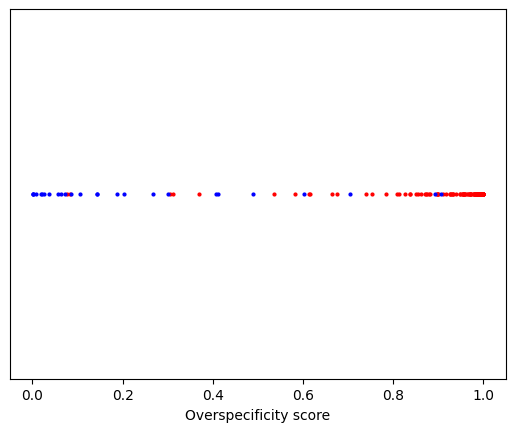

In [18]:
import matplotlib.pyplot as plt

# Example list of tuples
data = overspecificity_score_and_proto_mask

# Separate the data based on the second value
x_0 = [x for x, y, z in data if z == 0]  # First values where the second value is 0
x_1 = [x for x, y, z in data if z == 1]  # First values where the second value is 1

# Create a dummy y-axis value since this is a one-dimensional scatter plot
# y_0 = [y for x, y, z in data if z == 0]  # Dummy y values for blue points
# y_1 = [y for x, y, z in data if z == 1]  # Dummy y values for red points

# y_0 = [1]*len(x_0)
# y_1 = [1.5]*len(x_1)

y_0 = [1]*len(x_0)
y_1 = [1]*len(x_1)

# Plot the data
plt.scatter(x_1, y_1, color='red', label='Value 1', s=4)   # Plot points with second value 1 in red
plt.scatter(x_0, y_0, color='blue', label='Value 0', s=4)  # Plot points with second value 0 in blue


# Additional plot formatting
plt.xlabel('Overspecificity score')
# plt.ylabel('Num descendants')  # Hide y-axis ticks since it's a one-dimensional plot
plt.yticks([])
# plt.legend(loc='best')
# plt.title('One-dimensional Scatter Plot')
plt.show()


In [15]:
!pip show cairosvg

In [64]:
F

<module 'torch.nn.functional' from '/home/harishbabu/.conda/envs/hpnet4/lib/python3.9/site-packages/torch/nn/functional.py'>